In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import argparse

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument('strings', metavar='STRING', nargs='*', help='String for searching')
parser.add_argument('-f', '--file', help='Path for input file. First line should contain number of lines to search in')
parser.add_argument('--predict_days', help="How many days to the future from 1.1.2023 to predict.", type=int, default=365)
parser.add_argument('--predict_months', help="How many months to the future from 1.1.2023 to predict.", type=int, default=12)

args = parser.parse_args()

days_to_predict = int(args.predict_days)
months_to_predict = int(args.predict_months)

In [3]:
# concat data from multiple CSVs to a single dataframe
df_list = []
filepaths = ['./data-nehody/data_GIS_12-' + str(y) for y in range(2016, 2023)]
for path in filepaths:
    csv_files = glob.glob(path + "/*.csv")
    dfs_in_file = [pd.read_csv(file, sep=";", encoding='ANSI', header=None, low_memory=False) for file in csv_files]
    df_list.append(pd.concat(dfs_in_file, axis=0, ignore_index=True))

accidents_df = pd.concat(df_list, axis=0, ignore_index=True)
accidents_df['date'] = pd.to_datetime(accidents_df[3])
accidents_df['weekday'] = accidents_df[4]
accidents_df = accidents_df[['date', 'weekday']]

In [4]:
accidents_df.head(5)

date  weekday
0 2016-01-01        5
1 2016-01-01        5
2 2016-01-01        5
3 2016-01-01        5
4 2016-01-01        5

Text(0, 0.5, 'number of accidents')

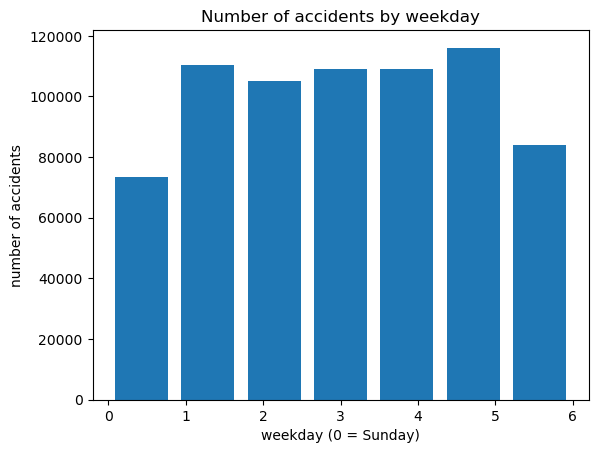

In [5]:
# during the weekend, i.e. saturday (6) and sunday (0), less accidents. 
plt.hist(accidents_df['weekday'], bins=7, rwidth=0.8)
plt.title("Number of accidents by weekday")
plt.xlabel("weekday (0 = Sunday)")
plt.ylabel("number of accidents")

In [6]:
# count number of accidents for each day/month/year
daily_count = pd.DataFrame(accidents_df.groupby(accidents_df['date'].dt.date)['date'].count())
monthly_count = pd.DataFrame(accidents_df.groupby(accidents_df['date'].dt.to_period('M'))['date'].count())
yearly_count = pd.DataFrame(accidents_df.groupby(accidents_df['date'].dt.to_period('Y'))['date'].count())

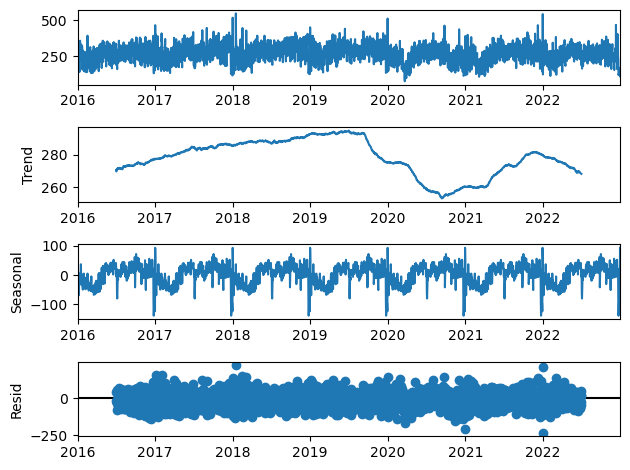

In [7]:
# seasonal decomposition
decomposed = seasonal_decompose(daily_count, period=365).plot()

Text(0, 0.5, 'number of accidents')

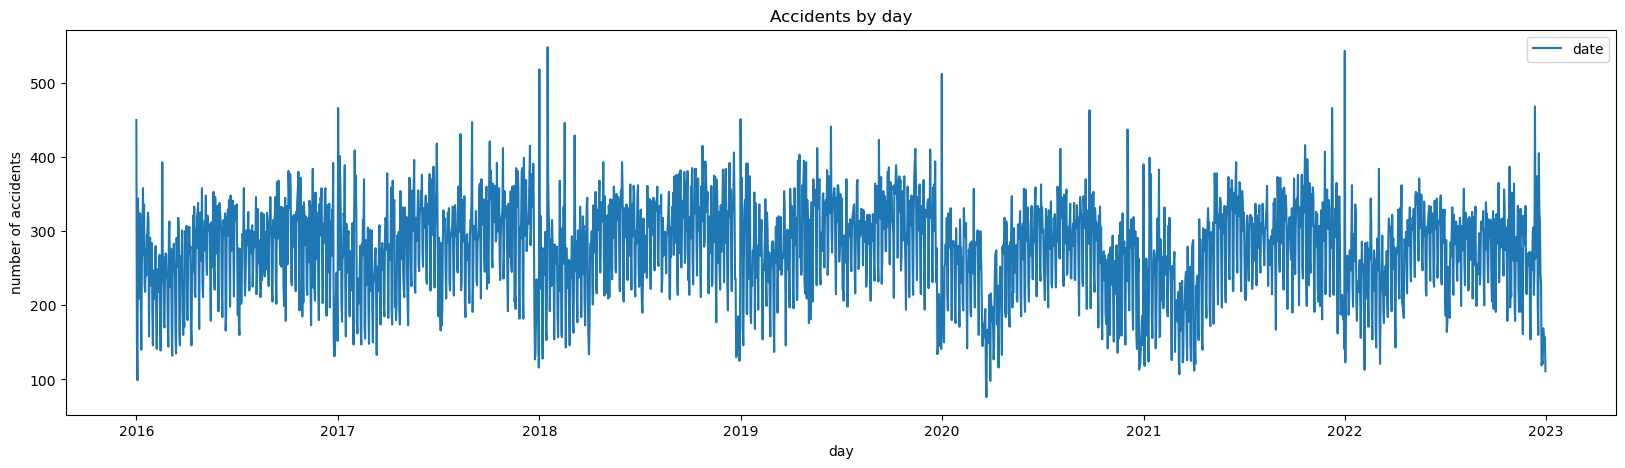

In [8]:
# plot number of accidents on each day
plt.rcParams['figure.figsize'] = [20, 5]
daily_count.plot()
plt.title("Accidents by day")
plt.xlabel("day")
plt.ylabel("number of accidents")

Text(0, 0.5, 'number of accidents')

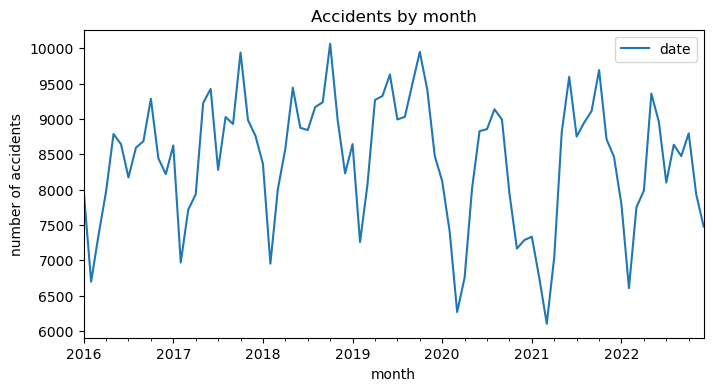

In [9]:
# plot number of accidents in each month
plt.rcParams['figure.figsize'] = [8, 4]
monthly_count.plot()
plt.title("Accidents by month")
plt.xlabel("month")
plt.ylabel("number of accidents")

Text(0, 0.5, 'number of accidents')

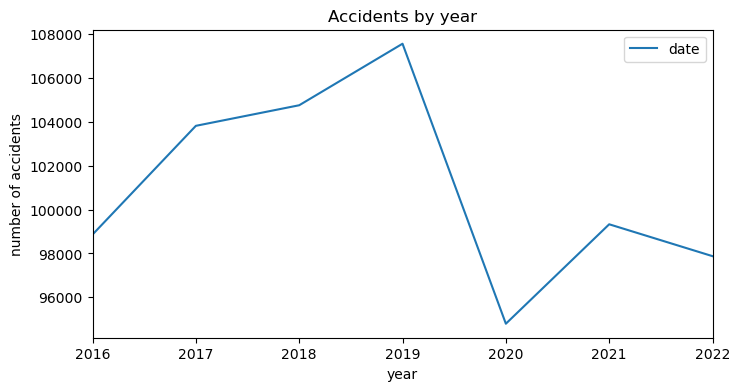

In [10]:
# plot number of accidents in each year
yearly_count.plot()
plt.title("Accidents by year")
plt.xlabel("year")
plt.ylabel("number of accidents")

In [11]:
# split the data to training set and test set

column_names = ['ds', 'y']  # ds = date, y = number of accidents in that day/month

# train set = years 2016-2021, test set = year 2022
monthly_count_train = monthly_count[:len(monthly_count) - months_to_predict].rename(columns={'date': 'y'}).reset_index()
monthly_count_train.columns = column_names
monthly_count_train['ds'] = monthly_count_train['ds'].dt.to_timestamp()
monthly_count_test = monthly_count[len(monthly_count) - months_to_predict:].rename(columns={'date': 'y'}).reset_index()
monthly_count_test.columns = column_names
monthly_count_test['ds'] = monthly_count_test['ds'].dt.to_timestamp()

print(monthly_count_train)
print(monthly_count_test)

# split also daily data in the same way
daily_count_train = daily_count[:len(daily_count) - days_to_predict].rename(columns={'date': 'y'}).reset_index()
daily_count_train.columns = column_names
daily_count_test = daily_count[len(daily_count) - days_to_predict:].rename(columns={'date': 'y'}).reset_index()
daily_count_test.columns = column_names

print(daily_count_train)
print(daily_count_test)

           ds     y
0  2016-01-01  7992
1  2016-02-01  6698
2  2016-03-01  7362
3  2016-04-01  7974
4  2016-05-01  8788
..        ...   ...
67 2021-08-01  8949
68 2021-09-01  9114
69 2021-10-01  9693
70 2021-11-01  8715
71 2021-12-01  8464

[72 rows x 2 columns]
           ds     y
0  2022-01-01  7786
1  2022-02-01  6607
2  2022-03-01  7750
3  2022-04-01  7987
4  2022-05-01  9359
5  2022-06-01  8962
6  2022-07-01  8101
7  2022-08-01  8636
8  2022-09-01  8476
9  2022-10-01  8798
10 2022-11-01  7936
11 2022-12-01  7479
              ds    y
0     2016-01-01  450
1     2016-01-02  148
2     2016-01-03   99
3     2016-01-04  344
4     2016-01-05  271
...          ...  ...
2187  2021-12-27  214
2188  2021-12-28  199
2189  2021-12-29  181
2190  2021-12-30  198
2191  2021-12-31  141

[2192 rows x 2 columns]
             ds    y
0    2022-01-01  543
1    2022-01-02  123
2    2022-01-03  234
3    2022-01-04  246
4    2022-01-05  219
..          ...  ...
360  2022-12-27  169
361  2022-12-28  157

In [12]:
daily_count = pd.concat([daily_count_train, daily_count_test[len(daily_count_test) - days_to_predict:]])
monthly_count = pd.concat([monthly_count_train, monthly_count_test[len(monthly_count_test) - months_to_predict:]])
print(daily_count)
print(monthly_count)

             ds    y
0    2016-01-01  450
1    2016-01-02  148
2    2016-01-03   99
3    2016-01-04  344
4    2016-01-05  271
..          ...  ...
360  2022-12-27  169
361  2022-12-28  157
362  2022-12-29  151
363  2022-12-30  157
364  2022-12-31  111

[2557 rows x 2 columns]
           ds     y
0  2016-01-01  7992
1  2016-02-01  6698
2  2016-03-01  7362
3  2016-04-01  7974
4  2016-05-01  8788
..        ...   ...
7  2022-08-01  8636
8  2022-09-01  8476
9  2022-10-01  8798
10 2022-11-01  7936
11 2022-12-01  7479

[84 rows x 2 columns]


In [13]:
# create a monthly dataframe that will contain forecasts from all applied algorithms
monthly_predict_df = pd.DataFrame(monthly_count['ds'])

# add new dates to the monthly_predict_df in the length of months from the arguments
last_date = monthly_predict_df['ds'].max()
future_dates = pd.date_range(start=last_date, periods=months_to_predict + 1, freq='MS')
new_rows = pd.DataFrame(future_dates, columns=['ds'])
new_rows = new_rows.iloc[1:]

monthly_predict_df = pd.concat([monthly_predict_df, new_rows])

monthly_predict_df['original'] = list(monthly_count_train['y']) + list(monthly_count_test['y']) + [None] * months_to_predict
monthly_predict_df.set_index('ds', inplace=True)

monthly_predict_df

original
ds                  
2016-01-01    7992.0
2016-02-01    6698.0
2016-03-01    7362.0
2016-04-01    7974.0
2016-05-01    8788.0
...              ...
2023-08-01       NaN
2023-09-01       NaN
2023-10-01       NaN
2023-11-01       NaN
2023-12-01       NaN

[96 rows x 1 columns]

In [14]:
# create a daily dataframe that will contain forecasts from all applied algorithms
daily_predict_df = pd.DataFrame(daily_count['ds'])

# add new dates to the daily_predict_df in the length of days from the arguments
last_date = daily_predict_df['ds'].max()
future_dates = pd.date_range(start=last_date, periods=days_to_predict + 1, freq='1d')
new_rows = pd.DataFrame(future_dates, columns=['ds'])
new_rows = new_rows.iloc[1:]

daily_predict_df = pd.concat([daily_predict_df, new_rows])

daily_predict_df['original'] = list(daily_count_train['y']) + list(daily_count_test['y']) + [None] * days_to_predict
daily_predict_df.set_index('ds', inplace=True)

daily_predict_df

original
ds                           
2016-01-01              450.0
2016-01-02              148.0
2016-01-03               99.0
2016-01-04              344.0
2016-01-05              271.0
...                       ...
2023-12-27 00:00:00       NaN
2023-12-28 00:00:00       NaN
2023-12-29 00:00:00       NaN
2023-12-30 00:00:00       NaN
2023-12-31 00:00:00       NaN

[2922 rows x 1 columns]

In [18]:
# Prophet - daily
m = Prophet()  # create new object for daily forecast
m.fit(daily_count_train)  # fit the training data
future = m.make_future_dataframe(periods=365 + days_to_predict)  # set length of forecast

17:34:55 - cmdstanpy - INFO - Chain [1] start processing
17:34:55 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
forecast = m.predict(future)  # predict the number of observations that was set in the previous step

Text(83.09722222222221, 0.5, 'number of accidents')

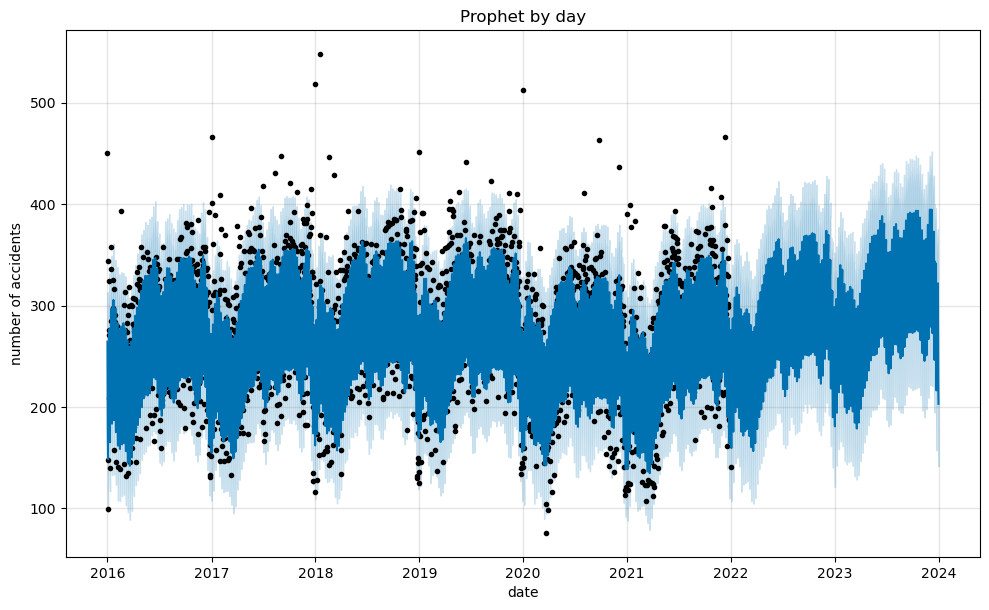

In [20]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(24)

fig1 = m.plot(forecast)  # plot the forecast
plt.title("Prophet by day")
plt.xlabel("date")
plt.ylabel("number of accidents")

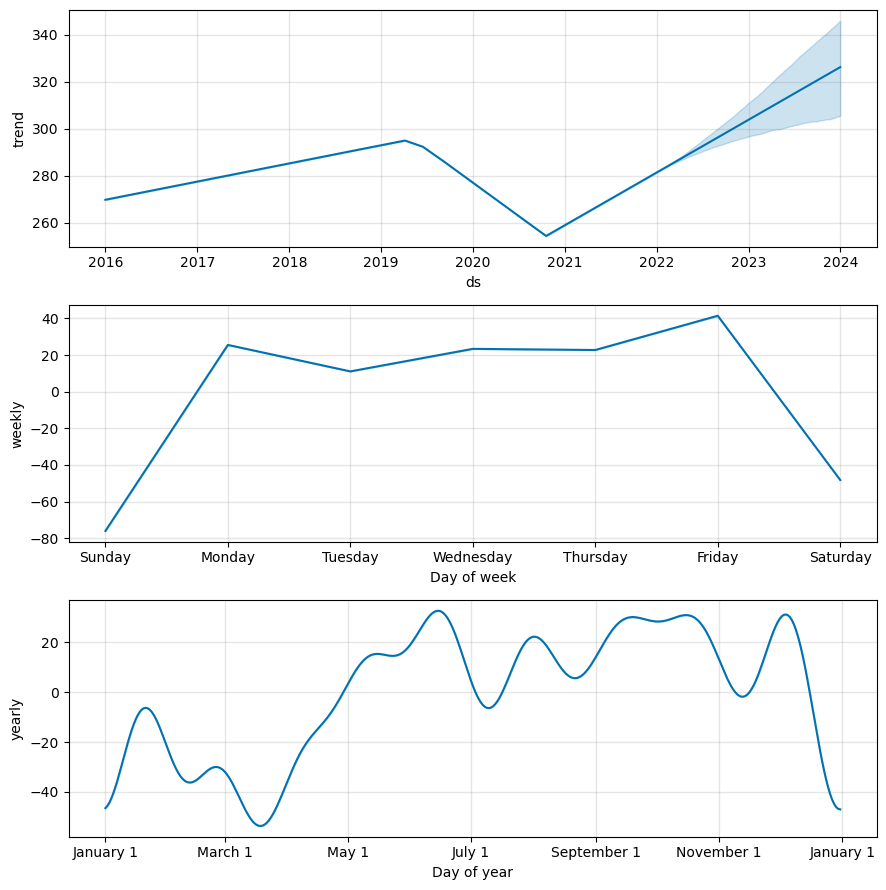

In [21]:
fig2 = m.plot_components(forecast)

C:\Users\katka\AppData\Local\Temp\ipykernel_9724\1882925781.py:15: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  daily_predict_df[['original', 'Prophet']].plot()


Text(0, 0.5, 'number of accidents')

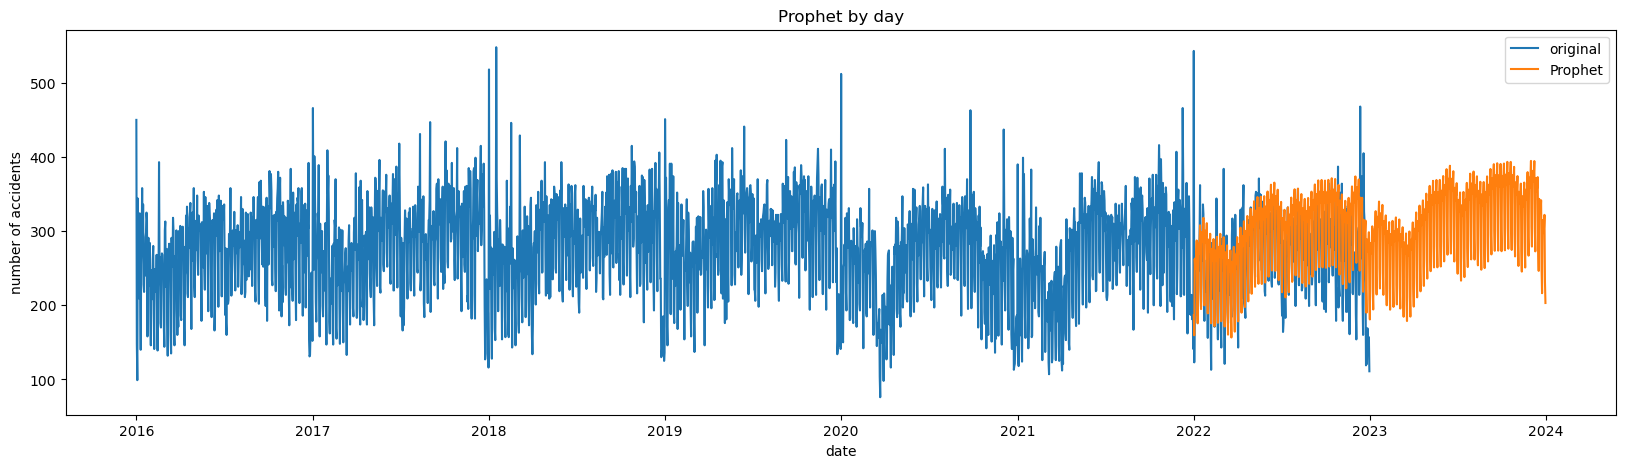

In [22]:
daily_predict_df['Prophet'] = [None]*len(daily_count_train) + list(forecast['yhat'].tail(365 + days_to_predict))  # add results to daily_predict_df

plt.rcParams['figure.figsize'] = [20, 5]  # adjust size of plot
daily_predict_df[['original', 'Prophet']].plot()
plt.title("Prophet by day")
plt.xlabel("date")
plt.ylabel("number of accidents")

In [23]:
# Prophet - monthly

m = Prophet()  # create new object for monthly forecast
m.fit(monthly_count_train)  # fit the training data
future = m.make_future_dataframe(periods=12 + months_to_predict, freq='MS')  # set length of forecast
forecast = m.predict(future)  # predict for the number of observations set in the previous step

17:35:05 - cmdstanpy - INFO - Chain [1] start processing
17:35:06 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Prophet by month')

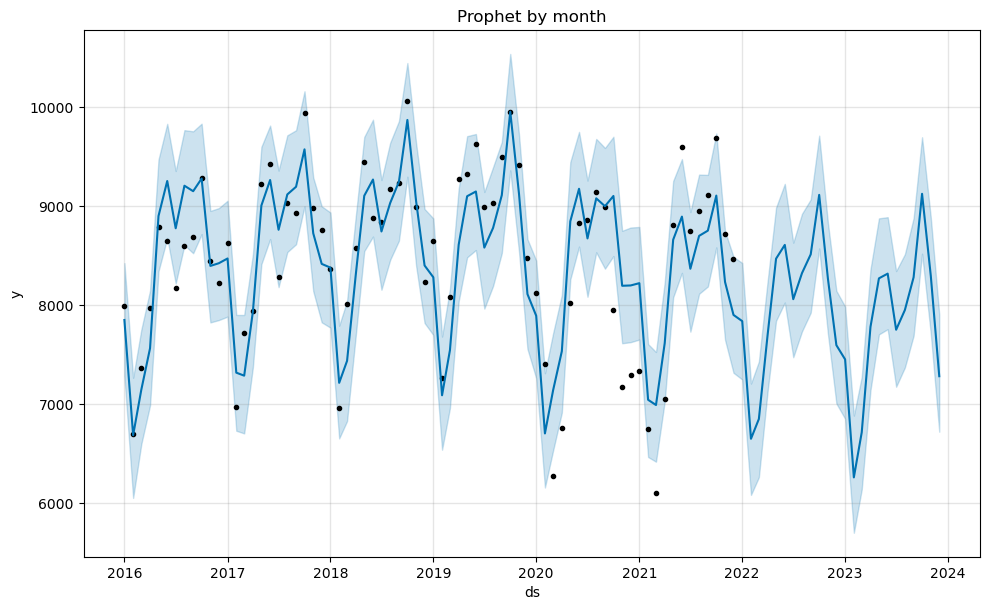

In [24]:
fig1 = m.plot(forecast)  # plot the monthly forecast
plt.title("Prophet by month")

Text(0, 0.5, 'number of accidents')

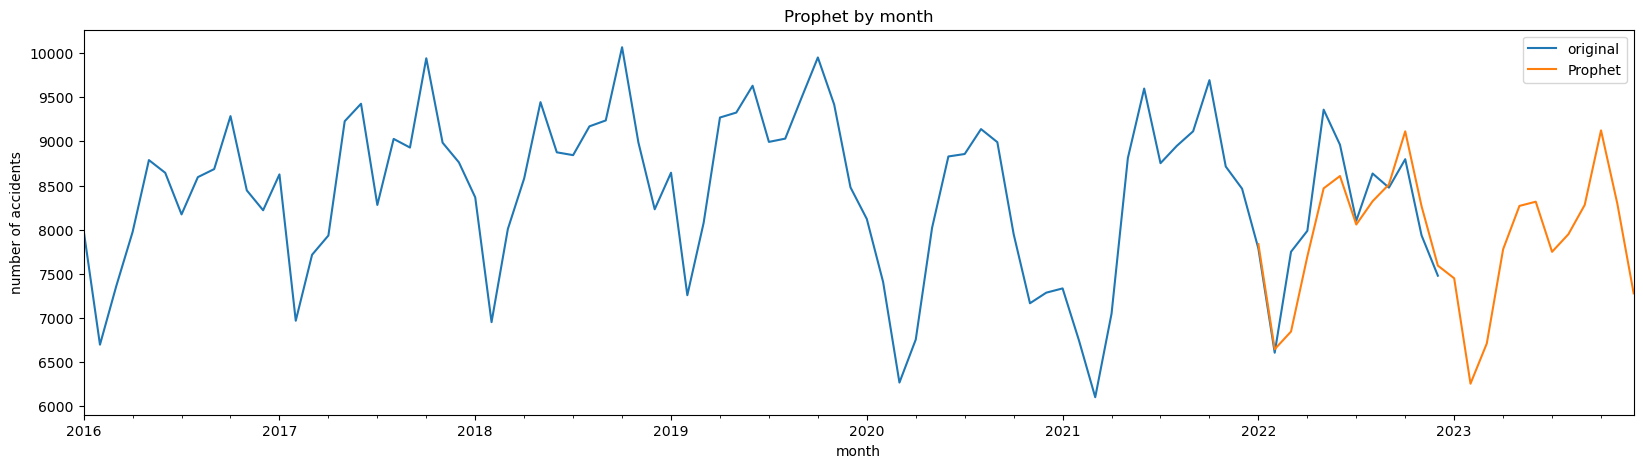

In [25]:
monthly_predict_df['Prophet'] = [None]*len(monthly_count_train) + list(forecast['yhat'].tail(months_to_predict + 12))  # add the forecast to monthly_predict_df

monthly_predict_df[['original', 'Prophet']].plot()
plt.title("Prophet by month")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [27]:
# use grid search to find the most optimal hyperparameters for SVR model
param_grid = {
    'kernel': ['rbf', 'sigmoid'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'gamma': ['scale', 'auto', 0.1, 1]
}

cv = TimeSeriesSplit(n_splits=5)

svr = SVR()

grid_search = GridSearchCV(svr, param_grid, cv=cv)
grid_search.fit(monthly_count_train['ds'].values.reshape(-1, 1), monthly_count_train['y'].values)  # fit the training data

print("Best parameters: ", grid_search.best_params_)  # print the most optimal hyperparameter values
print("Best score: ", grid_search.best_score_)

Best parameters:  {'C': 0.1, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'sigmoid'}
Best score:  -0.27046021919169255


In [28]:
# SVR - monthly
model = SVR(kernel='sigmoid',gamma='scale', C=0.1, epsilon=0.01)  # create model with values from the GridSearchCV
model.fit(monthly_count_train.index.values.reshape(-1, 1), monthly_count_train['y'].values)  # fit the training data

y_pred = model.predict(monthly_count_test.index.values.reshape(-1, 1))

y_pred

array([8665.08881798, 8665.14638761, 8665.20215476, 8665.2546307 ,
       8665.30283094, 8665.34629635, 8665.38498619, 8665.41912341,
       8665.44905691, 8665.47516897, 8665.49782677, 8665.51736445])

Text(0, 0.5, 'number of accidents')

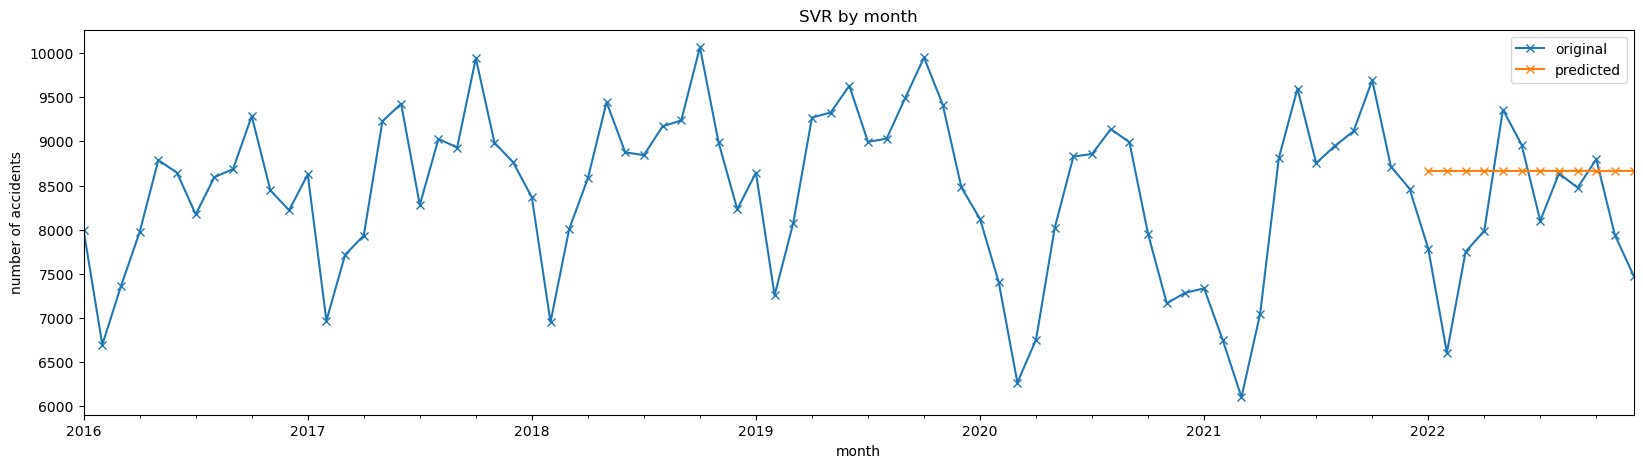

In [34]:
# plot the whole dataset + add predicted values for 2022
predict_df = pd.DataFrame(monthly_count)
predict_df['forecast_value'] = [None]*len(monthly_count_train) + list(y_pred)

predict_df.set_index('ds', inplace=True)
predict_df.columns = ["original", "predicted"]
predict_df.plot(marker='x')
plt.title("SVR by month")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [35]:
# use grid search to find the most optimal hyperparameters for SVR model
param_grid = {
    'kernel': ['rbf', 'sigmoid'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'gamma': ['scale', 'auto', 0.1, 1]
}

cv = TimeSeriesSplit(n_splits=5)

svr = SVR()

grid_search = GridSearchCV(svr, param_grid, cv=cv)
grid_search.fit(daily_count_train.index.values.reshape(-1, 1), daily_count_train['y'].values)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'C': 0.1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
Best score:  -0.06738035160774655


In [159]:
# SVR - daily
model = SVR(kernel='sigmoid', gamma='scale', C=0.1, epsilon=0.1)  # create model with values from the GridSearchCV
model.fit(daily_count_train.index.values.reshape(-1, 1), daily_count_train['y'].values)  # fit the training data

y_pred = model.predict(daily_count_test.index.values.reshape(-1, 1))

y_pred

array([281.60313903, 281.59868663, 281.5942348 , 281.58978408,
       281.58533503, 281.58088822, 281.5764442 , 281.57200353,
       281.56756676, 281.56313446, 281.55870718, 281.55428548,
       281.54986991, 281.54546102, 281.54105938, 281.53666553,
       281.53228002, 281.52790342, 281.52353626, 281.51917911,
       281.5148325 , 281.51049699, 281.50617313, 281.50186145,
       281.49756251, 281.49327685, 281.489005  , 281.48474752,
       281.48050493, 281.47627778, 281.4720666 , 281.46787193,
       281.4636943 , 281.45953424, 281.45539228, 281.45126894,
       281.44716475, 281.44308024, 281.43901593, 281.43497233,
       281.43094997, 281.42694935, 281.42297099, 281.4190154 ,
       281.41508308, 281.41117456, 281.40729031, 281.40343085,
       281.39959668, 281.39578829, 281.39200616, 281.3882508 ,
       281.38452268, 281.3808223 , 281.37715012, 281.37350663,
       281.36989231, 281.36630762, 281.36275303, 281.35922901,
       281.35573602, 281.35227452, 281.34884495, 281.34

Text(0, 0.5, 'number of accidents')

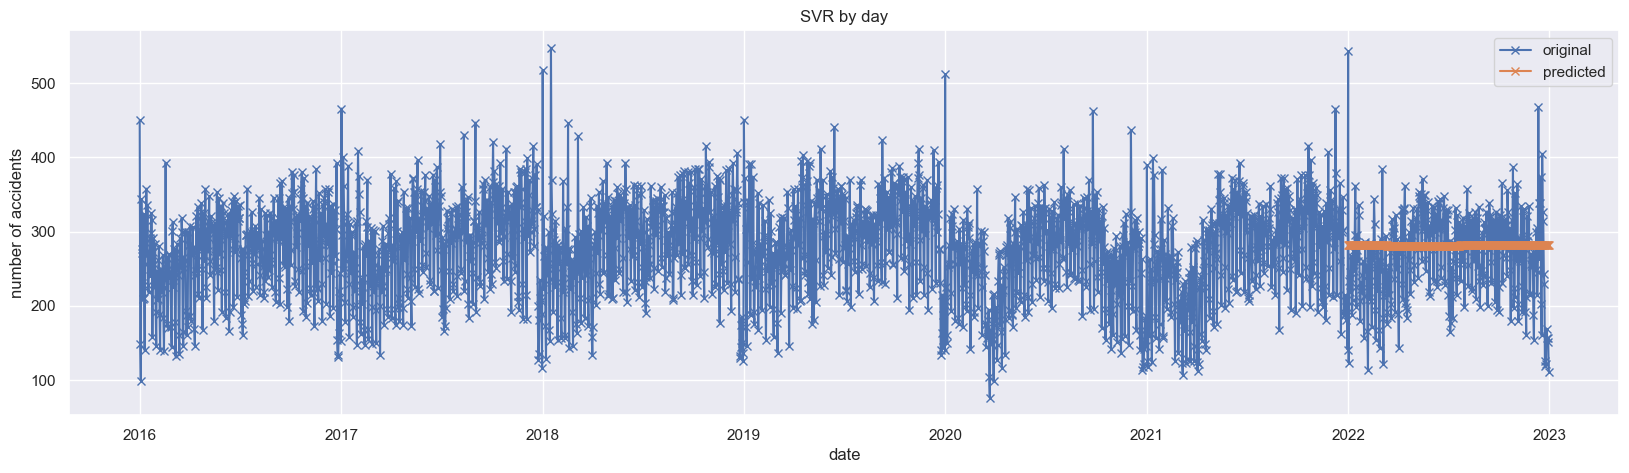

In [160]:
# plot the whole dataset + add predicted values for 2022
daily_count = pd.DataFrame(accidents_df.groupby(accidents_df['date'].dt.date)['date'].count())
predict_df = pd.DataFrame(daily_count)
predict_df['forecast_value'] = [None]*len(daily_count_train) + list(y_pred)

plt.rcParams['figure.figsize'] = [20, 5]
predict_df.columns = ["original", "predicted"]
predict_df.plot(marker='x')
plt.title("SVR by day")
plt.xlabel("date")
plt.ylabel("number of accidents")

In [38]:
# # scaling the data for SVR
# window_size = 3

# # Compute rolling mean and standard deviation
# rolling_mean = monthly_count_train['y'].rolling(window=window_size).mean()
# rolling_std = monthly_count_train['y'].rolling(window=window_size).std()

# # Apply scaling transformation to each time step
# scaled_data = (monthly_count_train['y'] - rolling_mean) / rolling_std

# scaled_data

# monthly_count_train['y'] = scaled_data


In [39]:
# monthly_count_train = monthly_count_train.iloc[2:]
# monthly_count_train

In [40]:
# #find optimal hyperparameters susing grid search for scaled data
# param_grid = {
#     'kernel': ['rbf', 'sigmoid'],
#     'C': [0.1, 1, 10],
#     'epsilon': [0.01, 0.1, 1],
#     'gamma': ['scale', 'auto', 0.1, 1]
# }

# cv = TimeSeriesSplit(n_splits=5)

# svr = SVR()

# grid_search = GridSearchCV(svr, param_grid, cv=cv)
# grid_search.fit(monthly_count_train.index.values.reshape(-1, 1), monthly_count_train['y'].values)

# print("Best parameters: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)

In [41]:
# # SVR - monhtly with scaled data
# model = SVR(kernel='rbf',gamma='auto', C=1, epsilon=1)
# model.fit(monthly_count_train.index.values.reshape(-1, 1), monthly_count_train['y'].values)

# y_pred = model.predict(monthly_count_test.index.values.reshape(-1, 1))

# y_pred

In [42]:
from scalecast.Forecaster import Forecaster

In [48]:
# create a Forecaster object that will make forecasts from multiple models with daily granularity
f_daily = Forecaster(
    y=np.array(daily_count['original']),
    current_dates=np.array(daily_count.index)
)
f_daily

Forecaster(
    DateStartActuals=2016-01-01T00:00:00.000000000
    DateEndActuals=2022-12-31T00:00:00.000000000
    Freq=D
    N_actuals=2557
    ForecastLength=0
    Xvars=[]
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [53]:
f_daily.set_test_length(365)  # reserve last 365 observations (a year) as a test set
f_daily.generate_future_dates(days_to_predict)  # predict specified number of days into the future
f_daily.set_validation_length(f_daily.test_length)
f_daily.auto_Xvar_select()
f_daily

Forecaster(
    DateStartActuals=2016-01-01T00:00:00.000000000
    DateEndActuals=2022-12-31T00:00:00.000000000
    Freq=D
    N_actuals=2557
    ForecastLength=365
    Xvars=['lnt', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36', 'AR37', 'AR38', 'AR39', 'AR40', 'AR41', 'AR42', 'AR43', 'AR44', 'AR45', 'AR46', 'AR47', 'AR48', 'AR49', 'AR50', 'AR51', 'AR52', 'AR53']
    TestLength=365
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [54]:
forecaster_estimators = ['arima', 'svr', 'xgboost', 'catboost', 'rnn', 'lstm']  # models that will by predicted by Forecaster
for method in forecaster_estimators:
    f_daily.set_estimator(method)
    f_daily.tune()  # find optimal hyperparameters for selected method
    f_daily.auto_forecast()  # predict future values using hyperparameters from the previous step
    print(f'Hyperparameter values for {method}:')
    print(f_daily.best_params)  # print the most optimal hyperparameters

Hyperparameter values for arima:
{'order': (2, 0, 0), 'seasonal_order': (0, 1, 1, 12)}
Hyperparameter values for svr:
{'kernel': 'linear', 'C': 3, 'epsilon': 1, 'gamma': 'scale'}
Hyperparameter values for xgboost:
{'n_estimators': 150, 'scale_pos_weight': 5, 'learning_rate': 0.1, 'gamma': 3, 'subsample': 0.9}
Hyperparameter values for catboost:
{'iterations': 200, 'learning_rate': 0.1, 'depth': 8, 'l2_leaf_reg': 3, 'verbose': 0}
67/67 [==============================] - 2s 29ms/step
Hyperparameter values for rnn:
{'layers_struct': [('LSTM', {'units': 50, 'activation': 'relu', 'return_sequences': True}), ('LSTM', {'units': 50, 'activation': 'relu', 'return_sequences': True}), ('LSTM', {'units': 50, 'activation': 'relu', 'return_sequences': False})], 'epochs': 25, 'verbose': 0}
69/69 [==============================] - 3s 44ms/step
Hyperparameter values for lstm:
{'lstm_layer_sizes': (50, 50, 50), 'activation': 'tanh', 'dropout': (0, 0, 0), 'lags': 10, 'verbose': 0, 'epochs': 5}


Text(0, 0.5, 'number of accidents')

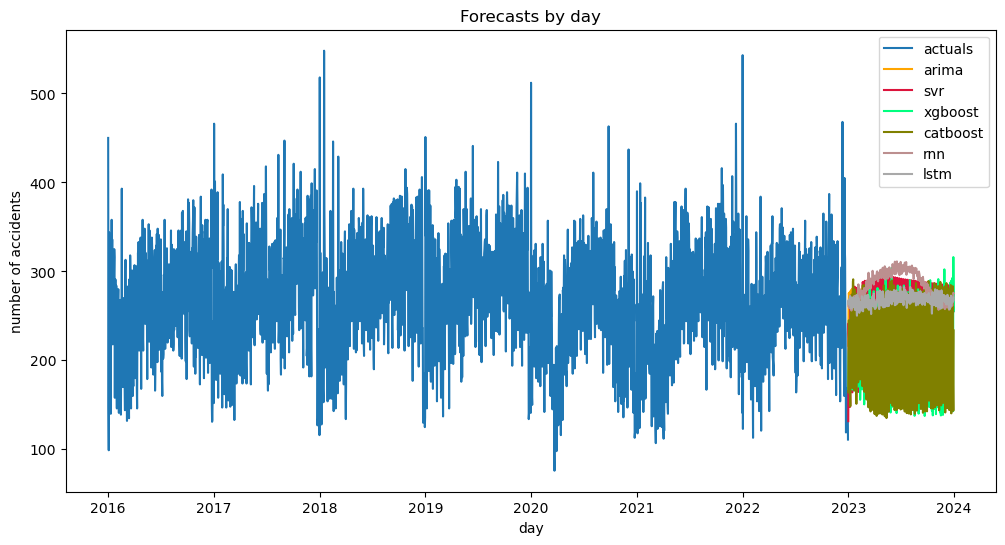

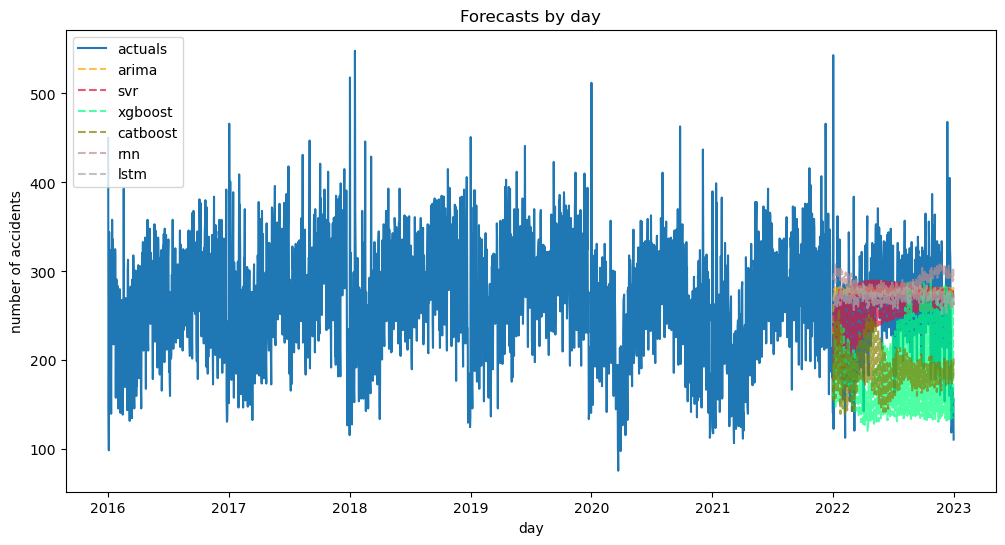

In [55]:
f_daily.plot()  # plots future values
plt.title("Forecasts by day")
plt.xlabel("day")
plt.ylabel("number of accidents")
f_daily.plot_test_set()  # plots values from test set
plt.title("Forecasts by day")
plt.xlabel("day")
plt.ylabel("number of accidents")

In [57]:
# add forecasts from models in Forecaster to daily_predict_df
for method in forecaster_estimators:
    result = f_daily.export_fitted_vals(method)
    daily_predict_df[method] = [None] * len(daily_count_train) + list(result.tail(days_to_predict + 365)['FittedVals'])
daily_predict_df

original     Prophet       arima         svr     xgboost  \
ds                                                                              
2016-01-01              450.0         NaN         NaN         NaN         NaN   
2016-01-02              148.0         NaN         NaN         NaN         NaN   
2016-01-03               99.0         NaN         NaN         NaN         NaN   
2016-01-04              344.0         NaN         NaN         NaN         NaN   
2016-01-05              271.0         NaN         NaN         NaN         NaN   
...                       ...         ...         ...         ...         ...   
2023-12-27 00:00:00       NaN  307.217432  225.791637  250.074637  172.927856   
2023-12-28 00:00:00       NaN  304.655051  242.064947  237.898649  155.386093   
2023-12-29 00:00:00       NaN  321.938731  234.417980  221.441723  147.735184   
2023-12-30 00:00:00       NaN  231.287019  238.109504  237.873521  153.593399   
2023-12-31 00:00:00       NaN  203.053664  237.921081  142.904538  111.033821   

                       catboost         rnn        lstm  
ds                                                       
2016-01-01                  NaN         NaN         NaN  
2016-01-02                  NaN         NaN         NaN  
2016-01-03                  NaN         NaN         NaN  
2016-01-04                  NaN         NaN         NaN  
2016-01-05                  NaN         NaN         NaN  
...                         ...         ...         ...  
2023-12-27 00:00:00  160.319163  266.612778  277.024074  
2023-12-28 00:00:00  158.826733  273.829317  274.779395  
2023-12-29 00:00:00  153.413006  271.737064  274.536773  
2023-12-30 00:00:00  157.342574  280.605329  273.598032  
2023-12-31 00:00:00  108.698764  276.267610  278.599136  

[2922 rows x 8 columns]

In [58]:
# create a Forecaster object that will make forecasts from multiple models with monthly granularity
f_monthly = Forecaster(
    y=np.array(monthly_count.reset_index()['y']),
    current_dates=np.array(monthly_count.reset_index()['ds'])
)
f_monthly

Forecaster(
    DateStartActuals=2016-01-01T00:00:00.000000000
    DateEndActuals=2022-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=84
    ForecastLength=0
    Xvars=[]
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [59]:
f_monthly.set_test_length(12)  # reserve last 12 observations (a year) as a test set
f_monthly.generate_future_dates(months_to_predict)  # predict 12 months into the future
f_monthly.set_validation_length(f_monthly.test_length)
f_monthly.auto_Xvar_select()
f_monthly

Forecaster(
    DateStartActuals=2016-01-01T00:00:00.000000000
    DateEndActuals=2022-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=84
    ForecastLength=12
    Xvars=['monthsin', 'monthcos', 'quartersin', 'quartercos']
    TestLength=12
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [60]:
for method in forecaster_estimators:
    f_monthly.set_estimator(method)
    f_monthly.tune()  # find optimal hyperparameters for selected method
    f_monthly.auto_forecast()  # predict future values using hyperparameters from the previous step
    print(f'Hyperparameter values for {method}:')
    print(f_monthly.best_params)  # print the most optimal hyperparameters

Hyperparameter values for arima:
{'order': (2, 0, 0), 'seasonal_order': (0, 0, 2, 12)}
Hyperparameter values for svr:
{'kernel': 'poly', 'C': 3, 'epsilon': 1, 'gamma': 'scale'}
Hyperparameter values for xgboost:
{'n_estimators': 250, 'scale_pos_weight': 5, 'learning_rate': 0.2, 'gamma': 0, 'subsample': 0.8}
Hyperparameter values for catboost:
{'iterations': 100, 'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 9, 'verbose': 0}
3/3 [==============================] - 0s 65ms/step
Hyperparameter values for rnn:
{'layers_struct': [('LSTM', {'units': 50, 'activation': 'tanh', 'dropout': 0.2, 'return_sequences': True}), ('LSTM', {'units': 50, 'activation': 'tanh', 'dropout': 0.2, 'return_sequences': True}), ('LSTM', {'units': 50, 'activation': 'tanh', 'dropout': 0.2, 'return_sequences': False})], 'epochs': 25, 'verbose': 0}
2/2 [==============================] - 0s 25ms/step
Hyperparameter values for lstm:
{'lstm_layer_sizes': (50, 50, 50), 'activation': 'relu', 'dropout': (0, 0, 0), 'lags':

Text(0, 0.5, 'number of accidents')

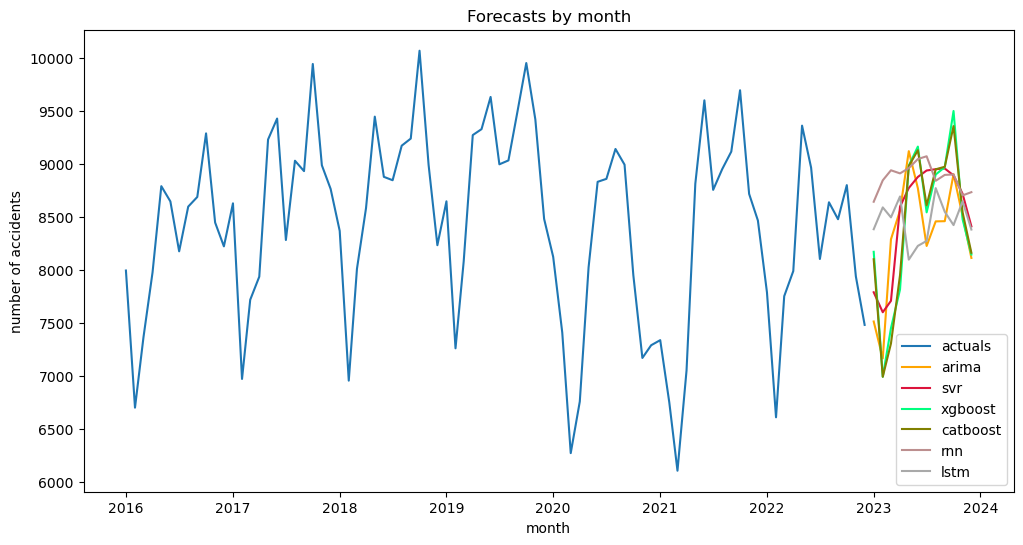

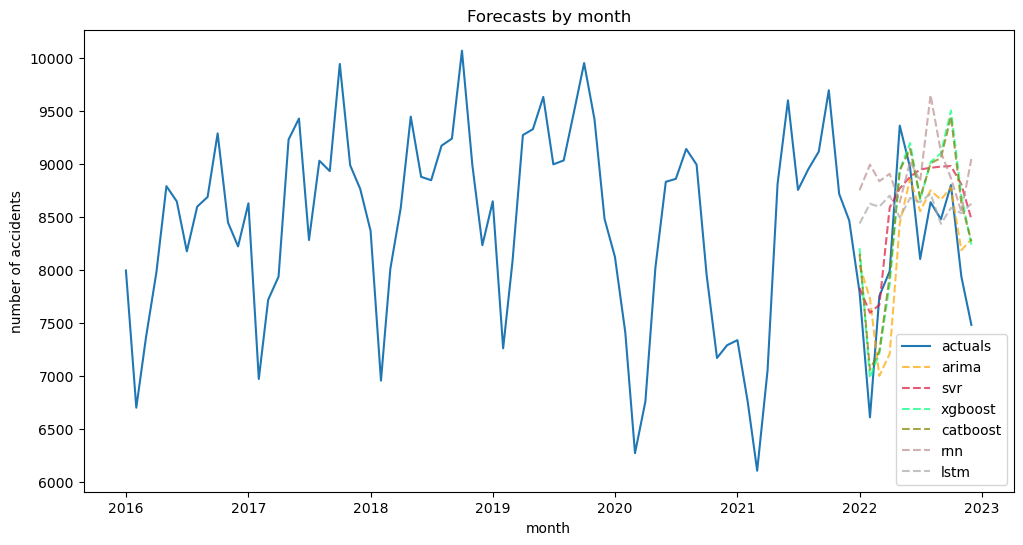

In [62]:
f_monthly.plot()  # plots future values
plt.title("Forecasts by month")
plt.xlabel("month")
plt.ylabel("number of accidents")
f_monthly.plot_test_set()  # plots values from test set
plt.title("Forecasts by month")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [64]:
# add forecasts from models in Forecaster to monthly_predict_df
for method in forecaster_estimators:
    result = f_monthly.export_fitted_vals(method)
    monthly_predict_df[method] = [None] * len(monthly_count_train) + list(result.tail(months_to_predict + 12)['FittedVals'])
monthly_predict_df

original      Prophet        arima          svr      xgboost  \
ds                                                                         
2016-01-01    7992.0          NaN          NaN          NaN          NaN   
2016-02-01    6698.0          NaN          NaN          NaN          NaN   
2016-03-01    7362.0          NaN          NaN          NaN          NaN   
2016-04-01    7974.0          NaN          NaN          NaN          NaN   
2016-05-01    8788.0          NaN          NaN          NaN          NaN   
...              ...          ...          ...          ...          ...   
2023-08-01       NaN  7948.404339  8347.768376  8948.031802  8897.983398   
2023-09-01       NaN  8280.045116  8720.182490  8954.668597  8967.149414   
2023-10-01       NaN  9124.274181  8824.095956  8889.665411  9497.236328   
2023-11-01       NaN  8294.161079  8316.773308  8715.999849  8475.584961   
2023-12-01       NaN  7279.427698  8067.838726  8408.677653  8143.119141   

               catboost          rnn         lstm  
ds                                                 
2016-01-01          NaN          NaN          NaN  
2016-02-01          NaN          NaN          NaN  
2016-03-01          NaN          NaN          NaN  
2016-04-01          NaN          NaN          NaN  
2016-05-01          NaN          NaN          NaN  
...                 ...          ...          ...  
2023-08-01  8947.191384  8838.750502  9093.315350  
2023-09-01  8971.107381  8894.291314  8815.979549  
2023-10-01  9354.696706  8898.400951  8687.664519  
2023-11-01  8539.760655  8700.910411  8944.312531  
2023-12-01  8159.440253  8731.407426  8631.491365  

[96 rows x 8 columns]

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn_genetic import GASearchCV
from sklearn_genetic import ExponentialAdapter
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution
from sklearn.metrics import accuracy_score

In [67]:
# split datetime to day, month, and year parts for models with GA
monthly_count_ga = monthly_count
monthly_count_ga['day'] = monthly_count['ds'].dt.day
monthly_count_ga['month'] = monthly_count['ds'].dt.month
monthly_count_ga['year'] = monthly_count['ds'].dt.year
monthly_count_ga

ds     y  forecast_value  day  month  year
0  2016-01-01  7992             NaN    1      1  2016
1  2016-02-01  6698             NaN    1      2  2016
2  2016-03-01  7362             NaN    1      3  2016
3  2016-04-01  7974             NaN    1      4  2016
4  2016-05-01  8788             NaN    1      5  2016
..        ...   ...             ...  ...    ...   ...
7  2022-08-01  8636     8665.419123    1      8  2022
8  2022-09-01  8476     8665.449057    1      9  2022
9  2022-10-01  8798     8665.475169    1     10  2022
10 2022-11-01  7936     8665.497827    1     11  2022
11 2022-12-01  7479     8665.517364    1     12  2022

[84 rows x 6 columns]

In [68]:
# split data to training and testing sets
X = monthly_count_ga[['day', 'month', 'year']]
y = monthly_count_ga['y']
X_train_ga = X[:len(X) - months_to_predict]
X_test_ga = X[len(X) - months_to_predict:]
y_train_ga = y[:len(y) - months_to_predict]  # test set = observations from the last year
y_test_ga = y[len(y) - months_to_predict:]
X_train_ga.shape, X_test_ga.shape, y_train_ga.shape, y_test_ga.shape

((72, 3), (12, 3), (72,), (12,))

In [69]:
rf = RandomForestRegressor(random_state=111)

In [70]:
# adapters used in GA Search
mutation_adapter = ExponentialAdapter(initial_value=0.9, end_value=0.1, adaptive_rate=0.1)
crossover_adapter = ExponentialAdapter(initial_value=0.1, end_value=0.9, adaptive_rate=0.1)

In [71]:
# grid with attributes for random forest, for genetic algorithm
rf_grid_ga = {
    'n_estimators': Integer(100, 600),
    'max_features': Categorical(['auto', 'sqrt', 'log2']),
    'max_depth': Integer(2,20),
    'criterion': Categorical(['poisson', 'squared_error', 'absolute_error', 'friedman_mse']),
    'min_samples_split': Continuous(0.1, 0.9),
    'bootstrap': Categorical([True, False])
}

In [72]:
rf_estimator_ga = GASearchCV(estimator=rf,
                             scoring='r2',
                             population_size=100,
                             generations=12,
                             mutation_probability=mutation_adapter,
                             crossover_probability=crossover_adapter,
                             param_grid=rf_grid_ga,
                             n_jobs=-1,
                             error_score='raise'
                            )

In [73]:
rf_estimator_ga.fit(X_train_ga, y_train_ga)  # fit the training data

gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	100   	0.0170321	0.132165   	0.186899   	-0.297425  
1  	200   	0.105947 	0.0656701  	0.191491   	-0.0346184 
2  	200   	0.145531 	0.0414787  	0.191491   	0.00878559 
3  	200   	0.174611 	0.0186384  	0.218462   	0.0776478  
4  	200   	0.184146 	0.0119695  	0.218462   	0.13889    
5  	200   	0.191649 	0.0119881  	0.218462   	0.172834   
6  	200   	0.196292 	0.0130866  	0.218462   	0.167156   
7  	200   	0.204572 	0.0137184  	0.218462   	0.168234   
8  	200   	0.215056 	0.00851693 	0.218462   	0.190602   
9  	200   	0.217764 	0.00397929 	0.218462   	0.192764   
10 	200   	0.218462 	0          	0.218462   	0.218462   
11 	200   	0.218462 	0          	0.218462   	0.218462   
12 	200   	0.218171 	0.00289153 	0.218462   	0.189401   


C:\Users\katka\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GASearchCV(crossover_probability=<sklearn_genetic.schedules.schedulers.ExponentialAdapter object at 0x000001E137075970>,
           error_score='raise',
           estimator=RandomForestRegressor(bootstrap=False,
                                           criterion='absolute_error',
                                           max_depth=9, max_features='auto',
                                           min_samples_split=0.35170322838248047,
                                           n_estimators=297, random_state=111),
           generations=12,
           mutation_probabili...
                       'max_depth': <sklearn_genetic.space.space.Integer object at 0x000001E13C193A00>,
                       'max_features': <sklearn_genetic.space.space.Categorical object at 0x000001E13C193FD0>,
                       'min_samples_split': <sklearn_genetic.space.space.Continuous object at 0x000001E13C193AC0>,
                       'n_estimators': <sklearn_genetic.space.space.Integer object at 0x000001E13C193D30>},
           population_size=100, return_train_score=True, scoring='r2')

In [75]:
# prepare testing data with future dates in the length of argument months_to_predict
last_date = monthly_count_ga.ds.max()
future_dates = pd.date_range(start=last_date, periods=months_to_predict + 1, freq='MS')
new_rows = pd.DataFrame(future_dates, columns=['ds'])
new_rows = new_rows.iloc[1:]
new_rows['day'] = new_rows['ds'].dt.day
new_rows['month'] = new_rows['ds'].dt.month
new_rows['year'] = new_rows['ds'].dt.year
X_test_ga = pd.concat([X_test_ga, new_rows])

In [76]:
X_test_ga = X_test_ga[['day', 'month', 'year']]
X_test_ga

day  month  year
0     1      1  2022
1     1      2  2022
2     1      3  2022
3     1      4  2022
4     1      5  2022
5     1      6  2022
6     1      7  2022
7     1      8  2022
8     1      9  2022
9     1     10  2022
10    1     11  2022
11    1     12  2022
1     1      1  2023
2     1      2  2023
3     1      3  2023
4     1      4  2023
5     1      5  2023
6     1      6  2023
7     1      7  2023
8     1      8  2023
9     1      9  2023
10    1     10  2023
11    1     11  2023
12    1     12  2023

In [77]:
y_predict_rf_ga = rf_estimator_ga.predict(X_test_ga)  # predict future dates

In [78]:
y_predict_rf_ga

array([7561.5, 7561.5, 7561.5, 7561.5, 8843. , 8843. , 8843. , 8843. ,
       8843. , 8843. , 8843. , 8347.5, 7561.5, 7561.5, 7561.5, 7561.5,
       8843. , 8843. , 8843. , 8843. , 8843. , 8843. , 8843. , 8347.5])

C:\Users\katka\anaconda3\lib\site-packages\sklearn_genetic\plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


<Axes: title={'center': 'Fitness average evolution over generations'}, xlabel='generations', ylabel='fitness (score)'>

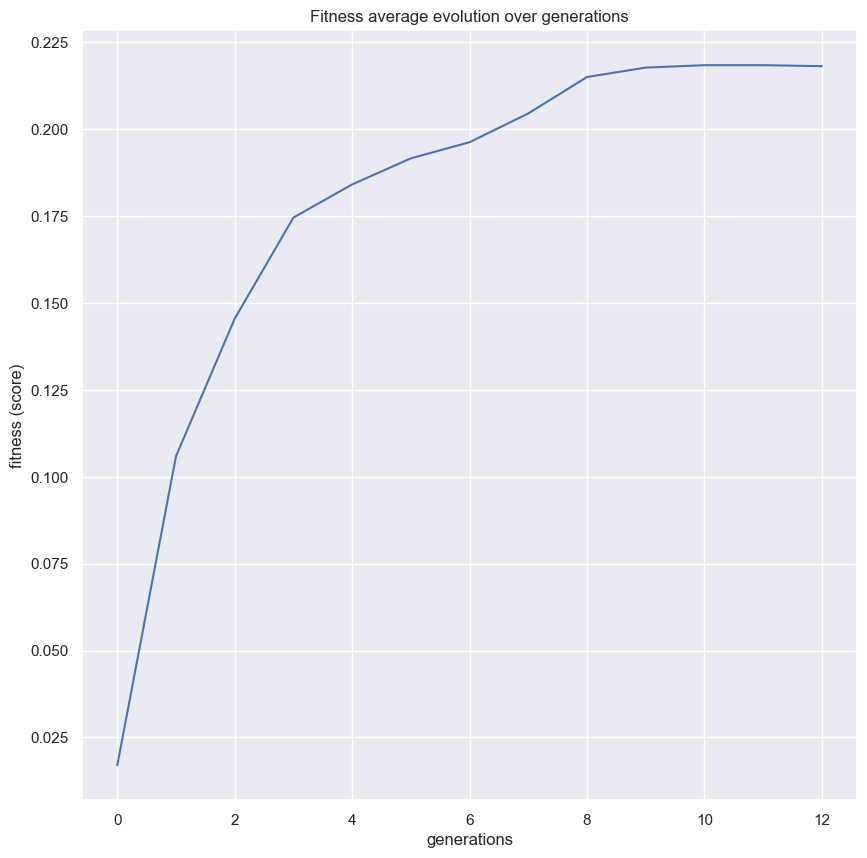

In [79]:
plot_fitness_evolution(rf_estimator_ga)

In [81]:
# prepare dataframe with forecast values (predict_df will contain all hyperparameter optimization techniques)
predict_df = monthly_count[['ds']]

last_date = predict_df.ds.max()
future_dates = pd.date_range(start=last_date, periods=months_to_predict + 1, freq='MS')
new_rows = pd.DataFrame(future_dates, columns=['ds'])
new_rows = new_rows.iloc[1:]

predict_df = pd.concat([predict_df, new_rows])

predict_df['original'] = list(y_train_ga) + list(y_test_ga) + [None] * 12
predict_df['predicted - GA'] = [None] * len(X_train_ga) + list(y_predict_rf_ga)
predict_df.set_index('ds', inplace=True)

Text(0, 0.5, 'number of accidents')

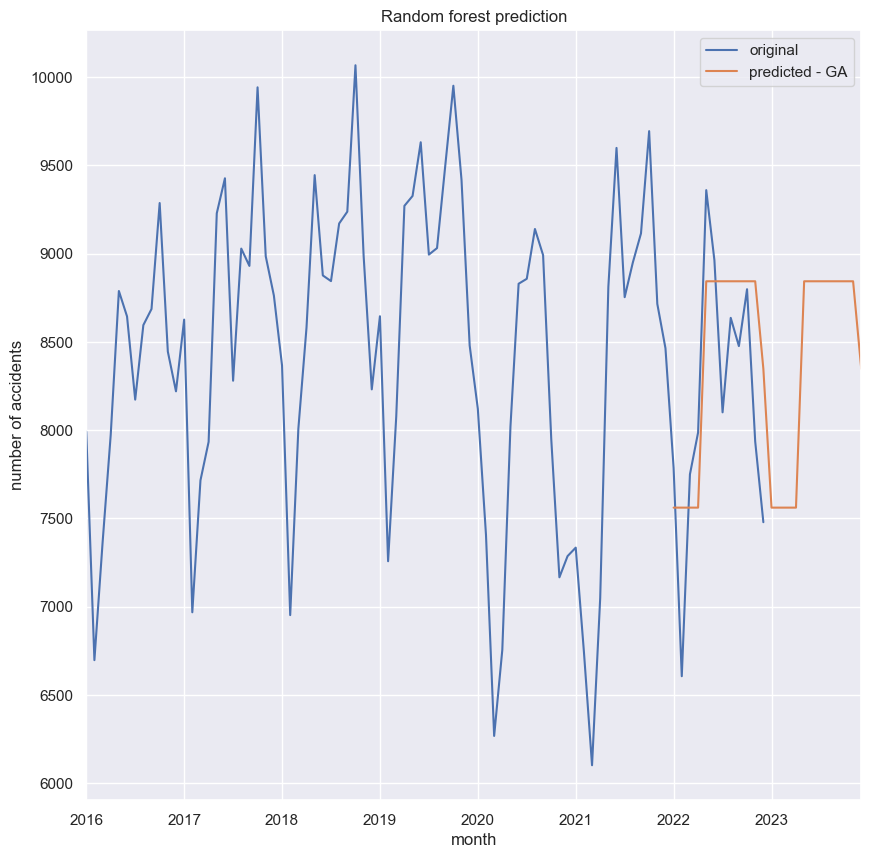

In [82]:
# plot results with random forest and GA
predict_df.plot()
plt.title("Random forest prediction")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [83]:
# create grid for randomized searach cv
rf_grid_randomized = {
    'n_estimators': [100, 600],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [2, 20],
    'criterion': ['poisson', 'squared_error', 'absolute_error', 'friedman_mse'],
    'min_samples_split': [0.1, 0.9],
    'bootstrap': [True, False]
}

In [84]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(random_state=111)
rf_estimator_randomized = RandomizedSearchCV(estimator=rf,
                                             scoring='r2',
                                             param_distributions = rf_grid_randomized,
                                             n_jobs=-1,
                                             error_score='raise',
                                             random_state=111
                                            )

In [85]:
rf_estimator_randomized.fit(X_train_ga, y_train_ga)

RandomizedSearchCV(error_score='raise',
                   estimator=RandomForestRegressor(random_state=111), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['poisson',
                                                      'squared_error',
                                                      'absolute_error',
                                                      'friedman_mse'],
                                        'max_depth': [2, 20],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_split': [0.1, 0.9],
                                        'n_estimators': [100, 600]},
                   random_state=111, scoring='r2')

In [86]:
y_predict_rf_randomized = rf_estimator_randomized.predict(X_test_ga)

In [87]:
y_predict_rf_randomized

array([7630.095, 6845.555, 6842.805, 6870.095, 8951.805, 8988.08 ,
       8894.985, 8992.625, 8996.925, 8841.67 , 8768.455, 8393.07 ,
       7630.095, 6845.555, 6842.805, 6870.095, 8951.805, 8988.08 ,
       8894.985, 8992.625, 8996.925, 8841.67 , 8768.455, 8393.07 ])

In [88]:
predict_df['predicted - randomized'] = [None] * len(X_train_ga) + list(y_predict_rf_randomized)

Text(0, 0.5, 'number of accidents')

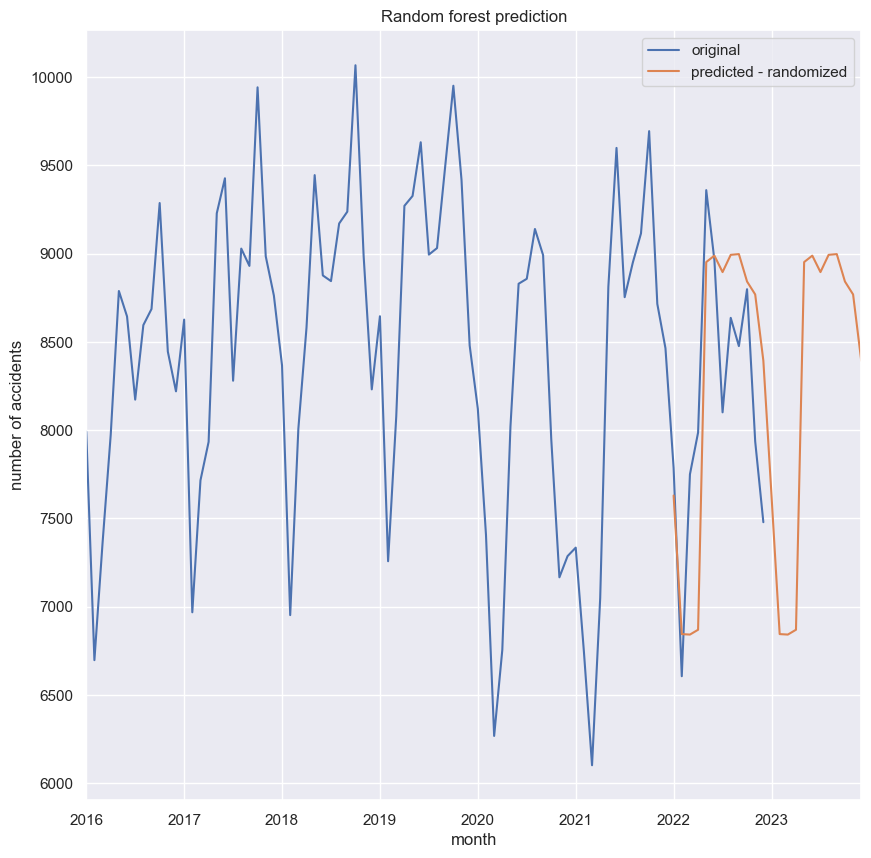

In [89]:
# plot results with random forest and randomized search cv
predict_df[['original', 'predicted - randomized']].plot()
plt.title("Random forest prediction")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [90]:
# grid for grid search cv
rf_grid_grid = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [2, 10, 20],
    'criterion': ['poisson', 'squared_error', 'absolute_error', 'friedman_mse'],
    'min_samples_split': [0.1, 0.5, 0.9],
    'bootstrap': [True, False]
}

In [91]:
from sklearn.model_selection import GridSearchCV
rf_estimator_grid = GridSearchCV(estimator=rf,
                                 scoring='r2',
                                 param_grid = rf_grid_grid,
                                 n_jobs=-1,
                                 error_score='raise'
                                )

In [92]:
y_predict_rf_grid = rf_estimator_grid.fit(X_train_ga, y_train_ga)

In [93]:
y_predict_rf_grid = rf_estimator_grid.predict(X_test_ga)

In [94]:
y_predict_rf_grid

array([7349.74916667, 6772.295     , 6784.82      , 6934.98916667,
       8999.1075    , 9123.6605    , 9093.26133333, 9118.51916667,
       9124.42166667, 9235.615     , 8369.1875    , 8312.3375    ,
       7349.74916667, 6772.295     , 6784.82      , 6934.98916667,
       8999.1075    , 9123.6605    , 9093.26133333, 9118.51916667,
       9124.42166667, 9235.615     , 8369.1875    , 8312.3375    ])

In [95]:
predict_df['predicted - grid'] = [None] * len(X_train_ga) + list(y_predict_rf_grid)

Text(0, 0.5, 'number of accidents')

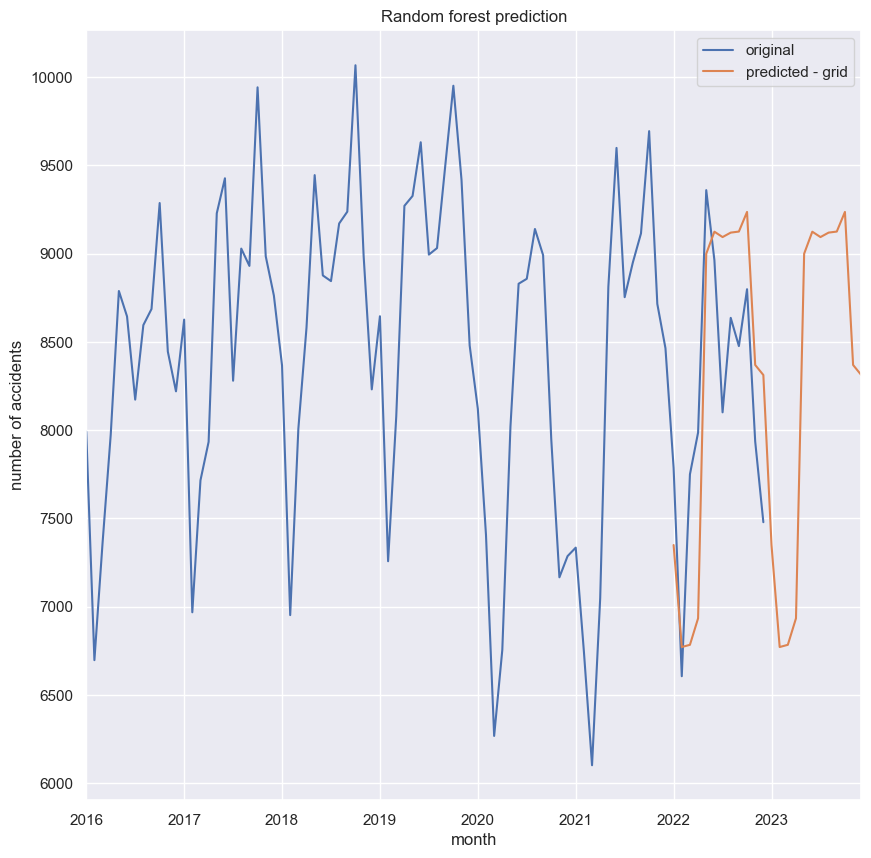

In [96]:
# plot results with random forest and grid search cv
predict_df[['original', 'predicted - grid']].plot()
plt.title("Random forest prediction")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [97]:
# r2 score with GA search cv
rf_estimator_ga.score(X_test_ga[:12], y_test_ga)

0.38079626248441134

In [98]:
# r2 score with randomized search cv
rf_estimator_randomized.score(X_test_ga[:12], y_test_ga)

0.1979372704462088

In [99]:
# r2 score with grid search cv
rf_estimator_grid.score(X_test_ga[:12], y_test_ga)

0.15756574479092245

Text(0, 0.5, 'number of accidents')

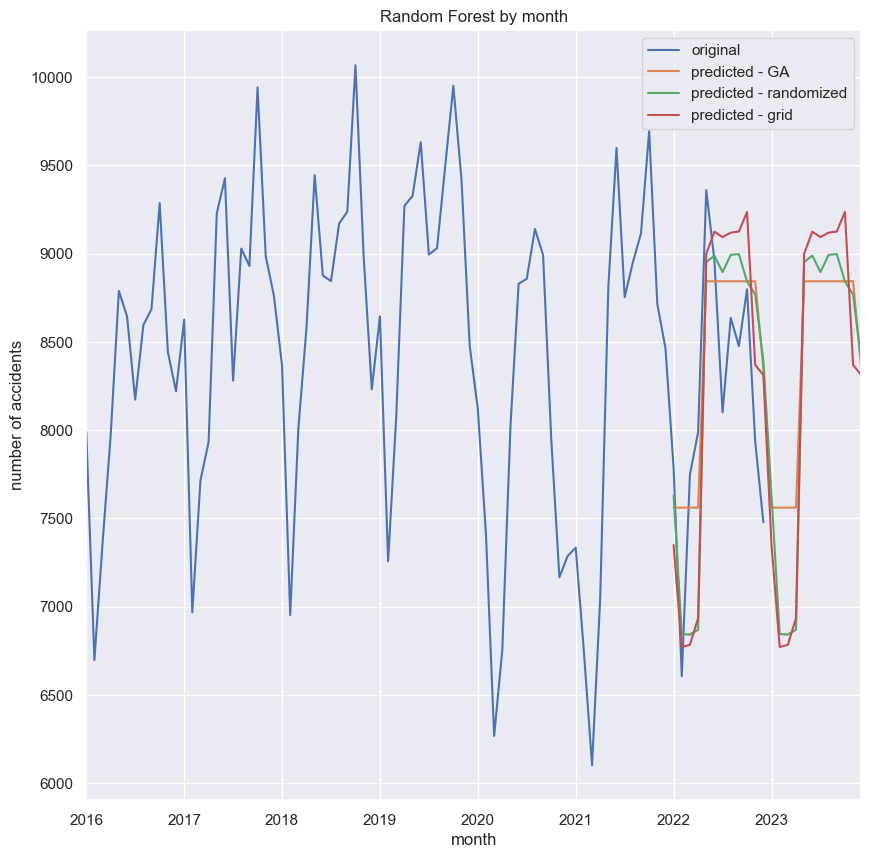

In [100]:
# plot all 3 techniques for random forest on one plot
predict_df.plot()
plt.title("Random Forest by month")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [101]:
monthly_predict_df['random forest + GA'] = list(predict_df['predicted - GA'])
monthly_predict_df['random forest + randomized'] = list(predict_df['predicted - randomized'])
monthly_predict_df['random forest + grid'] = list(predict_df['predicted - grid'])

monthly_predict_df

original      Prophet        arima          svr      xgboost  \
ds                                                                         
2016-01-01    7992.0          NaN          NaN          NaN          NaN   
2016-02-01    6698.0          NaN          NaN          NaN          NaN   
2016-03-01    7362.0          NaN          NaN          NaN          NaN   
2016-04-01    7974.0          NaN          NaN          NaN          NaN   
2016-05-01    8788.0          NaN          NaN          NaN          NaN   
...              ...          ...          ...          ...          ...   
2023-08-01       NaN  7948.404339  8347.768376  8948.031802  8897.983398   
2023-09-01       NaN  8280.045116  8720.182490  8954.668597  8967.149414   
2023-10-01       NaN  9124.274181  8824.095956  8889.665411  9497.236328   
2023-11-01       NaN  8294.161079  8316.773308  8715.999849  8475.584961   
2023-12-01       NaN  7279.427698  8067.838726  8408.677653  8143.119141   

               catboost          rnn         lstm  random forest + GA  \
ds                                                                      
2016-01-01          NaN          NaN          NaN                 NaN   
2016-02-01          NaN          NaN          NaN                 NaN   
2016-03-01          NaN          NaN          NaN                 NaN   
2016-04-01          NaN          NaN          NaN                 NaN   
2016-05-01          NaN          NaN          NaN                 NaN   
...                 ...          ...          ...                 ...   
2023-08-01  8947.191384  8838.750502  9093.315350              8843.0   
2023-09-01  8971.107381  8894.291314  8815.979549              8843.0   
2023-10-01  9354.696706  8898.400951  8687.664519              8843.0   
2023-11-01  8539.760655  8700.910411  8944.312531              8843.0   
2023-12-01  8159.440253  8731.407426  8631.491365              8347.5   

            random forest + randomized  random forest + grid  
ds                                                            
2016-01-01                         NaN                   NaN  
2016-02-01                         NaN                   NaN  
2016-03-01                         NaN                   NaN  
2016-04-01                         NaN                   NaN  
2016-05-01                         NaN                   NaN  
...                                ...                   ...  
2023-08-01                    8992.625           9118.519167  
2023-09-01                    8996.925           9124.421667  
2023-10-01                    8841.670           9235.615000  
2023-11-01                    8768.455           8369.187500  
2023-12-01                    8393.070           8312.337500  

[96 rows x 11 columns]

In [102]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [103]:
# pipeline with data scaling and random forest
steps = [
    ('scaler', MinMaxScaler()),  # Data preprocessing step
    ('rf', RandomForestRegressor(random_state=111))  # Random Forest Regressor step
]

In [104]:
pipeline = Pipeline(steps)

In [105]:
# GA search cv with pipeline
rf_grid_ga = {
    'rf__n_estimators': Integer(100, 600),
    'rf__max_features': Categorical(['auto', 'sqrt', 'log2']),
    'rf__max_depth': Integer(2,20),
    'rf__criterion': Categorical(['poisson', 'squared_error', 'absolute_error', 'friedman_mse']),
    'rf__min_samples_split': Continuous(0.1, 0.9),
    'rf__bootstrap': Categorical([True, False])
}

rf_estimator_ga = GASearchCV(estimator=pipeline,
                             scoring='r2',
                             population_size=100,
                             generations=12,
                             mutation_probability=mutation_adapter,
                             crossover_probability=crossover_adapter,
                             param_grid=rf_grid_ga,
                             n_jobs=-1,
                             error_score='raise'
                            )

In [106]:
rf_estimator_ga.fit(X_train_ga, y_train_ga)

gen	nevals	fitness   	fitness_std	fitness_max	fitness_min
0  	100   	-0.0037377	0.138848   	0.189401   	-0.2963    
1  	200   	0.115288  	0.0643555  	0.189401   	-0.0228029 
2  	200   	0.157506  	0.0438728  	0.218462   	0.0205104  
3  	200   	0.184253  	0.0222577  	0.218462   	0.0557783  
4  	200   	0.200146  	0.0148954  	0.218462   	0.167018   
5  	200   	0.213206  	0.0105888  	0.218462   	0.186899   
6  	200   	0.218462  	0          	0.218462   	0.218462   
7  	200   	0.218462  	0          	0.218462   	0.218462   
8  	200   	0.218462  	0          	0.218462   	0.218462   
9  	200   	0.218462  	0          	0.218462   	0.218462   
10 	200   	0.218462  	0          	0.218462   	0.218462   
11 	200   	0.218462  	0          	0.218462   	0.218462   
12 	200   	0.218462  	0          	0.218462   	0.218462   


C:\Users\katka\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GASearchCV(crossover_probability=<sklearn_genetic.schedules.schedulers.ExponentialAdapter object at 0x000001E137075970>,
           error_score='raise',
           estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                     ('rf',
                                      RandomForestRegressor(bootstrap=False,
                                                            criterion='absolute_error',
                                                            max_depth=19,
                                                            max_features='auto',
                                                            min_samples_split=0.40248585459011554,
                                                            n_estimators=119,
                                                            ra...
                       'rf__max_depth': <sklearn_genetic.space.space.Integer object at 0x000001E14A98FD00>,
                       'rf__max_features': <sklearn_genetic.space.space.Categorical object at 0x000001E12D2E2790>,
                       'rf__min_samples_split': <sklearn_genetic.space.space.Continuous object at 0x000001E14A98FF10>,
                       'rf__n_estimators': <sklearn_genetic.space.space.Integer object at 0x000001E12D2E2B20>},
           population_size=100, return_train_score=True, scoring='r2')

In [107]:
y_predict_rf_ga = rf_estimator_ga.predict(X_test_ga)

In [108]:
y_predict_rf_ga

array([7561.5, 7561.5, 7561.5, 7561.5, 8843. , 8843. , 8843. , 8843. ,
       8843. , 8843. , 8843. , 8347.5, 7561.5, 7561.5, 7561.5, 7561.5,
       8843. , 8843. , 8843. , 8843. , 8843. , 8843. , 8843. , 8347.5])

In [109]:
# r2 score for random forest with GA and pipeline
rf_estimator_ga.score(X_test_ga[:12], y_test_ga)

0.38079626248441134

In [110]:
predict_df['predicted - GA - pipe'] = [None] * len(X_train_ga) + list(y_predict_rf_ga)

Text(0, 0.5, 'number of accidents')

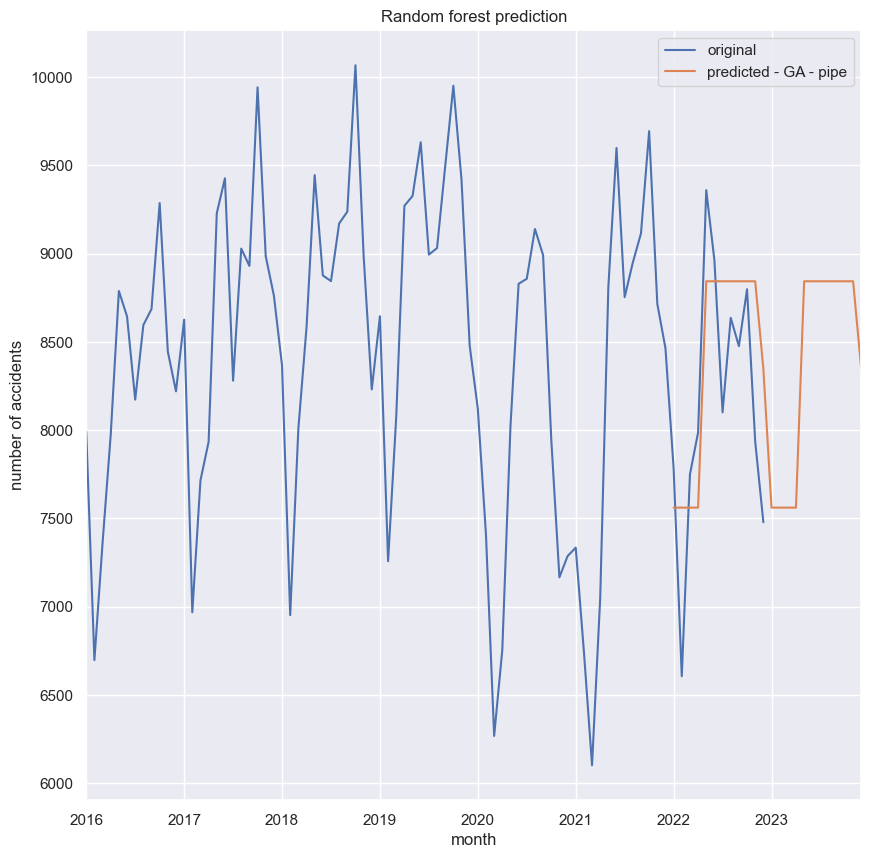

In [111]:
# plot results of random forest regressor with pipeline and GA search cv
predict_df[['original', 'predicted - GA - pipe']].plot()
plt.title("Random forest prediction")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [112]:
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing

In [113]:
mlp = MLPRegressor(random_state=111)

In [114]:
# adapters for MLP with GA search cv
mutation_adapter = ExponentialAdapter(initial_value=0.9, end_value=0.1, adaptive_rate=0.1)
crossover_adapter = ExponentialAdapter(initial_value=0.1, end_value=0.9, adaptive_rate=0.1)

In [115]:
# prepare data for MLP
scaler = StandardScaler()
scaler.fit(monthly_count_ga[['day', 'month', 'year', 'y']].head(len(monthly_count_ga) - 12))  # fit the scaler with training data

# generate new dates
new_rows['day'] = new_rows['ds'].dt.day
new_rows['month'] = new_rows['ds'].dt.month
new_rows['year'] = new_rows['ds'].dt.year
scaled_data = monthly_count[['day', 'month', 'year', 'y']]
scaled_data = pd.concat([scaled_data, new_rows[['day', 'month', 'year']]])
scaled_data = pd.DataFrame(scaler.transform(scaled_data[['day', 'month', 'year', 'y']]), columns=['day', 'month', 'year', 'y'])

X = scaled_data[['day', 'month', 'year']]
y = scaled_data['y']

# split the scaled data to train and test set
X_train_scale = X.head(len(X) - months_to_predict - 12)
X_test_scale = X.tail(months_to_predict + 12)
y_train_scale = y.head(len(X) - months_to_predict - 12)
y_test_scale = y.tail(months_to_predict + 12)
X_train_scale.shape, X_test_scale.shape, y_train_scale.shape, y_test_scale.shape

((72, 3), (24, 3), (72,), (24,))

In [116]:
# hyperparameters in MLP model with GA
mlp_grid_ga = {
    "hidden_layer_sizes": Integer(5, 200), 
    "activation": Categorical(["identity", "logistic", "tanh", "relu"]), 
    "solver": Categorical(["lbfgs", "sgd", "adam"]), 
    "alpha": Continuous(0.00005, 0.05),
    "learning_rate": Categorical(["constant", "invscaling", "adaptive"]),
    "max_iter": Integer(150, 300)
}

In [117]:
mlp_estimator_ga = GASearchCV(estimator=mlp,
                             scoring='r2',
                             population_size=200,
                             generations=12,
                             mutation_probability=mutation_adapter,
                             crossover_probability=crossover_adapter,
                             param_grid=mlp_grid_ga,
                             n_jobs=-1,
                             error_score='raise'
                            )

In [118]:
mlp_estimator_ga.fit(X_train_scale, y_train_scale)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	200   	-1.01293	1.2433     	0.0625037  	-7.59284   
1  	400   	-0.335475	0.283835   	-0.00145807	-2.70113   
2  	400   	-0.179366	0.124039   	0.0167943  	-0.630439  
3  	400   	-0.103608	0.0831016  	0.0167943  	-0.31437   
4  	400   	-0.0587204	0.0776349  	0.0862187  	-0.525659  
5  	400   	-0.0221795	0.0553872  	0.0862187  	-0.261055  
6  	400   	0.00446513	0.0517498  	0.101924   	-0.261055  
7  	400   	0.0239359 	0.0563062  	0.10444    	-0.475256  
8  	400   	0.0409197 	0.0499026  	0.10444    	-0.189403  
9  	400   	0.0570317 	0.0553975  	0.10444    	-0.278834  
10 	400   	0.0788366 	0.0458128  	0.10444    	-0.278834  
11 	400   	0.0960675 	0.0151141  	0.10444    	-0.0289057 
12 	400   	0.103089  	0.00379469 	0.10444    	0.086218   


GASearchCV(crossover_probability=<sklearn_genetic.schedules.schedulers.ExponentialAdapter object at 0x000001E13BE54430>,
           error_score='raise',
           estimator=MLPRegressor(activation='tanh',
                                  alpha=0.0014425222840322874,
                                  hidden_layer_sizes=92,
                                  learning_rate='invscaling', max_iter=215,
                                  random_state=111, solver='sgd'),
           generations=12,
           mutation_probability=<sklearn_geneti...
                       'hidden_layer_sizes': <sklearn_genetic.space.space.Integer object at 0x000001E14973ABB0>,
                       'learning_rate': <sklearn_genetic.space.space.Categorical object at 0x000001E15A9B9EE0>,
                       'max_iter': <sklearn_genetic.space.space.Integer object at 0x000001E136FB90A0>,
                       'solver': <sklearn_genetic.space.space.Categorical object at 0x000001E136FB9520>},
           population_size=200, return_train_score=True, scoring='r2')

In [119]:
y_predict_mlp_ga = mlp_estimator_ga.predict(X_test_scale)
y_predict_mlp_ga

array([-0.47122535, -0.36418169, -0.25693942, -0.15005491, -0.04407308,
        0.06048071,  0.16310836,  0.26334616,  0.3607716 ,  0.45500961,
        0.54573805,  0.63269201, -0.41897221, -0.31688245, -0.21508791,
       -0.11403188, -0.01414358,  0.08416507,  0.1805029 ,  0.27450344,
        0.36582958,  0.45417862,  0.53928738,  0.62093692])

In [120]:
# r2 score for MLP with GA
mlp_estimator_ga.score(X_test_scale.head(12), y_test_scale.head(12))

-0.25459454353833344

In [121]:
# create dataframe with forecast (MLP + GA)
predictions_unscaled = X_test_scale
predictions_unscaled['y'] = y_predict_mlp_ga.tolist()
predictions_unscaled = pd.DataFrame(scaler.inverse_transform(predictions_unscaled), columns=['day', 'month', 'year', 'y'])
predictions_unscaled

C:\Users\katka\AppData\Local\Temp\ipykernel_9724\3139332339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_unscaled['y'] = y_predict_mlp_ga.tolist()


day  month    year            y
0   1.0    1.0  2022.0  8031.953192
1   1.0    2.0  2022.0  8129.283052
2   1.0    3.0  2022.0  8226.793502
3   1.0    4.0  2022.0  8323.978663
4   1.0    5.0  2022.0  8420.343045
5   1.0    6.0  2022.0  8515.408985
6   1.0    7.0  2022.0  8608.723573
7   1.0    8.0  2022.0  8699.865183
8   1.0    9.0  2022.0  8788.449639
9   1.0   10.0  2022.0  8874.135914
10  1.0   11.0  2022.0  8956.631101
11  1.0   12.0  2022.0  9035.694327
12  1.0    1.0  2023.0  8079.464561
13  1.0    2.0  2023.0  8172.290075
14  1.0    3.0  2023.0  8264.847150
15  1.0    4.0  2023.0  8356.732735
16  1.0    5.0  2023.0  8447.556561
17  1.0    6.0  2023.0  8536.944086
18  1.0    7.0  2023.0  8624.539627
19  1.0    8.0  2023.0  8710.009983
20  1.0    9.0  2023.0  8793.048631
21  1.0   10.0  2023.0  8873.380333
22  1.0   11.0  2023.0  8950.765809
23  1.0   12.0  2023.0  9025.005965

Text(0, 0.5, 'number of accidents')

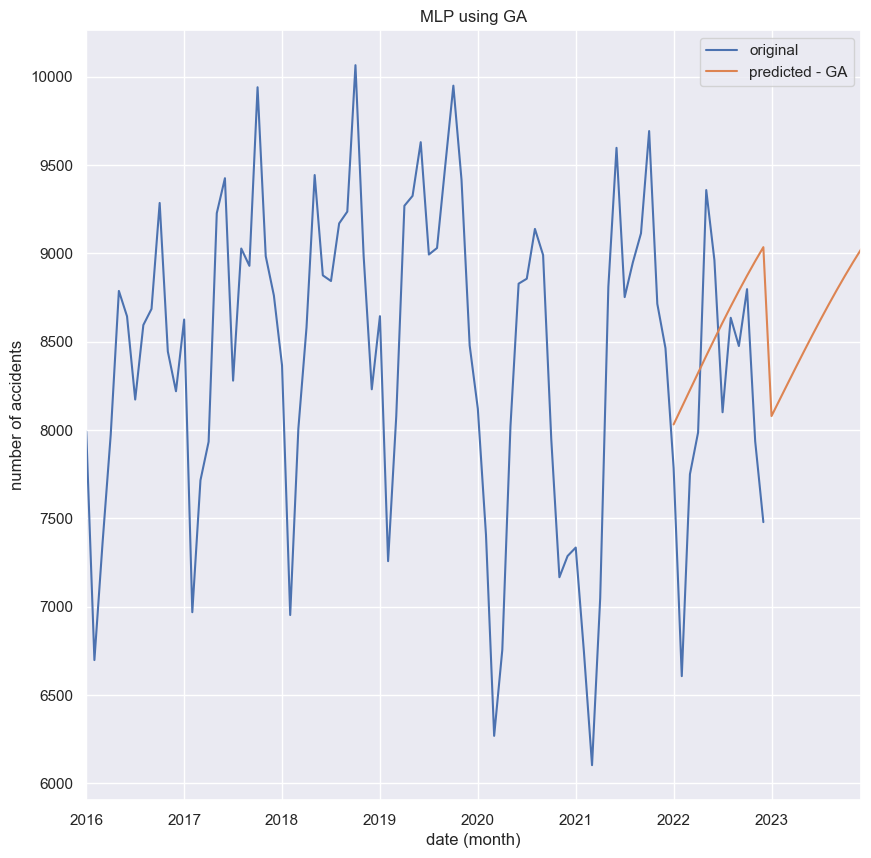

In [122]:
predict_df = pd.concat([monthly_count[['ds']], new_rows[['ds']]], ignore_index=True)  # add results to predict_df

predict_df['original'] = list(monthly_count['y']) + [None] * months_to_predict
predict_df['predicted - GA'] = [None] * (len(predict_df) - 12 - months_to_predict) + list(predictions_unscaled['y'])
predict_df.set_index('ds', inplace=True)
predict_df.plot()  # plot results of MLP with GA
plt.title("MLP using GA")
plt.xlabel("date (month)")
plt.ylabel("number of accidents")

C:\Users\katka\anaconda3\lib\site-packages\sklearn_genetic\plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


<Axes: title={'center': 'Fitness average evolution over generations'}, xlabel='generations', ylabel='fitness (score)'>

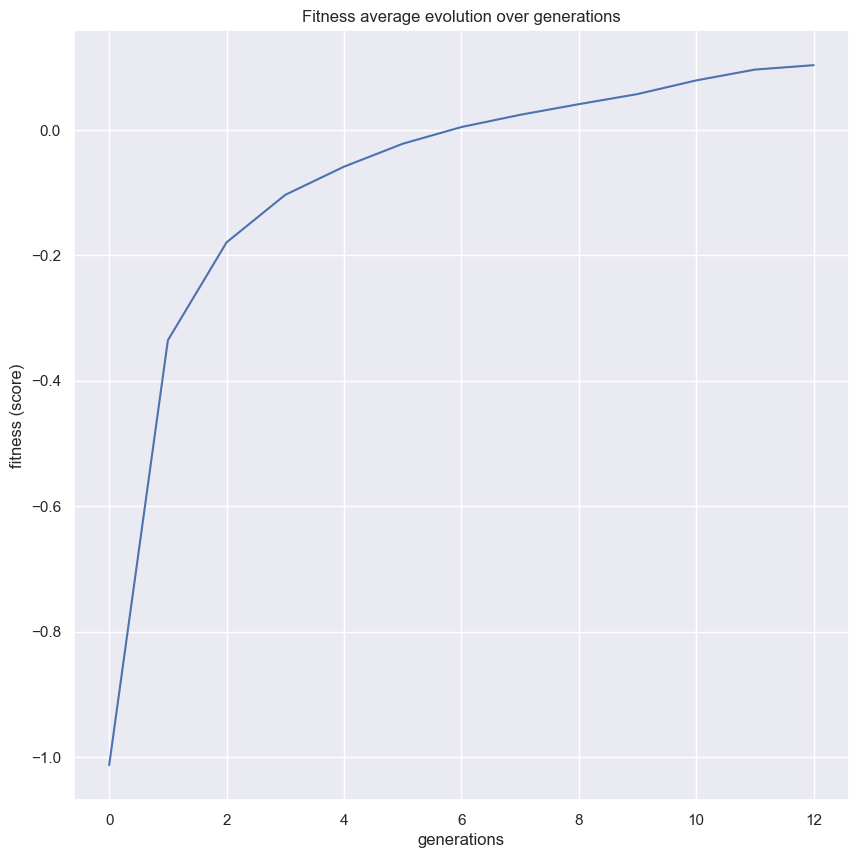

In [123]:
plot_fitness_evolution(mlp_estimator_ga)

In [124]:
# grid for MLP and Randomized search CV
mlp_grid_randomized = {
    "hidden_layer_sizes": [10, 500], 
    "activation": ["identity", "logistic", "tanh", "relu"], 
    "solver": ["lbfgs", "sgd", "adam"], 
    "alpha": [0.00005, 0.05],
    "learning_rate": ["constant", "invscaling", "adaptive"],
    "max_iter": [150, 300]
}


In [125]:
from sklearn.model_selection import RandomizedSearchCV

mlp_estimator_randomized = RandomizedSearchCV(estimator=mlp,
                                             scoring='neg_root_mean_squared_error',
                                             param_distributions = mlp_grid_randomized,
                                             n_jobs=-1,
                                             error_score='raise',
                                             random_state=111
                                            )

In [126]:
mlp_estimator_randomized.fit(X_train_scale, y_train_scale)

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


RandomizedSearchCV(error_score='raise',
                   estimator=MLPRegressor(activation='tanh',
                                          alpha=0.0014425222840322874,
                                          hidden_layer_sizes=92,
                                          learning_rate='invscaling',
                                          max_iter=215, random_state=111,
                                          solver='sgd'),
                   n_jobs=-1,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'alpha': [5e-05, 0.05],
                                        'hidden_layer_sizes': [10, 500],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'max_iter': [150, 300],
                                        'solver': ['lbfgs', 'sgd', 'adam']},
                   random_state=111, scoring='neg_root_mean_squared_error')

In [127]:
y_predict_mlp_randomized = mlp_estimator_randomized.predict(X_test_scale[['day', 'month', 'year']])
y_predict_mlp_randomized

array([-2.10004791, -1.84246748, -1.56751849, -1.15981008, -0.74579814,
       -0.33178969,  0.05495546,  0.27451376,  0.21784281,  0.09216976,
       -0.05117521, -0.28436577, -2.3631446 , -2.0907177 , -1.81545806,
       -1.40918919, -1.00194054, -0.59775331, -0.23934798, -0.06574099,
       -0.09243835, -0.2037329 , -0.33350234, -0.47102197])

In [128]:
# r2 score for MLP regressor with randomized search cv
mlp_estimator_randomized.score(X_test_scale[['day', 'month', 'year']].head(12), y_test_scale.head(12))

-0.8130834123484522

In [129]:
# add forecasted values to a dataframe
predictions_unscaled = X_test_scale
predictions_unscaled['y'] = y_predict_mlp_randomized.tolist()
predictions_unscaled = pd.DataFrame(scaler.inverse_transform(predictions_unscaled), columns=['day', 'month', 'year', 'y'])
predictions_unscaled

C:\Users\katka\AppData\Local\Temp\ipykernel_9724\2992247175.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_unscaled['y'] = y_predict_mlp_randomized.tolist()


day  month    year            y
0   1.0    1.0  2022.0  6550.939973
1   1.0    2.0  2022.0  6785.145979
2   1.0    3.0  2022.0  7035.144409
3   1.0    4.0  2022.0  7405.854864
4   1.0    5.0  2022.0  7782.296823
5   1.0    6.0  2022.0  8158.735603
6   1.0    7.0  2022.0  8510.385131
7   1.0    8.0  2022.0  8710.019366
8   1.0    9.0  2022.0  8658.491085
9   1.0   10.0  2022.0  8544.222374
10  1.0   11.0  2022.0  8413.885407
11  1.0   12.0  2022.0  8201.855986
12  1.0    1.0  2023.0  6311.718291
13  1.0    2.0  2023.0  6559.423503
14  1.0    3.0  2023.0  6809.704399
15  1.0    4.0  2023.0  7179.105938
16  1.0    5.0  2023.0  7549.398352
17  1.0    6.0  2023.0  7916.907158
18  1.0    7.0  2023.0  8242.788586
19  1.0    8.0  2023.0  8400.641421
20  1.0    9.0  2023.0  8376.366737
21  1.0   10.0  2023.0  8275.171738
22  1.0   11.0  2023.0  8157.178373
23  1.0   12.0  2023.0  8032.138113

Text(0, 0.5, 'number of accidents')

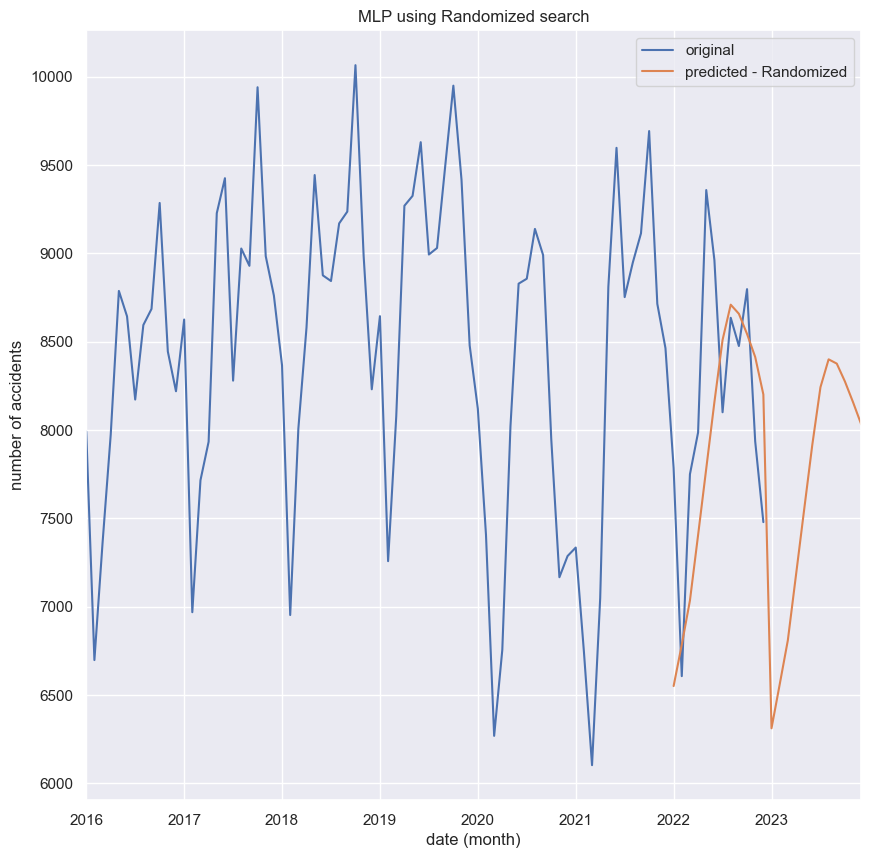

In [130]:
# plot predicted values from MLP model with randomized search cv
predict_df['predicted - Randomized'] = [None] * (len(predict_df) - 12 - months_to_predict) + list(predictions_unscaled['y'])
predict_df[['original', 'predicted - Randomized']].plot()
plt.title("MLP using Randomized search")
plt.xlabel("date (month)")
plt.ylabel("number of accidents")

In [131]:
# grid for MLP and Grid search CV
mlp_grid = {
    "hidden_layer_sizes": [10, 250, 500], 
    "activation": ["identity", "logistic", "tanh", "relu"], 
    "solver": ["lbfgs", "sgd", "adam"], 
    "alpha": [0.00005, 0.005, 0.05],
    "learning_rate": ["constant", "invscaling", "adaptive"],
    "max_iter": [150, 300]
}

In [132]:
from sklearn.model_selection import GridSearchCV

mlp_estimator_grid = GridSearchCV(estimator=mlp,
                                  scoring='neg_root_mean_squared_error',
                                  param_grid = mlp_grid_randomized,
                                  n_jobs=-1,
                                  error_score='raise'
                                 )

In [133]:
mlp_estimator_grid.fit(X_train_scale, y_train_scale)

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(error_score='raise',
             estimator=MLPRegressor(activation='tanh',
                                    alpha=0.0014425222840322874,
                                    hidden_layer_sizes=92,
                                    learning_rate='invscaling', max_iter=215,
                                    random_state=111, solver='sgd'),
             n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': [5e-05, 0.05],
                         'hidden_layer_sizes': [10, 500],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'max_iter': [150, 300],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='neg_root_mean_squared_error')

In [134]:
y_predict_mlp_grid = mlp_estimator_grid.predict(X_test_scale[['day', 'month', 'year']])
y_predict_mlp_grid

array([-0.84152622, -1.63788287, -1.80442158, -1.15825419,  0.1812241 ,
        1.19088398,  1.53300327,  1.56163188,  1.48957105,  1.38255307,
        1.25696781,  1.11634386, -0.52777083, -1.24823856, -1.42450206,
       -0.91962546,  0.36470287,  1.57898255,  2.09183655,  2.20186869,
        2.17957836,  2.1175718 ,  2.04008317,  1.95215859])

In [135]:
# r2 score for MLP regressor with grid search cv
mlp_estimator_grid.score(X_test_scale[['day', 'month', 'year']].head(12), y_test_scale.head(12))

-1.2796208462143457

In [136]:
# add forecasted values to a dataframe
predictions_unscaled = X_test_scale
predictions_unscaled['y'] = y_predict_mlp_grid.tolist()
predictions_unscaled = pd.DataFrame(scaler.inverse_transform(predictions_unscaled), columns=['day', 'month', 'year', 'y'])
predictions_unscaled

C:\Users\katka\AppData\Local\Temp\ipykernel_9724\1944907383.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_unscaled['y'] = y_predict_mlp_grid.tolist()


day  month    year             y
0   1.0    1.0  2022.0   7695.255690
1   1.0    2.0  2022.0   6971.165320
2   1.0    3.0  2022.0   6819.739359
3   1.0    4.0  2022.0   7407.269557
4   1.0    5.0  2022.0   8625.195378
5   1.0    6.0  2022.0   9543.232538
6   1.0    7.0  2022.0   9854.305826
7   1.0    8.0  2022.0   9880.336499
8   1.0    9.0  2022.0   9814.814911
9   1.0   10.0  2022.0   9717.508400
10  1.0   11.0  2022.0   9603.319513
11  1.0   12.0  2022.0   9475.456646
12  1.0    1.0  2023.0   7980.538994
13  1.0    2.0  2023.0   7325.450920
14  1.0    3.0  2023.0   7165.182649
15  1.0    4.0  2023.0   7624.243658
16  1.0    5.0  2023.0   8792.024160
17  1.0    6.0  2023.0   9896.112665
18  1.0    7.0  2023.0  10362.427147
19  1.0    8.0  2023.0  10462.474296
20  1.0    9.0  2023.0  10442.206732
21  1.0   10.0  2023.0  10385.827027
22  1.0   11.0  2023.0  10315.370186
23  1.0   12.0  2023.0  10235.424428

Text(0, 0.5, 'number of accidents')

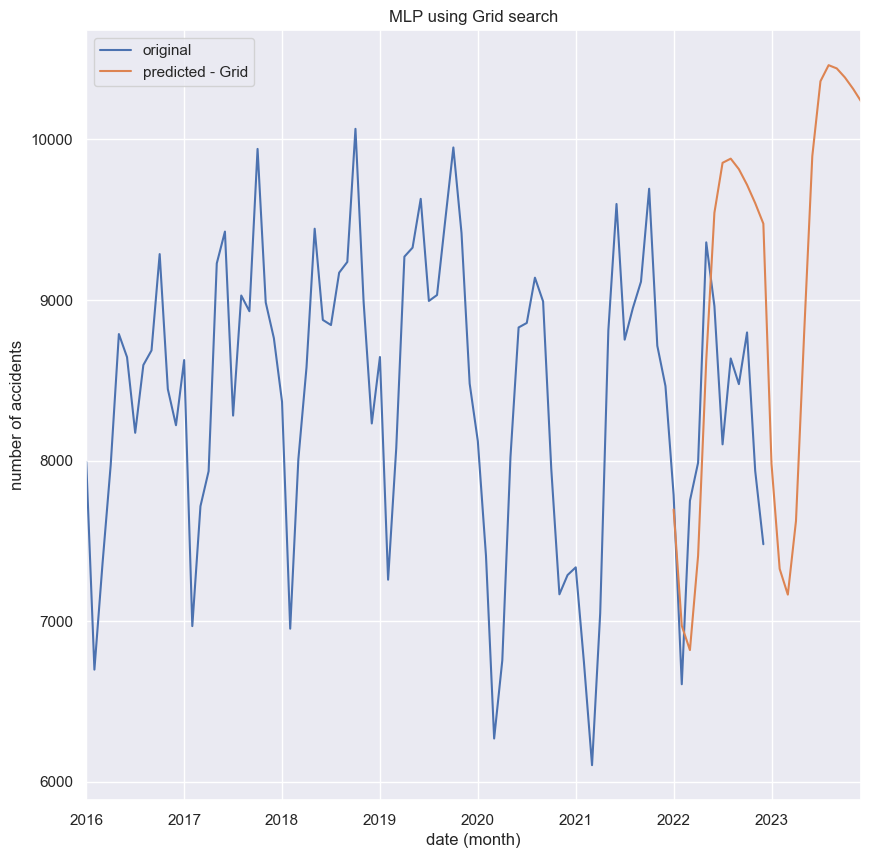

In [137]:
# plot predicted values from MLP model with grid search cv
predict_df['predicted - Grid'] = [None] * (len(predict_df) - 12 - months_to_predict) + list(predictions_unscaled['y'])
predict_df[['original', 'predicted - Grid']].plot()
plt.title("MLP using Grid search")
plt.xlabel("date (month)")
plt.ylabel("number of accidents")

In [138]:
monthly_predict_df['MLP + GA'] = list(predict_df['predicted - GA'])
monthly_predict_df['MLP + randomized'] = list(predict_df['predicted - Randomized'])
monthly_predict_df['MLP + grid'] = list(predict_df['predicted - Grid'])

monthly_predict_df

original      Prophet        arima          svr      xgboost  \
ds                                                                         
2016-01-01    7992.0          NaN          NaN          NaN          NaN   
2016-02-01    6698.0          NaN          NaN          NaN          NaN   
2016-03-01    7362.0          NaN          NaN          NaN          NaN   
2016-04-01    7974.0          NaN          NaN          NaN          NaN   
2016-05-01    8788.0          NaN          NaN          NaN          NaN   
...              ...          ...          ...          ...          ...   
2023-08-01       NaN  7948.404339  8347.768376  8948.031802  8897.983398   
2023-09-01       NaN  8280.045116  8720.182490  8954.668597  8967.149414   
2023-10-01       NaN  9124.274181  8824.095956  8889.665411  9497.236328   
2023-11-01       NaN  8294.161079  8316.773308  8715.999849  8475.584961   
2023-12-01       NaN  7279.427698  8067.838726  8408.677653  8143.119141   

               catboost          rnn         lstm  random forest + GA  \
ds                                                                      
2016-01-01          NaN          NaN          NaN                 NaN   
2016-02-01          NaN          NaN          NaN                 NaN   
2016-03-01          NaN          NaN          NaN                 NaN   
2016-04-01          NaN          NaN          NaN                 NaN   
2016-05-01          NaN          NaN          NaN                 NaN   
...                 ...          ...          ...                 ...   
2023-08-01  8947.191384  8838.750502  9093.315350              8843.0   
2023-09-01  8971.107381  8894.291314  8815.979549              8843.0   
2023-10-01  9354.696706  8898.400951  8687.664519              8843.0   
2023-11-01  8539.760655  8700.910411  8944.312531              8843.0   
2023-12-01  8159.440253  8731.407426  8631.491365              8347.5   

            random forest + randomized  random forest + grid     MLP + GA  \
ds                                                                          
2016-01-01                         NaN                   NaN          NaN   
2016-02-01                         NaN                   NaN          NaN   
2016-03-01                         NaN                   NaN          NaN   
2016-04-01                         NaN                   NaN          NaN   
2016-05-01                         NaN                   NaN          NaN   
...                                ...                   ...          ...   
2023-08-01                    8992.625           9118.519167  8710.009983   
2023-09-01                    8996.925           9124.421667  8793.048631   
2023-10-01                    8841.670           9235.615000  8873.380333   
2023-11-01                    8768.455           8369.187500  8950.765809   
2023-12-01                    8393.070           8312.337500  9025.005965   

            MLP + randomized    MLP + grid  
ds                                          
2016-01-01               NaN           NaN  
2016-02-01               NaN           NaN  
2016-03-01               NaN           NaN  
2016-04-01               NaN           NaN  
2016-05-01               NaN           NaN  
...                      ...           ...  
2023-08-01       8400.641421  10462.474296  
2023-09-01       8376.366737  10442.206732  
2023-10-01       8275.171738  10385.827027  
2023-11-01       8157.178373  10315.370186  
2023-12-01       8032.138113  10235.424428  

[96 rows x 14 columns]

In [139]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

In [163]:
# num_nodes = len(monthly_count)
# edges = [(i, i + 1) for i in range(num_nodes - 1)]
# x = torch.tensor(monthly_count['y'], dtype=torch.float).view(-1, 1)  # Node features
# edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()  # Edge indices
# data = Data(x=x, edge_index=edge_index)

# data

In [143]:
from autots import AutoTS

In [145]:
model = AutoTS(forecast_length=months_to_predict)
model = model.fit(monthly_count_train, date_col='ds', value_col='y', id_col=None)

Inferred frequency is: MS
Model Number: 1 with model ARIMA in generation 0 of 10
Model Number: 2 with model AverageValueNaive in generation 0 of 10
Model Number: 3 with model AverageValueNaive in generation 0 of 10
Model Number: 4 with model AverageValueNaive in generation 0 of 10
Model Number: 5 with model DatepartRegression in generation 0 of 10
Model Number: 6 with model DatepartRegression in generation 0 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 7 with model DatepartRegression in generation 0 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 8 with model DatepartRegression in generation 0 of 10
Epoch 1/50
2/2 [==============================] - 25s 42ms/step - loss: 0.3540
Epoch 2/50
2/2 [==============================] - 0s 44ms/step - loss: 0.3468
Epoch 3/50
2/2 [==============================] - 0s 49ms/step - loss: 0.3386
Epoch 4/50
2/2 [==============================] - 0s 51ms/step - loss: 0.3386
Epoch 5/50
2/2 [==============================] - 0s 37ms/step - loss: 0.3336
Epoch 6/50
2/2 [==============================] - 0s 63ms/step - loss: 0.3300
Epoch 7/50
2/2 [==============================] - 0s 40ms/step - loss: 0.3302
Epoch 8/50
2/2 [==============================] - 0s 24ms/step - loss: 0.3192
Epoch 9/50
2/2 [==============================] - 0s 66ms/step - loss: 0.3211
Epoch 10/50
2/2 [==============================] - 0s 46ms/step - loss: 0.3149
Epoch 11/50
2/2 [==============================] - 0s 33ms/step - loss: 0.3123
Epoch 12/50
2/2 [==============================] - 0s 69ms/step - loss:

23:07:28 - cmdstanpy - INFO - Chain [1] start processing
23:07:29 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 37 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue.') in model 37 in generation 0: GluonTS
Model Number: 38 with model MultivariateRegression in generation 0 of 10
Model Number: 39 with model MultivariateRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 39 in generation 0: MultivariateRegression
Model Number: 40 with model DatepartRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 40 in generation 0: DatepartRegression
Model Number: 41 with model SeasonalNaive in generation 0 of 10
Model Number: 42 with model DatepartRegression in generation 0 of 10
Model Number: 43 with model UnobservedComponents in generation 0 of 10
Model Number: 44 with model UnobservedComponents in generation 0 of 10
Model

23:07:39 - cmdstanpy - INFO - Chain [1] start processing
23:08:55 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 56 with model SeasonalNaive in generation 0 of 10
Model Number: 57 with model DatepartRegression in generation 0 of 10
Model Number: 58 with model NVAR in generation 0 of 10
Model Number: 59 with model Theta in generation 0 of 10
Model Number: 60 with model UnivariateRegression in generation 0 of 10
Template Eval Error: ValueError('Input X contains NaN.\nDecisionTreeRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values') in mo

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: invalid value encountered in multiply
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


23:08:58 - cmdstanpy - INFO - Chain [1] start processing
23:08:59 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 70 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue.') in model 70 in generation 0: GluonTS
Model Number: 71 with model UnobservedComponents in generation 0 of 10
Model Number: 72 with model VAR in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 72 in generation 0: VAR
Model Number: 73 with model VECM in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VECM') in model 73 in generation 0: VECM
Model Number: 74 with model ARIMA in generation 0 of 10
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 74 in generation 0: ARIMA
Model Number: 75 with model WindowRegression in generation 0 of 10
Model Number: 76 with model DatepartRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 76

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'rolling_mean_24', 'transformations': {'0': 'ClipOutliers', '1': 'Detrend', '2': 'cffilter', '3': 'AlignLastValue'}, 'transformation_params': {'0': {'method': 'clip', 'std_threshold': 5, 'fillna': None}, '1': {'model': 'Linear', 'phi': 1, 'window': None, 'transform_dict': None}, '2': {}, '3': {'rows': 1, 'lag': 1, 'method': 'multiplicative', 'strength': 1.0, 'first_value_only': False}}}. fail_on_forecast_nan=True") in model 106 in generation 0: ETS
Model Number: 107 with model UnobservedComponents in generation 0 of 10
Model Number: 108 with model NVAR in generation 0 of 10
Model Number: 109 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue.') in model 109 in generation 0: GluonTS
Model Number: 110 with model LastValueNaive in generation 0 of 10
Model Number: 111 with model D

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 113 with model VAR in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 113 in generation 0: VAR
Model Number: 114 with model ETS in generation 0 of 10
Model Number: 115 with model ETS in generation 0 of 10
Model Number: 116 with model UnobservedComponents in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 116 in generation 0: UnobservedComponents
Model Number: 117 with model ETS in generation 0 of 10
ETS error ValueError('Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.')
ETS failed on y with ValueError('Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.')
Model Number: 118 with model SeasonalNaive in generation 0 of 10
Model Number: 119 with model ARIMA in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but future_r

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.644e-01, tolerance: 3.462e-05
  model = cd_fast.enet_coordinate_descent(


Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 139 in generation 0: ETS
Model Number: 140 with model ConstantNaive in generation 0 of 10
Model Number: 141 with model MultivariateRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 141 in generation 0: MultivariateRegression
Model Number: 142 with model VAR in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 142 in generation 0: VAR
Model Number: 143 with model NVAR in generation 0 of 10
Model Number: 144 with model SeasonalNaive in generation 0 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 144 in generation 0: SeasonalNaive
Model Number: 145 with model LastValueNaive in generation 0 of 10
Model Number: 146 with model LastValueNaive in generation 0 of 10
Model Number: 147 with model FBProphet in generation 0 of 10
No anomalie

23:09:11 - cmdstanpy - INFO - Chain [1] start processing
23:09:11 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 148 with model LastValueNaive in generation 0 of 10
Model Number: 149 with model SeasonalNaive in generation 0 of 10
Model Number: 150 with model NVAR in generation 0 of 10
Model Number: 151 with model MultivariateRegression in generation 0 of 10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Template Eval Error: LightGBMError('[poisson]: at least one target label is negative') in model 151 in generation 0: MultivariateRegression
Model Number: 152 with model VECM in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VECM') in model 152 in generation 0: VECM
Model Number: 153 with model NVAR in generation 0 of 10
Model Number: 154 with model AverageValueNaive in generation 0 of 10
Model Number: 155 with model ARCH in generation 0 of 10
M

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 174 with model Theta in generation 0 of 10
Model Number: 175 with model ARDL in generation 0 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 175 in generation 0: ARDL
Model Number: 176 with model DatepartRegression in generation 0 of 10
Model Number: 177 with model UnobservedComponents in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 177 in generation 0: UnobservedComponents
Model Number: 178 with model UnobservedComponents in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 178 in generation 0: UnobservedComponents
Model Number: 179 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue.') in model 179 in generation 0: GluonTS
Model Number: 180 with model GLS in generation 0 o

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 195 in generation 1: DatepartRegression
Model Number: 196 with model Theta in generation 1 of 10
Model Number: 197 with model LastValueNaive in generation 1 of 10
Model Number: 198 with model UnivariateMotif in generation 1 of 10
Model Number: 199 with model MultivariateMotif in generation 1 of 10
Model Number: 200 with model GLS in generation 1 of 10
Model Number: 201 with model Theta in generation 1 of 10
Model Number: 202 with model ARDL in generation 1 of 10
Model Number: 203 with model Theta in generation 1 of 10
Model Number: 204 with model MultivariateRegression in generation 1 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 204 in generation 1: MultivariateRegression
Model Number: 205 with model GLM in generation 1 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected i

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:516: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1342: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1211: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)


Model Number: 207 with model MultivariateRegression in generation 1 of 10
Model Number: 208 with model GLM in generation 1 of 10
Model Number: 209 with model NVAR in generation 1 of 10
Model Number: 210 with model ARDL in generation 1 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 210 in generation 1: ARDL
Model Number: 211 with model ConstantNaive in generation 1 of 10
Model Number: 212 with model Theta in generation 1 of 10
HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.78051e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 213 with model MultivariateMotif in generation 1 of 10
Model Number: 214 with model ETS in generation 1 of 10
Model Number: 215 with model SectionalMotif in generation 1 of 10
Model Number: 216 with model GLM in generation 1 of 10
HolidayTransformer: no anomalies detected.
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 216 in generation 1: GLM
Model Number: 217 with model Theta in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:426: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Model Number: 218 with model MultivariateMotif in generation 1 of 10
Model Number: 219 with model GLM in generation 1 of 10
Model Number: 220 with model FBProphet in generation 1 of 10

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "



No anomalies detected.


23:09:47 - cmdstanpy - INFO - Chain [1] start processing
23:09:48 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 221 with model UnobservedComponents in generation 1 of 10
Model Number: 222 with model ConstantNaive in generation 1 of 10
Model Number: 223 with model LastValueNaive in generation 1 of 10
Model Number: 224 with model SectionalMotif in generation 1 of 10
Model Number: 225 with model SectionalMotif in generation 1 of 10
Template Eval Error: ValueError('zero-size array to reduction operation fmax which has no identity') in model 225 in generation 1: SectionalMotif
Model Number: 226 with model UnivariateRegression in generation 1 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 226 in generation 1: UnivariateRegression
Model Number: 227 with model UnivariateRegression in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Model Number: 228 with model WindowRegression in generation 1 of 10
Model Number: 229 with model DatepartRegression in generation 1 of 10
Template Eval Error: Exception('Transformer LocalLinearTrend failed on fit') in model 229 in generation 1: DatepartRegression
Model Number: 230 with model UnobservedComponents in generation 1 of 10
Model Number: 231 with model WindowRegression in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 232 with model Theta in generation 1 of 10
Model Number: 233 with model SeasonalNaive in generation 1 of 10
Model Number: 234 with model ETS in generation 1 of 10
Model Number: 235 with model ConstantNaive in generation 1 of 10
Model Number: 236 with model DatepartRegression in generation 1 of 10
Model Number: 237 with model ARCH in generation 1 of 10
Model Number: 238 with model DatepartRegression in generation 1 of 10
Model Number: 239 with model NVAR in generation 1 of 10
Model Number: 240 with model LastValueNaive in generation 1 of 10
Model Number: 241 with model DatepartRegression in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.592e-01, tolerance: 4.337e-05
  model = cd_fast.enet_coordinate_descent(


Model Number: 242 with model SectionalMotif in generation 1 of 10
Model Number: 243 with model UnobservedComponents in generation 1 of 10
Model Number: 244 with model SeasonalNaive in generation 1 of 10
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 244 in generation 1: SeasonalNaive
Model Number: 245 with model MultivariateMotif in generation 1 of 10
Model Number: 246 with model ETS in generation 1 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 247 with model DatepartRegression in generation 1 of 10
Model Number: 248 with model GLS in generation 1 of 10
Model Number: 249 with model ARDL in generation 1 of 10
Model Number: 250 with model UnobservedComponents in generation 1 of 10
Model Number: 251 with model LastValueNaive in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:583: UserWarning: Ignoring n_components with whiten=False.
  warnings.warn("Ignoring n_components with whiten=False.")
C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Template Eval Error: PerfectSeparationError('Perfect separation detected, results not available') in model 269 in generation 1: GLM
Model Number: 270 with model SectionalMotif in generation 1 of 10
Template Eval Error: ValueError('kth(=20) out of bounds (20)') in model 270 in generation 1: SectionalMotif
Model Number: 271 with model MultivariateMotif in generation 1 of 10
Model Number: 272 with model WindowRegression in generation 1 of 10
Model Number: 273 with model UnobservedComponents in generation 1 of 10
Model Number: 274 with model Theta in generation 1 of 10
Model Number: 275 with model SeasonalNaive in generation 1 of 10
Model Number: 276 with model ARDL in generation 1 of 10
Model Number: 277 with model ETS in generation 1 of 10
ETS error ValueError('Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.')
ETS failed on y with ValueError('Cannot compute initial seasonals using heuristic method with less than two full season

23:10:06 - cmdstanpy - INFO - Chain [1] start processing
23:10:06 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 285 with model MultivariateRegression in generation 1 of 10
Model Number: 286 with model AverageValueNaive in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 287 with model MultivariateMotif in generation 1 of 10
Model Number: 288 with model MultivariateMotif in generation 1 of 10
HolidayTransformer: no anomalies detected.
Model Number: 289 with model SectionalMotif in generation 1 of 10
Model Number: 290 with model ETS in generation 1 of 10
Model Number: 291 with model WindowRegression in generation 1 of 10
Model Number: 292 with model GLS in generation 1 of 10
Model Number: 293 with model SeasonalNaive in generation 1 of 10
Model Number: 294 with model DatepartRegression in generation 1 of 10
Model Number: 295 with model MetricMotif in generation 1 of 10
Model Number: 296 with model ConstantNaive in generation 1 of 10
Model Number: 297 with model ARCH in generation 1 of 10
Model Number: 298 with model SeasonalNaive in generation 1 of 10
Model Number: 299 with model UnobservedComponents in generation 1 of 10
Model Number: 300 with model SectionalMotif in generation 1 of 10
Model Number: 301 with model SeasonalNaive in generat

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 316 with model ARCH in generation 2 of 10
Model Number: 317 with model DatepartRegression in generation 2 of 10
Model Number: 318 with model ARDL in generation 2 of 10
Model Number: 319 with model MultivariateMotif in generation 2 of 10
Model Number: 320 with model GLM in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 321 with model DatepartRegression in generation 2 of 10
Model Number: 322 with model DatepartRegression in generation 2 of 10
Model Number: 323 with model FBProphet in generation 2 of 10


23:10:33 - cmdstanpy - INFO - Chain [1] start processing
23:10:34 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 324 with model ARIMA in generation 2 of 10
Model Number: 325 with model DatepartRegression in generation 2 of 10
Model Number: 326 with model UnivariateRegression in generation 2 of 10
Model Number: 327 with model GLM in generation 2 of 10
Model Number: 328 with model DatepartRegression in generation 2 of 10
Model Number: 329 with model MultivariateMotif in generation 2 of 10
Model Number: 330 with model ARDL in generation 2 of 10
Model Number: 331 with model UnivariateRegression in generation 2 of 10
Model Number: 332 with model UnobservedComponents in generation 2 of 10
Model Number: 333 with model Theta in generation 2 of 10
Model Number: 334 with model Theta in generation 2 of 10
Model Number: 335 with model ConstantNaive in generation 2 of 10
Model Number: 336 with model SeasonalNaive in generation 2 of 10
Model Number: 337 with model NVAR in generation 2 of 10
Model Number: 338 with model GLS in generation 2 of 10
Model Number: 339 with model UnobservedComponents in

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 348 with model Theta in generation 2 of 10
Model Number: 349 with model GLS in generation 2 of 10
Model Number: 350 with model GLM in generation 2 of 10
Model Number: 351 with model NVAR in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 352 with model Theta in generation 2 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 352 in generation 2: Theta
Model Number: 353 with model DatepartRegression in generation 2 of 10
HolidayTransformer: no anomalies detected.
Epoch 1/50
3/3 [==============================] - 22s 2s/step - loss: 2798325.2500 - val_loss: 1313150.7500
Epoch 2/50
3/3 [==============================] - 2s 675ms/step - loss: 2795124.7500 - val_loss: 1312808.0000
Epoch 3/50
3/3 [==============================] - 2s 666ms/step - loss: 2794208.7500 - val_loss: 1312461.8750
Epoch 4/50
3/3 [==============================] - 2s 664ms/step - loss: 2789855.5000 - val_loss: 1312120.6250
Epoch 5/50
3/3 [==============================] - 2s 580ms/step - loss: 2788411.0000 - val_loss: 1311773.3750
Epoch 6/50
3/3 [==============================] - 2s 657ms/step - loss: 2786795.0000 - val_loss: 1311430.3750
Epoch 7/50
3/3 [==============================] - 2s 600ms/ste

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 365 with model ARIMA in generation 2 of 10
Model Number: 366 with model SectionalMotif in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 367 with model SeasonalNaive in generation 2 of 10
Model Number: 368 with model ARDL in generation 2 of 10
Model Number: 369 with model GLM in generation 2 of 10
Model Number: 370 with model MultivariateMotif in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 371 with model DatepartRegression in generation 2 of 10
Model Number: 372 with model FBProphet in generation 2 of 10


23:12:46 - cmdstanpy - INFO - Chain [1] start processing
23:12:47 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 373 with model ARDL in generation 2 of 10
Model Number: 374 with model SeasonalNaive in generation 2 of 10
Model Number: 375 with model LastValueNaive in generation 2 of 10
Model Number: 376 with model SeasonalNaive in generation 2 of 10
Model Number: 377 with model AverageValueNaive in generation 2 of 10
Model Number: 378 with model WindowRegression in generation 2 of 10
Model Number: 379 with model SectionalMotif in generation 2 of 10
Model Number: 380 with model MultivariateRegression in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 381 with model WindowRegression in generation 2 of 10
Model Number: 382 with model MultivariateRegression in generation 2 of 10
Model Number: 383 with model NVAR in generation 2 of 10
Model Number: 384 with model MultivariateRegression in generation 2 of 10
Model Number: 385 with model ConstantNaive in generation 2 of 10
Model Number: 386 with model ARDL in generation 2 of 10
Model Number: 387 with model SeasonalNaive in generation 2 of 10
Model Number: 388 with model NVAR in generation 2 of 10
Model Number: 389 with model ARDL in generation 2 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 389 in generation 2: ARDL
Model Number: 390 with model SectionalMotif in generation 2 of 10
Model Number: 391 with model UnobservedComponents in generation 2 of 10
Model Number: 392 with model Theta in generation 2 of 10
Model Number: 393 with model GLS in generation 2 of 10
Model Number: 394 with model AverageValueNaive in gen

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.071e+03, tolerance: 1.874e+02
  model = cd_fast.enet_coordinate_descent(
23:13:31 - cmdstanpy - INFO - Chain [1] start processing
23:13:31 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 448 with model MetricMotif in generation 3 of 10
HolidayTransformer: no anomalies detected.
Model Number: 449 with model MetricMotif in generation 3 of 10
Model Number: 450 with model GLS in generation 3 of 10
Model Number: 451 with model LastValueNaive in generation 3 of 10
Model Number: 452 with model ETS in generation 3 of 10
ETS error ValueError('Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.')
ETS failed on y with ValueError('Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.')
Model Number: 453 with model UnobservedComponents in generation 3 of 10
Model Number: 454 with model GLS in generation 3 of 10
Model Number: 455 with model LastValueNaive in generation 3 of 10
Model Number: 456 with model DatepartRegression in generation 3 of 10
Model Number: 457 with model WindowRegression in generation 3 of 10
Template Eval Error: ValueError("regression_typ

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.683e+00, tolerance: 4.838e-04
  model = cd_fast.enet_coordinate_descent(


Model Number: 459 with model ETS in generation 3 of 10
Model Number: 460 with model GLS in generation 3 of 10
Model Number: 461 with model GLM in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 462 with model DatepartRegression in generation 3 of 10
Epoch 1/50
2/2 [==============================] - 14s 21ms/step - loss: nan
Epoch 2/50
2/2 [==============================] - 0s 25ms/step - loss: 0.9249
Epoch 3/50
2/2 [==============================] - 0s 21ms/step - loss: 0.8763
Epoch 4/50
2/2 [==============================] - 0s 24ms/step - loss: 0.8533
Epoch 5/50
2/2 [==============================] - 0s 19ms/step - loss: 0.8326
Epoch 6/50
2/2 [==============================] - 0s 14ms/step - loss: 0.8300
Epoch 7/50
2/2 [==============================] - 0s 18ms/step - loss: 0.8307
Epoch 8/50
2/2 [==============================] - 0s 15ms/step - loss: 0.8254
Epoch 9/50
2/2 [==============================] - 0s 19ms/step - loss: 0.8221
Epoch 10/50
2/2 [==============================] - 0s 26ms/step - loss: 0.8182
Epoch 11/50
2/2 [==============================] - 0s 18ms/step - loss: 0.8218
Epoch 12/50
2/2 [==============================] - 0s 30ms/step - loss: 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 466 with model Theta in generation 3 of 10
Model Number: 467 with model WindowRegression in generation 3 of 10
Model Number: 468 with model ConstantNaive in generation 3 of 10
Model Number: 469 with model Theta in generation 3 of 10
Model Number: 470 with model ETS in generation 3 of 10
Model Number: 471 with model ETS in generation 3 of 10
Model Number: 472 with model DatepartRegression in generation 3 of 10
Model Number: 473 with model SectionalMotif in generation 3 of 10
Model Number: 474 with model UnivariateMotif in generation 3 of 10
Model Number: 475 with model ARDL in generation 3 of 10
Model Number: 476 with model MultivariateRegression in generation 3 of 10
Model Number: 477 with model LastValueNaive in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.78051e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 478 with model Theta in generation 3 of 10
Model Number: 479 with model AverageValueNaive in generation 3 of 10
Model Number: 480 with model DatepartRegression in generation 3 of 10
Model Number: 481 with model ConstantNaive in generation 3 of 10
Model Number: 482 with model MultivariateMotif in generation 3 of 10
Model Number: 483 with model GLM in generation 3 of 10
Model Number: 484 with model NVAR in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 485 with model LastValueNaive in generation 3 of 10
Model Number: 486 with model AverageValueNaive in generation 3 of 10
Model Number: 487 with model LastValueNaive in generation 3 of 10
HolidayTransformer: no anomalies detected.
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 487 in generation 3: LastValueNaive
Model Number: 488 with model ARCH in generation 3 of 10
Model Number: 489 with model ConstantNaive in generation 3 of 10
Model Number: 490 with model MultivariateRegression in generation 3 of 10
Model Number: 491 with model ARDL in generation 3 of 10
Model Number: 492 with model NVAR in generation 3 of 10
Model Number: 493 with model GLM in generation 3 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 493 in generation 3: GLM
Model Number: 494 with model Theta in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:318: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:740: RuntimeWarning: invalid value encountered in divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:804: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid / self.family.v

Model Number: 495 with model UnobservedComponents in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 496 with model MetricMotif in generation 3 of 10
Model Number: 497 with model MultivariateMotif in generation 3 of 10
Template Eval Error: ValueError('kth(=100) out of bounds (39)') in model 497 in generation 3: MultivariateMotif
Model Number: 498 with model GLM in generation 3 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 498 in generation 3: GLM
Model Number: 499 with model SeasonalNaive in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:516: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1342: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1211: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)


Model Number: 500 with model GLM in generation 3 of 10
Model Number: 501 with model MetricMotif in generation 3 of 10
Model Number: 502 with model DatepartRegression in generation 3 of 10
Model Number: 503 with model SectionalMotif in generation 3 of 10
Model Number: 504 with model GLM in generation 3 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 504 in generation 3: GLM
Model Number: 505 with model SeasonalNaive in generation 3 of 10
Model Number: 506 with model NVAR in generation 3 of 10
Model Number: 507 with model SeasonalNaive in generation 3 of 10
Model Number: 508 with model ARIMA in generation 3 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 508 in generation 3: ARIMA
Model Number: 509 with model MultivariateMotif in generation 3 of 10
Model Number: 510 with model ETS in generation 3 of 10
Model Number: 511 with model GLM in generation 3 of 10
Model Number: 512 wi

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)



Model Number: 534 with model GLM in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 535 with model MultivariateRegression in generation 3 of 10
Model Number: 536 with model MultivariateRegression in generation 3 of 10
Model Number: 537 with model ETS in generation 3 of 10
Model Number: 538 with model NVAR in generation 3 of 10
Model Number: 539 with model UnivariateMotif in generation 3 of 10
Model Number: 540 with model Theta in generation 3 of 10
Model Number: 541 with model MultivariateRegression in generation 3 of 10
Model Number: 542 with model SectionalMotif in generation 3 of 10
Model Number: 543 with model WindowRegression in generation 3 of 10
Model Number: 544 with model SeasonalNaive in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 545 with model SeasonalNaive in generation 3 of 10
Model Number: 546 with model MultivariateMotif in generation 3 of 10
Model Number: 547 with model ConstantNaive in generation 3 of 10
Model Number: 548 with model Theta in generation 3 of 10
Model Number: 549 with model UnivariateRegression in generation 3 of 10
Model Number: 550 with model SectionalMotif in generation 3 of 10
Model Number: 551 with model ETS in generation 3 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 552 with model SeasonalNaive in generation 3 of 10
Model Number: 553 with model DatepartRegression in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 554 with model MetricMotif in generation 3 of 10
Model Number: 555 with model DatepartRegression in generation 3 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 555 in generation 3: DatepartRegression
Model Number: 556 with model FBProphet in generation 3 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 556 in generation 3: FBProphet
Model Number: 557 with model UnobservedComponents in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.058e+06, tolerance: 1.368e+03
  model = cd_fast.enet_coordinate_descent(


Model Number: 558 with model Theta in generation 3 of 10
Model Number: 559 with model SectionalMotif in generation 3 of 10
Template Eval Error: Exception('Transformer FastICA failed on fit') in model 559 in generation 3: SectionalMotif
Model Number: 560 with model SeasonalNaive in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 561 with model MultivariateMotif in generation 3 of 10
New Generation: 4 of 10
Model Number: 562 with model MetricMotif in generation 4 of 10
Model Number: 563 with model GLM in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 564 with model AverageValueNaive in generation 4 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 564 in generation 4: AverageValueNaive
Model Number: 565 with model ConstantNaive in generation 4 of 10
Model Number: 566 with model ETS in generation 4 of 10
Model Number: 567 with model UnivariateMotif in generation 4 of 10
Model Number: 568 with model NVAR in generation 4 of 10
Model Number: 569 with model GLM in generation 4 of 10
Model Number: 570 with model GLS in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 571 with model UnivariateRegression in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 571 in generation 4: UnivariateRegression
Model Number: 572 with model GLM in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 573 with model UnivariateRegression in generation 4 of 10
Model Number: 574 with model Theta in generation 4 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 574 in generation 4: Theta
Model Number: 575 with model SectionalMotif in generation 4 of 10
Model Number: 576 with model Theta in generation 4 of 10
Model Number: 577 with model ETS in generation 4 of 10
Model Number: 578 with model GLM in generation 4 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 578 in generation 4: GLM
Model Number: 579 with model NVAR in generation 4 of 10
Model Number: 580 with model ARIMA in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:516: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1342: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1211: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)


Model Number: 581 with model DatepartRegression in generation 4 of 10
Model Number: 582 with model ARCH in generation 4 of 10
Model Number: 583 with model MultivariateRegression in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 583 in generation 4: MultivariateRegression
Model Number: 584 with model MetricMotif in generation 4 of 10
Model Number: 585 with model MetricMotif in generation 4 of 10
Model Number: 586 with model UnobservedComponents in generation 4 of 10
Model Number: 587 with model UnobservedComponents in generation 4 of 10
Model Number: 588 with model ARDL in generation 4 of 10
Model Number: 589 with model DatepartRegression in generation 4 of 10
Model Number: 590 with model NVAR in generation 4 of 10
Model Number: 591 with model UnobservedComponents in generation 4 of 10
Model Number: 592 with model ARDL in generation 4 of 10
Model Number: 593 with model MultivariateRegression in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Model Number: 597 with model ETS in generation 4 of 10
Model Number: 598 with model WindowRegression in generation 4 of 10
Model Number: 599 with model MetricMotif in generation 4 of 10
Model Number: 600 with model NVAR in generation 4 of 10
Model Number: 601 with model ARIMA in generation 4 of 10
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 601 in generation 4: ARIMA
Model Number: 602 with model ETS in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 603 with model MetricMotif in generation 4 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 603 in generation 4: MetricMotif
Model Number: 604 with model ARCH in generation 4 of 10
Model Number: 605 with model DatepartRegression in generation 4 of 10
Model Number: 606 with model ARIMA in generation 4 of 10
Model Number: 607 with model UnobservedComponents in generation 4 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 607 in generation 4: UnobservedComponents
Model Number: 608 with model SeasonalNaive in generation 4 of 10
Model Number: 609 with model SeasonalNaive in generation 4 of 10
Model Number: 610 with model SeasonalNaive in generation 4 of 10
Model Number: 611 with model SectionalMotif in generation 4 of 10
Model Number: 612 with model DatepartRegression in generation 4 of 10
Model Number: 613 with model MultivariateMotif in generation 4 of 10
Model Number: 614 with model ARIMA in generat

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 658 with model SeasonalNaive in generation 4 of 10
Model Number: 659 with model MetricMotif in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Model Number: 660 with model SeasonalNaive in generation 4 of 10
Model Number: 661 with model SeasonalNaive in generation 4 of 10
Model Number: 662 with model GLM in generation 4 of 10
Model Number: 663 with model ARDL in generation 4 of 10

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)



Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 663 in generation 4: ARDL
Model Number: 664 with model DatepartRegression in generation 4 of 10
Model Number: 665 with model ARDL in generation 4 of 10
Model Number: 666 with model MetricMotif in generation 4 of 10
Template Eval Error: ValueError('window shape cannot be larger than input array shape') in model 666 in generation 4: MetricMotif
Model Number: 667 with model Theta in generation 4 of 10
Model Number: 668 with model MultivariateRegression in generation 4 of 10
Model Number: 669 with model Theta in generation 4 of 10
Model Number: 670 with model GLM in generation 4 of 10
Model Number: 671 with model ConstantNaive in generation 4 of 10
Model Number: 672 with model ConstantNaive in generation 4 of 10
Model Number: 673 with model MultivariateRegression in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 673 

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 676 with model MetricMotif in generation 4 of 10
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 676 in generation 4: MetricMotif
Model Number: 677 with model UnivariateRegression in generation 4 of 10
Model Number: 678 with model ARDL in generation 4 of 10
Model Number: 679 with model ARDL in generation 4 of 10
Model Number: 680 with model GLM in generation 4 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 680 in generation 4: GLM
Model Number: 681 with model UnivariateMotif in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:318: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:740: RuntimeWarning: invalid value encountered in divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:804: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid / self.family.v

Model Number: 682 with model Theta in generation 4 of 10
Model Number: 683 with model UnivariateMotif in generation 4 of 10
Model Number: 684 with model WindowRegression in generation 4 of 10
Model Number: 685 with model NVAR in generation 4 of 10
Model Number: 686 with model ConstantNaive in generation 4 of 10
New Generation: 5 of 10
Model Number: 687 with model UnobservedComponents in generation 5 of 10
Model Number: 688 with model SectionalMotif in generation 5 of 10
Model Number: 689 with model GLM in generation 5 of 10
Model Number: 690 with model UnobservedComponents in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 691 with model MultivariateRegression in generation 5 of 10
Model Number: 692 with model SeasonalNaive in generation 5 of 10
Model Number: 693 with model MultivariateMotif in generation 5 of 10
Model Number: 694 with model DatepartRegression in generation 5 of 10
Model Number: 695 with model NVAR in generation 5 of 10
Model Number: 696 with model ConstantNaive in generation 5 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 696 in generation 5: ConstantNaive
Model Number: 697 with model ARDL in generation 5 of 10
Template Eval Error: Exception('Transformer DatepartRegression failed on fit') in model 697 in generation 5: ARDL
Model Number: 698 with model WindowRegression in generation 5 of 10
Model Number: 699 with model UnobservedComponents in generation 5 of 10
Model Number: 700 with model ETS in generation 5 of 10
Model Number: 701 with model GLM in generation 5 of 10
Model Number: 702 with model ARIMA in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 703 with model ARDL in generation 5 of 10
Model Number: 704 with model ConstantNaive in generation 5 of 10
Model Number: 705 with model ETS in generation 5 of 10
Model Number: 706 with model ARIMA in generation 5 of 10
Model Number: 707 with model SectionalMotif in generation 5 of 10
Model Number: 708 with model MultivariateRegression in generation 5 of 10
Model Number: 709 with model Theta in generation 5 of 10
Model Number: 710 with model SeasonalNaive in generation 5 of 10
Model Number: 711 with model GLS in generation 5 of 10
Model Number: 712 with model ConstantNaive in generation 5 of 10
Model Number: 713 with model UnivariateMotif in generation 5 of 10
Model Number: 714 with model ARIMA in generation 5 of 10
Model Number: 715 with model ARDL in generation 5 of 10
Model Number: 716 with model MetricMotif in generation 5 of 10
Model Number: 717 with model MultivariateMotif in generation 5 of 10
Model Number: 718 with model DatepartRegression in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 718 in generation 5: DatepartRegression
Model Number: 719 with model ETS in generation 5 of 10
Model Number: 720 with model UnobservedComponents in generation 5 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 720 in generation 5: UnobservedComponents
Model Number: 721 with model ETS in generation 5 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 722 with model ARIMA in generation 5 of 10
Model Number: 723 with model NVAR in generation 5 of 10
Model Number: 724 with model ARCH in generation 5 of 10
Model Number: 725 with model DatepartRegression in generation 5 of 10
Model Number: 726 with model SeasonalNaive in generation 5 of 10
Model Number: 727 with model UnivariateRegression in generation 5 of 10
Model Number: 728 with model SectionalMot

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 734 with model NVAR in generation 5 of 10
Model Number: 735 with model GLM in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:318: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:740: RuntimeWarning: invalid value encountered in divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:804: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid / self.family.v

Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 735 in generation 5: GLM
Model Number: 736 with model Theta in generation 5 of 10
HolidayTransformer: no anomalies detected.
Model Number: 737 with model MultivariateRegression in generation 5 of 10
Model Number: 738 with model GLS in generation 5 of 10
Model Number: 739 with model UnobservedComponents in generation 5 of 10
Model Number: 740 with model SeasonalNaive in generation 5 of 10
Model Number: 741 with model DatepartRegression in generation 5 of 10
Epoch 1/50
1/1 [==============================] - 18s 18s/step - loss: 65.9131
Epoch 2/50
1/1 [==============================] - 0s 72ms/step - loss: 42.0631
Epoch 3/50
1/1 [==============================] - 0s 42ms/step - loss: 25.4797
Epoch 4/50
1/1 [==============================] - 0s 41ms/step - loss: 11.9622
Epoch 5/50
1/1 [==============================] - 0s 57ms/step - loss: 2.3737
Epoch 6/50
1/1 [===============

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 743 with model ARDL in generation 5 of 10
Model Number: 744 with model UnivariateMotif in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 745 with model NVAR in generation 5 of 10
Model Number: 746 with model NVAR in generation 5 of 10
Model Number: 747 with model UnivariateMotif in generation 5 of 10
Model Number: 748 with model MultivariateMotif in generation 5 of 10
Model Number: 749 with model UnivariateRegression in generation 5 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 749 in generation 5: UnivariateRegression
Model Number: 750 with model AverageValueNaive in generation 5 of 10
Model Number: 751 with model ConstantNaive in generation 5 of 10
Model Number: 752 with model WindowRegression in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 753 with model GLM in generation 5 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 753 in generation 5: GLM


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:318: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:740: RuntimeWarning: invalid value encountered in divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:804: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid / self.family.v

Model Number: 754 with model UnivariateRegression in generation 5 of 10
Model Number: 755 with model WindowRegression in generation 5 of 10
Epoch 1/50
3/3 [==============================] - 20s 1s/step - loss: 0.9986 - val_loss: 1.3352
Epoch 2/50
3/3 [==============================] - 1s 379ms/step - loss: 0.9990 - val_loss: 1.3233
Epoch 3/50
3/3 [==============================] - 1s 316ms/step - loss: 0.9887 - val_loss: 1.3112
Epoch 4/50
3/3 [==============================] - 1s 339ms/step - loss: 0.9814 - val_loss: 1.2991
Epoch 5/50
3/3 [==============================] - 1s 340ms/step - loss: 0.9703 - val_loss: 1.2871
Epoch 6/50
3/3 [==============================] - 1s 333ms/step - loss: 0.9576 - val_loss: 1.2752
Epoch 7/50
3/3 [==============================] - 1s 353ms/step - loss: 0.9371 - val_loss: 1.2633
Epoch 8/50
3/3 [==============================] - 1s 330ms/step - loss: 0.9310 - val_loss: 1.2518
Epoch 9/50
3/3 [==============================] - 1s 330ms/step - loss: 0.9300

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:318: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:740: RuntimeWarning: invalid value encountered in divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:804: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid / self.family.v

Model Number: 765 with model MultivariateMotif in generation 5 of 10
Model Number: 766 with model GLM in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 767 with model MultivariateRegression in generation 5 of 10
Model Number: 768 with model MultivariateRegression in generation 5 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 768 in generation 5: MultivariateRegression
Model Number: 769 with model SectionalMotif in generation 5 of 10
Model Number: 770 with model GLS in generation 5 of 10
Model Number: 771 with model MetricMotif in generation 5 of 10
Model Number: 772 with model MultivariateRegression in generation 5 of 10
Model Number: 773 with model ARDL in generation 5 of 10
Model Number: 774 with model UnivariateMotif in generation 5 of 10
Model Number: 775 with model NVAR in generation 5 of 10
Model Number: 776 with model ARDL in generation 5 of 10
Model Number: 777 with model WindowRegression in generation 5 of 10
Template Eval Error: ValueError('Found array with 0 sample(s) (shape=(0, 0)) while a minimum of 1 is required by KNeighborsRegressor.') in model 

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:804: RuntimeWarning: overflow encountered in divide
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1211: RuntimeWarning: overflow encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True

Model Number: 807 with model ETS in generation 6 of 10
Model Number: 808 with model SeasonalNaive in generation 6 of 10
Model Number: 809 with model MultivariateMotif in generation 6 of 10
Model Number: 810 with model Theta in generation 6 of 10
Model Number: 811 with model MultivariateRegression in generation 6 of 10
Model Number: 812 with model UnobservedComponents in generation 6 of 10
Model Number: 813 with model MetricMotif in generation 6 of 10
Model Number: 814 with model MultivariateRegression in generation 6 of 10
Model Number: 815 with model Theta in generation 6 of 10
Model Number: 816 with model WindowRegression in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 817 with model DatepartRegression in generation 6 of 10
Model Number: 818 with model SectionalMotif in generation 6 of 10
Model Number: 819 with model ARDL in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.78051e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 820 with model ARDL in generation 6 of 10
Model Number: 821 with model Theta in generation 6 of 10
Model Number: 822 with model SectionalMotif in generation 6 of 10
Template Eval Error: ValueError('kth(=10) out of bounds (9)') in model 822 in generation 6: SectionalMotif
Model Number: 823 with model GLS in generation 6 of 10
Model Number: 824 with model SeasonalNaive in generation 6 of 10
Model Number: 825 with model MultivariateRegression in generation 6 of 10
Model Number: 826 with model SeasonalNaive in generation 6 of 10
Model Number: 827 with model DatepartRegression in generation 6 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 827 in generation 6: DatepartRegression
Model Number: 828 with model UnivariateMotif in generation 6 of 10
Model Number: 829 with model SeasonalNaive in generation 6 of 10
Model Number: 830 with model Theta in generation 6 of 10
Model Number: 831 with model SectionalMotif in generation 6 of 10
Model N

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Model Number: 842 with model ConstantNaive in generation 6 of 10
Model Number: 843 with model MetricMotif in generation 6 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 843 in generation 6: MetricMotif
Model Number: 844 with model UnobservedComponents in generation 6 of 10
Model Number: 845 with model MultivariateRegression in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Model Number: 846 with model Theta in generation 6 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 846 in generation 6: Theta
Model Number: 847 with model UnobservedComponents in generation 6 of 10
Model Number: 848 with model ARDL in generation 6 of 10
Model Number: 849 with model UnivariateMotif in generation 6 of 10
Model Number: 850 with model ARDL in generation 6 of 10
Template Eval Error: ValueError("ARDL series y failed with error ValueError('The number of regressors (58) including deterministics, lags of the endog, lags of the exogenous, and fixed regressors is larer than the sample available for estimation (56).') exog train             seasonalitycommonfourier_0  seasonalitycommonfourier_1  \\\nds                                                                   \n2016-01-01                    0.999963                    0.999852   \n2016-02-01                    0.865487                    0.498137   \n2016-03-01                 

Model Number: 851 with model UnivariateMotif in generation 6 of 10
Model Number: 852 with model ETS in generation 6 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Model Number: 853 with model Theta in generation 6 of 10
Model Number: 854 with model Theta in generation 6 of 10
Model Number: 855 with model MultivariateRegression in generation 6 of 10
Model Number: 856 with model GLS in generation 6 of 10
Model Number: 857 with model NVAR in generation 6 of 10
Model Number: 858 with model ARIMA in generation 6 of 10
Model Number: 859 with model DatepartRegression in generation 6 of 10
Model Number: 860 with model WindowRegression in generation 6 of 10
Template Eval Error: LightGBMError('[tweedie]: at least one target label is negative') in model 860 in generation 6: WindowRegression
Model Number: 861 with model GLS in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 862 with model SectionalMotif in generation 6 of 10
Model Number: 863 with model ARDL in generation 6 of 10
Model Number: 864 with model MetricMotif in generation 6 of 10
Model Number: 865 with model Theta in generation 6 of 10
Model Number: 866 with model DatepartRegression in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 866 in generation 6: DatepartRegression
Model Number: 867 with model ETS in generation 6 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 868 with model LastValueNaive in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 869 with model ARCH in generation 6 of 10
Model Number: 870 with model GLS in generation 6 of 10
Model Number: 871 with model GLS in generation 6 of 10
Model Number: 872 with model GLM in generation 6 of 10
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 872 in generation 6: GLM
Model Number: 873 with model NVAR in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 874 with model ETS in generation 6 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 875 with model NVAR in generation 6 of 10
Model Number: 876 with model ARIMA in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 876 in generation 6: ARIMA
Model Number: 877 with model NVAR in generation 6 of 10
Model Number: 878 with model NVAR in generation 6 of 10
Model Number: 879 with model ARIMA in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 879 in generation 6: ARIMA
Model Number: 880 with model DatepartRegression in generation 6 of 10
Model Number: 881 with model SeasonalNaive in generation 6 of 10
Model Number: 882 with model SeasonalNaive in generation 6 of 10
Model Number: 883 with model LastValueNaive in generation 6 of 10
Model Numb

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.78051e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


New Generation: 7 of 10
Model Number: 887 with model ARIMA in generation 7 of 10
Model Number: 888 with model UnobservedComponents in generation 7 of 10
Model Number: 889 with model LastValueNaive in generation 7 of 10
Model Number: 890 with model ETS in generation 7 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 891 with model ARDL in generation 7 of 10
Model Number: 892 with model SectionalMotif in generation 7 of 10
Model Number: 893 with model MultivariateMotif in generation 7 of 10
Model Number: 894 with model Theta in generation 7 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Model Number: 895 with model SectionalMotif in generation 7 of 10
Template Eval Error: ValueError('kth(=20) out of bounds (19)') in model 895 in generation 7: SectionalMotif
Model Number: 896 with model ARDL in generation 7 of 10
Model Number: 897 with model DatepartRegression in generation 7 of 10
Model Number: 898 with model WindowRegression in generation 7 of 10
Model Number: 899 with model SeasonalNaive in generation 7 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 899 in generation 7: SeasonalNaive
Model Number: 900 with model SeasonalNaive in generation 7 of 10
Model Number: 901 with model ARDL in generation 7 of 10
HolidayTransformer: no anomalies detected.
Model Number: 902 with model SeasonalNaive in generation 7 of 10
Model Number: 903 with model GLM in generation 7 of 10
Model Number: 904 with model ARDL in generation 7 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 905 with model SectionalMotif in generation 7 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 905 in generation 7: SectionalMotif
Model Number: 906 with model Theta in generation 7 of 10
Model Number: 907 with model UnivariateRegression in generation 7 of 10
Model Number: 908 with model GLM in generation 7 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 909 with model MultivariateRegression in generation 7 of 10
Model Number: 910 with model GLS in generation 7 of 10
Model Number: 911 with model ARCH in generation 7 of 10
Model Number: 912 with model MetricMotif in generation 7 of 10
Model Number: 913 with model UnobservedComponents in generation 7 of 10
Model Number: 914 with model SeasonalNaive in generation 7 of 10
Model Number: 915 with model SeasonalNaive in generation 7 of 10
Model Number: 916 with model DatepartRegression in generation 7 of 10
Model Number: 917 with model SeasonalNaive in generation 7 of 10
Model Number: 918 with model SectionalMotif in generation 7 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 918 in generation 7: SectionalMotif
Model Number: 919 with model AverageValueNaive in generation 7 of 10
Model Number: 920 with model ARIMA in generation 7 of 10
Model Number: 921 with model SectionalMotif in generation 7 of 10
Template Eval Error: ValueError('

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))
C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1582: RuntimeWarning: invalid value encountered in log
  endog * np.log(endog / mu) + (mu - endog))


Model Number: 929 with model GLM in generation 7 of 10
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 929 in generation 7: GLM
Model Number: 930 with model UnobservedComponents in generation 7 of 10
Model Number: 931 with model UnivariateMotif in generation 7 of 10
Model Number: 932 with model UnobservedComponents in generation 7 of 10
Model Number: 933 with model ARCH in generation 7 of 10
Model Number: 934 with model Theta in generation 7 of 10
Model Number: 935 with model UnivariateRegression in generation 7 of 10
Model Number: 936 with model UnivariateMotif in generation 7 of 10
Model Number: 937 with model GLM in generation 7 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 938 with model DatepartRegression in generation 7 of 10
Model Number: 939 with model ARDL in generation 7 of 10
Model Number: 940 with model SeasonalNaive in generation 7 of 10
Model Number: 941 with model ARDL in generation 7 of 10
HolidayTransformer: no anomalies detected.
Model Number: 942 with model MetricMotif in generation 7 of 10
Template Eval Error: TypeError("'NoneType' object is not subscriptable") in model 942 in generation 7: MetricMotif
Model Number: 943 with model UnobservedComponents in generation 7 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Model Number: 944 with model NVAR in generation 7 of 10
Model Number: 945 with model NVAR in generation 7 of 10
Model Number: 946 with model MetricMotif in generation 7 of 10
Model Number: 947 with model UnivariateMotif in generation 7 of 10
Model Number: 948 with model MultivariateRegression in generation 7 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 948 in generation 7: MultivariateRegression
Model Number: 949 with model DatepartRegression in generation 7 of 10
Model Number: 950 with model MultivariateRegression in generation 7 of 10
Model Number: 951 with model MetricMotif in generation 7 of 10
Model Number: 952 with model WindowRegression in generation 7 of 10
Model Number: 953 with model ETS in generation 7 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 954 with model MultivariateRegression in generation 7 of 10
Model Number: 955

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 982 with model GLS in generation 7 of 10
Model Number: 983 with model NVAR in generation 7 of 10
Model Number: 984 with model Theta in generation 7 of 10
Model Number: 985 with model GLM in generation 7 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 985 in generation 7: GLM
Model Number: 986 with model SectionalMotif in generation 7 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:426: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


New Generation: 8 of 10
Model Number: 987 with model ARDL in generation 8 of 10
Model Number: 988 with model UnivariateRegression in generation 8 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 988 in generation 8: UnivariateRegression
Model Number: 989 with model GLM in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 990 with model NVAR in generation 8 of 10
Model Number: 991 with model ARDL in generation 8 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 991 in generation 8: ARDL
Model Number: 992 with model ETS in generation 8 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 993 with model MultivariateMotif in generation 8 of 10
Model Number: 994 with model UnobservedComponents in generation 8 of 10
Model Number: 995 with model ARDL in generation 8 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 995 in generation 8: ARDL
Model Number: 996 with model NVAR in generation 8 of 10
Model Number: 997 with model ARDL in generation 8 of 10
Model Number: 998 with model SectionalMotif in generation 8 of 10
Model Number: 999 with model DatepartRegression in generation 8 of 10
Mod

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: divide by zero encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Model Number: 1002 with model MultivariateMotif in generation 8 of 10
Model Number: 1003 with model WindowRegression in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 1004 with model ARIMA in generation 8 of 10
Model Number: 1005 with model SeasonalNaive in generation 8 of 10
Model Number: 1006 with model LastValueNaive in generation 8 of 10
Model Number: 1007 with model UnobservedComponents in generation 8 of 10
Model Number: 1008 with model ETS in generation 8 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 1009 with model ConstantNaive in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Model Number: 1010 with model GLM in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 1011 with model ETS in generation 8 of 10
Model Number: 1012 with model NVAR in generation 8 of 10
Model Number: 1013 with model ETS in generation 8 of 10
Model Number: 1014 with model Theta in generation 8 of 10
Model Number: 1015 with model DatepartRegression in generation 8 of 10
Model Number: 1016 with model MultivariateRegression in generation 8 of 10
Model Number: 1017 with model ConstantNaive in generation 8 of 10
Model Number: 1018 with model MultivariateMotif in generation 8 of 10
Model Number: 1019 with model WindowRegression in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 1020 with model UnobservedComponents in generation 8 of 10
Model Number: 1021 with model ETS in generation 8 of 10
Model Number: 1022 with model ARDL in generation 8 of 10
Model Number: 1023 with model GLM in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 1024 with model MultivariateMotif in generation 8 of 10
Template Eval Error: ValueError('Model MultivariateMotif returned NaN for one or more series. fail_on_forecast_nan=True') in model 1024 in generation 8: MultivariateMotif
Model Number: 1025 with model ConstantNaive in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:550: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt,
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Model Number: 1026 with model DatepartRegression in generation 8 of 10
Model Number: 1027 with model NVAR in generation 8 of 10
Model Number: 1028 with model GLM in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:516: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1342: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1211: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)


Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 1028 in generation 8: GLM
Model Number: 1029 with model Theta in generation 8 of 10
Model Number: 1030 with model MultivariateMotif in generation 8 of 10
Model Number: 1031 with model ETS in generation 8 of 10
Model Number: 1032 with model UnobservedComponents in generation 8 of 10
Model Number: 1033 with model ETS in generation 8 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 1034 with model AverageValueNaive in generation 8 of 10
Model Number: 1035 with model SeasonalNaive in generation 8 of 10
Model Number: 1036 with model ETS in generation 8 of 10
Model Number: 1037 with model DatepartRegression in generation 8 of 10
Model Number: 1038 with model UnobservedComponents in generation 8 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Number: 1057 with model MetricMotif in generation 8 of 10
Model Number: 1058 with model DatepartRegression in generation 8 of 10
Model Number: 1059 with model NVAR in generation 8 of 10
Model Number: 1060 with model DatepartRegression in generation 8 of 10
Model Number: 1061 with model ARDL in generation 8 of 10
Model Number: 1062 with model SectionalMotif in generation 8 of 10
Model Number: 1063 with model MultivariateRegression in generation 8 of 10
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 1063 in generation 8: MultivariateRegression
Model Number: 1064 with model SectionalMotif in generation 8 of 10
Model Number: 1065 with model SeasonalNaive in generation 8 of 10
Model Number: 1066 with model ARDL in generation 8 of 10
Model Number: 1067 with model SectionalMotif in generation 8 of 10
Model Number: 1068 with model GLS in generation 8 of 10
Model Number: 1069 with model UnobservedComponents in generation 8 of 10
Model Number: 1070 with mo

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:318: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:740: RuntimeWarning: invalid value encountered in divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:804: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid / self.family.v

Model Number: 1075 with model NVAR in generation 8 of 10
Model Number: 1076 with model Theta in generation 8 of 10
Model Number: 1077 with model ARDL in generation 8 of 10
Model Number: 1078 with model UnivariateMotif in generation 8 of 10
Template Eval Error: ValueError('Model UnivariateMotif returned NaN for one or more series. fail_on_forecast_nan=True') in model 1078 in generation 8: UnivariateMotif
Model Number: 1079 with model SeasonalNaive in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:550: RuntimeWarning: invalid value encountered in divide
  avg = np.multiply(a, wgt,


Model Number: 1080 with model ARIMA in generation 8 of 10
Model Number: 1081 with model SeasonalNaive in generation 8 of 10
Model Number: 1082 with model UnobservedComponents in generation 8 of 10
HolidayTransformer: no anomalies detected.
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 1082 in generation 8: UnobservedComponents
Model Number: 1083 with model SectionalMotif in generation 8 of 10
Model Number: 1084 with model MultivariateRegression in generation 8 of 10
Model Number: 1085 with model MultivariateRegression in generation 8 of 10
Model Number: 1086 with model SeasonalNaive in generation 8 of 10
New Generation: 9 of 10
Model Number: 1087 with model Theta in generation 9 of 10
Model Number: 1088 with model SeasonalNaive in generation 9 of 10
Model Number: 1089 with model SeasonalNaive in generation 9 of 10
Template Eval Error: Exception('Transformer LocalLinearTrend failed on fit') in model 1089 in generation 9: SeasonalNaiv

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Model Number: 1091 with model SeasonalNaive in generation 9 of 10
Model Number: 1092 with model MultivariateRegression in generation 9 of 10
Model Number: 1093 with model Theta in generation 9 of 10
Model Number: 1094 with model UnobservedComponents in generation 9 of 10
Model Number: 1095 with model MetricMotif in generation 9 of 10
Model Number: 1096 with model MultivariateRegression in generation 9 of 10
Model Number: 1097 with model SeasonalNaive in generation 9 of 10
Model Number: 1098 with model Theta in generation 9 of 10
Model Number: 1099 with model ETS in generation 9 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 1100 with model SeasonalNaive in generation 9 of 10
Model Number: 1101 with model GLM in generation 9 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1101 in generation 9: GLM
Model Number: 1102 with model ARIMA in generation 9 of 10
Model Number: 1103 with model WindowRegression in generation 9 of 10
Model Number: 1104 with model ARIMA in generation 9 of 10
Model Number: 1105 with model GLM in generation 9 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 1105 in generation 9: GLM
Model Number: 1106 with model UnobservedComponents in generation 9 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:318: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:740: RuntimeWarning: invalid value encountered in divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:804: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid / self.family.v

Model Number: 1107 with model MultivariateMotif in generation 9 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1107 in generation 9: MultivariateMotif
Model Number: 1108 with model SeasonalNaive in generation 9 of 10
Model Number: 1109 with model ARDL in generation 9 of 10
Model Number: 1110 with model DatepartRegression in generation 9 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1110 in generation 9: DatepartRegression
Model Number: 1111 with model WindowRegression in generation 9 of 10
Model Number: 1112 with model UnivariateRegression in generation 9 of 10
Model Number: 1113 with model ETS in generation 9 of 10

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))



ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 1114 with model NVAR in generation 9 of 10
Model Number: 1115 with model MetricMotif in generation 9 of 10
Template Eval Error: ValueError('kth(=99) out of bounds (19)') in model 1115 in generation 9: MetricMotif
Model Number: 1116 with model UnobservedComponents in generation 9 of 10
Model Number: 1117 with model NVAR in generation 9 of 10
Model Number: 1118 with model NVAR in generation 9 of 10
Model Number: 1119 with model SectionalMotif in generation 9 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1119 in generation 9: SectionalMotif
Model Number: 1120 with model ARIMA in generation 9 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 1148 with model NVAR in generation 9 of 10
Model Number: 1149 with model DatepartRegression in generation 9 of 10
Model Number: 1150 with model SeasonalNaive in generation 9 of 10
Model Number: 1151 with model UnobservedComponents in generation 9 of 10
Model Number: 1152 with model MultivariateRegression in generation 9 of 10
Model Number: 1153 with model MultivariateMotif in generation 9 of 10
Model Number: 1154 with model ARDL in generation 9 of 10
Model Number: 1155 with model UnivariateMotif in generation 9 of 10
Model Number: 1156 with model SectionalMotif in generation 9 of 10
Model Number: 1157 with model WindowRegression in generation 9 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1158 with model ARCH in generation 9 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1158 in generation 9: ARCH
Model Number: 1159 with model NVAR in generation 9 of 10
Model Number: 1160 with model ConstantNaiv

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 1170 with model AverageValueNaive in generation 9 of 10
Model Number: 1171 with model ETS in generation 9 of 10
Model Number: 1172 with model SectionalMotif in generation 9 of 10
Model Number: 1173 with model ARIMA in generation 9 of 10
Model Number: 1174 with model UnobservedComponents in generation 9 of 10
Model Number: 1175 with model ARIMA in generation 9 of 10
Model Number: 1176 with model SeasonalNaive in generation 9 of 10
Model Number: 1177 with model DatepartRegression in generation 9 of 10
Model Number: 1178 with model GLS in generation 9 of 10
Model Number: 1179 with model Theta in generation 9 of 10
Model Number: 1180 with model Theta in generation 9 of 10
Model Number: 1181 with model NVAR in generation 9 of 10
Model Number: 1182 with model SeasonalNaive in generation 9 of 10
Model Number: 1183 with model MultivariateRegression in generation 9 of 10
Model Number: 1184 with model UnivariateMotif in generation 9 of 10
Model Number: 1185 with model ETS in genera

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.78051e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.78051e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anacond

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number 

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number 

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number 

Model Number: 1211 with model SectionalMotif in generation 10 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 1212 with model ARDL in generation 10 of 10
Model Number: 1213 with model ARIMA in generation 10 of 10
Model Number: 1214 with model ARDL in generation 10 of 10
Model Number: 1215 with model ETS in generation 10 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 1216 with model SeasonalNaive in generation 10 of 10
Model Number: 1217 with model ARIMA in generation 10 of 10
Model Number: 1218 with model GLS in generation 10 of 10
Model Number: 1219 with model DatepartRegression in generation 10 of 10
Model Number: 1220 with model DatepartRegression in generation 10 of 10
Model Number: 1221 with model ETS in generation 10 of 10
Model Number: 1222 with model UnobservedComponents in generation 10 of 10
Model Number: 1223 with model ARIMA in generation 10 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1223 in generation 

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1582: RuntimeWarning: invalid value encountered in log
  endog * np.log(endog / mu) + (mu - endog))


Model Number: 1230 with model GLM in generation 10 of 10
Model Number: 1231 with model DatepartRegression in generation 10 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 1232 with model GLM in generation 10 of 10
Model Number: 1233 with model LastValueNaive in generation 10 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 1234 with model MultivariateRegression in generation 10 of 10
Model Number: 1235 with model MultivariateRegression in generation 10 of 10
Model Number: 1236 with model NVAR in generation 10 of 10
Model Number: 1237 with model ETS in generation 10 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 1238 with model DatepartRegression in generation 10 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1238 in generation 10: DatepartRegression
Model Number: 1239 with model NVAR in generation 10 of 10
Model Number: 1240 with model Theta in generation 10 of 10
Model Number: 1241 with model DatepartRegression in generation 10 of 10
Model Number: 1242 with model NVAR in generation 10 of 10
Model Number: 1243 with model UnobservedComponents in generation 10 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 1244 with model ARIMA in generation 10 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1244 in generation 10: ARIMA
Model Number: 1245 with model SeasonalNaive in generation 10 of 10
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 1245 in generation 10: SeasonalNaive
Model Number: 1246 with model DatepartRegression in generation 10 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1246 in generation 10: DatepartRegression
Model Number: 1247 with model DatepartRegression in generation 10 of 10
Model Number: 1248 with model SectionalMotif in generation 10 of 10
Model Number: 1249 with model GLM in generation 10 of 10
Model Number: 1250 with model MultivariateRegression in generation 10 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 1251 with model ETS in generation 10 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 1252 with model UnivariateMotif in generation 10 of 10
Model Number: 1253 with model ARDL in generation 10 of 10
Model Number: 1254 with model UnobservedComponents in generation 10 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 1254 in generation 10: UnobservedComponents
Model Number: 1255 with model NVAR in generation 10 of 10
Model Number: 1256 with model DatepartRegression in generation 10 of 10
Model Number: 1257 with model GLM in generation 10 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 1257 in generation 10: GLM
Model Number: 1258 with model ARDL in generation 10 of 10
Model Number: 1259 with model ARIMA in generation 10 of 10

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:318: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:740: RuntimeWarning: invalid value encountered in divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:804: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid / self.family.v


Model Number: 1260 with model ETS in generation 10 of 10
Model Number: 1261 with model ARDL in generation 10 of 10
Model Number: 1262 with model Ensemble in generation 11 of Ensembles
Model Number: 1263 with model Ensemble in generation 11 of Ensembles
Model Number: 1264 with model Ensemble in generation 11 of Ensembles
Model Number: 1265 with model Ensemble in generation 11 of Ensembles
Model Number: 1266 with model Ensemble in generation 11 of Ensembles
Model Number: 1267 with model Ensemble in generation 11 of Ensembles
Model Number: 1268 with model Ensemble in generation 11 of Ensembles
Model Number: 1269 with model Ensemble in generation 11 of Ensembles
Model Number: 1270 with model Ensemble in generation 11 of Ensembles
Model Number: 1271 with model Ensemble in generation 11 of Ensembles
Validation Round: 1
Model Number: 1 of 191 with model Ensemble for Validation 1
📈 1 - Ensemble with avg smape 12.29: 
Model Number: 2 of 191 with model Ensemble for Validation 1
📈 2 - Ensemble w

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


47 - GLM with avg smape 11.55: 
Model Number: 48 of 191 with model ETS for Validation 1
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
48 - ETS with avg smape 11.66: 
Model Number: 49 of 191 with model SeasonalNaive for Validation 1
49 - SeasonalNaive with avg smape 11.54: 
Model Number: 50 of 191 with model UnobservedComponents for Validation 1
50 - UnobservedComponents with avg smape 17.04: 
Model Number: 51 of 191 with model DatepartRegression for Validation 1
51 - DatepartRegression with avg smape 10.16: 
Model Number: 52 of 191 with model GLM for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


📈 52 - GLM with avg smape 9.72: 
Model Number: 53 of 191 with model SeasonalNaive for Validation 1
53 - SeasonalNaive with avg smape 10.86: 
Model Number: 54 of 191 with model Theta for Validation 1
54 - Theta with avg smape 11.48: 
Model Number: 55 of 191 with model Theta for Validation 1
55 - Theta with avg smape 11.48: 
Model Number: 56 of 191 with model UnobservedComponents for Validation 1
56 - UnobservedComponents with avg smape 15.44: 
Model Number: 57 of 191 with model Theta for Validation 1
57 - Theta with avg smape 11.48: 
Model Number: 58 of 191 with model SeasonalNaive for Validation 1
58 - SeasonalNaive with avg smape 9.72: 
Model Number: 59 of 191 with model DatepartRegression for Validation 1
59 - DatepartRegression with avg smape 15.19: 
Model Number: 60 of 191 with model UnobservedComponents for Validation 1
60 - UnobservedComponents with avg smape 9.87: 
Model Number: 61 of 191 with model Theta for Validation 1
61 - Theta with avg smape 10.02: 
Model Number: 62 of 191

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


94 - GLM with avg smape 15.97: 
Model Number: 95 of 191 with model GLM for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


95 - GLM with avg smape 15.97: 
Model Number: 96 of 191 with model GLM for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


96 - GLM with avg smape 15.97: 
Model Number: 97 of 191 with model GLM for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


97 - GLM with avg smape 15.97: 
Model Number: 98 of 191 with model GLM for Validation 1
98 - GLM with avg smape 15.87: 
Model Number: 99 of 191 with model MultivariateRegression for Validation 1
99 - MultivariateRegression with avg smape 16.03: 
Model Number: 100 of 191 with model MultivariateRegression for Validation 1
100 - MultivariateRegression with avg smape 13.53: 
Model Number: 101 of 191 with model SectionalMotif for Validation 1
101 - SectionalMotif with avg smape 10.31: 
Model Number: 102 of 191 with model MetricMotif for Validation 1
Template Eval Error: ValueError('kth(=9) out of bounds (7)') in model 102 in generation 0: MetricMotif
Model Number: 103 of 191 with model GLS for Validation 1
103 - GLS with avg smape 10.39: 
Model Number: 104 of 191 with model SectionalMotif for Validation 1
104 - SectionalMotif with avg smape 14.85: 
Model Number: 105 of 191 with model MetricMotif for Validation 1
Template Eval Error: ValueError('kth(=9) out of bounds (7)') in model 105 in ge

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


129 - UnivariateRegression with avg smape 9.75: 
Model Number: 130 of 191 with model MultivariateRegression for Validation 1
130 - MultivariateRegression with avg smape 9.75: 
Model Number: 131 of 191 with model UnivariateMotif for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


131 - UnivariateMotif with avg smape 12.12: 
Model Number: 132 of 191 with model MetricMotif for Validation 1
Template Eval Error: ValueError('kth(=9) out of bounds (7)') in model 132 in generation 0: MetricMotif
Model Number: 133 of 191 with model MultivariateRegression for Validation 1
133 - MultivariateRegression with avg smape 11.56: 
Model Number: 134 of 191 with model MultivariateMotif for Validation 1
134 - MultivariateMotif with avg smape 18.11: 
Model Number: 135 of 191 with model MultivariateMotif for Validation 1
135 - MultivariateMotif with avg smape 18.11: 
Model Number: 136 of 191 with model GLS for Validation 1
136 - GLS with avg smape 11.83: 
Model Number: 137 of 191 with model MetricMotif for Validation 1
137 - MetricMotif with avg smape 11.5: 
Model Number: 138 of 191 with model MetricMotif for Validation 1
138 - MetricMotif with avg smape 11.5: 
Model Number: 139 of 191 with model WindowRegression for Validation 1
139 - WindowRegression with avg smape 9.89: 
Model Nu

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


154 - ConstantNaive with avg smape 14.91: 
Model Number: 155 of 191 with model ARCH for Validation 1
155 - ARCH with avg smape 11.55: 
Model Number: 156 of 191 with model ConstantNaive for Validation 1
156 - ConstantNaive with avg smape 11.63: 
Model Number: 157 of 191 with model WindowRegression for Validation 1
157 - WindowRegression with avg smape 15.83: 
Model Number: 158 of 191 with model ConstantNaive for Validation 1
158 - ConstantNaive with avg smape 15.64: 
Model Number: 159 of 191 with model UnivariateRegression for Validation 1
159 - UnivariateRegression with avg smape 15.47: 
Model Number: 160 of 191 with model MultivariateMotif for Validation 1
160 - MultivariateMotif with avg smape 11.46: 
Model Number: 161 of 191 with model ConstantNaive for Validation 1
161 - ConstantNaive with avg smape 24.17: 
Model Number: 162 of 191 with model UnivariateRegression for Validation 1
162 - UnivariateRegression with avg smape 22.76: 
Model Number: 163 of 191 with model UnivariateRegress

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


171 - WindowRegression with avg smape 12.82: 
Model Number: 172 of 191 with model ConstantNaive for Validation 1
172 - ConstantNaive with avg smape 13.73: 
Model Number: 173 of 191 with model LastValueNaive for Validation 1
173 - LastValueNaive with avg smape 23.35: 
Model Number: 174 of 191 with model ConstantNaive for Validation 1
174 - ConstantNaive with avg smape 13.45: 
Model Number: 175 of 191 with model LastValueNaive for Validation 1
HolidayTransformer: no anomalies detected.
175 - LastValueNaive with avg smape 10.39: 
Model Number: 176 of 191 with model LastValueNaive for Validation 1
176 - LastValueNaive with avg smape 20.4: 
Model Number: 177 of 191 with model GLS for Validation 1
177 - GLS with avg smape 16.5: 
Model Number: 178 of 191 with model GLS for Validation 1
178 - GLS with avg smape 17.6: 
Model Number: 179 of 191 with model GLS for Validation 1
179 - GLS with avg smape 13.2: 
Model Number: 180 of 191 with model LastValueNaive for Validation 1
180 - LastValueNaive 

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


📈 2 - Ensemble with avg smape 3.34: 
Model Number: 3 of 191 with model Ensemble for Validation 2
📈 3 - Ensemble with avg smape 2.93: 
Model Number: 4 of 191 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


📈 4 - Ensemble with avg smape 2.58: 
Model Number: 5 of 191 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


5 - Ensemble with avg smape 2.58: 
Model Number: 6 of 191 with model Ensemble for Validation 2
6 - Ensemble with avg smape 3.48: 
Model Number: 7 of 191 with model Ensemble for Validation 2
7 - Ensemble with avg smape 3.3: 
Model Number: 8 of 191 with model ARDL for Validation 2
8 - ARDL with avg smape 3.15: 
Model Number: 9 of 191 with model Ensemble for Validation 2
9 - Ensemble with avg smape 3.29: 
Model Number: 10 of 191 with model Ensemble for Validation 2
10 - Ensemble with avg smape 3.41: 
Model Number: 11 of 191 with model ARDL for Validation 2
11 - ARDL with avg smape 4.05: 
Model Number: 12 of 191 with model ARDL for Validation 2
12 - ARDL with avg smape 3.3: 
Model Number: 13 of 191 with model ARIMA for Validation 2
13 - ARIMA with avg smape 3.1: 
Model Number: 14 of 191 with model ARDL for Validation 2
14 - ARDL with avg smape 3.29: 
Model Number: 15 of 191 with model ARDL for Validation 2
15 - ARDL with avg smape 3.95: 
Model Number: 16 of 191 with model ARDL for Validati

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


📈 23 - DatepartRegression with avg smape 2.45: 
Model Number: 24 of 191 with model NVAR for Validation 2
24 - NVAR with avg smape 3.19: 
Model Number: 25 of 191 with model SeasonalNaive for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


25 - SeasonalNaive with avg smape 7.51: 
Model Number: 26 of 191 with model NVAR for Validation 2
26 - NVAR with avg smape 2.92: 
Model Number: 27 of 191 with model NVAR for Validation 2
27 - NVAR with avg smape 2.92: 
Model Number: 28 of 191 with model UnobservedComponents for Validation 2
28 - UnobservedComponents with avg smape 3.01: 
Model Number: 29 of 191 with model SeasonalNaive for Validation 2
29 - SeasonalNaive with avg smape 5.98: 
Model Number: 30 of 191 with model NVAR for Validation 2
30 - NVAR with avg smape 4.54: 
Model Number: 31 of 191 with model NVAR for Validation 2
31 - NVAR with avg smape 4.54: 
Model Number: 32 of 191 with model NVAR for Validation 2
32 - NVAR with avg smape 4.54: 
Model Number: 33 of 191 with model ETS for Validation 2
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
33 - ETS with avg smape 4.87: 
Model Number: 34 of 191 with model SeasonalNaive for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


34 - SeasonalNaive with avg smape 6.33: 
Model Number: 35 of 191 with model UnobservedComponents for Validation 2
35 - UnobservedComponents with avg smape 3.09: 
Model Number: 36 of 191 with model ETS for Validation 2
36 - ETS with avg smape 4.58: 
Model Number: 37 of 191 with model ETS for Validation 2
37 - ETS with avg smape 4.58: 
Model Number: 38 of 191 with model DatepartRegression for Validation 2
38 - DatepartRegression with avg smape 2.58: 
Model Number: 39 of 191 with model ETS for Validation 2
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
39 - ETS with avg smape 4.33: 
Model Number: 40 of 191 with model UnobservedComponents for Validation 2
40 - UnobservedComponents with avg smape 8.69: 
Model Number: 41 of 191 with model ETS for Validation 2
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
41 - ETS with avg sma

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


42 - SeasonalNaive with avg smape 7.51: 
Model Number: 43 of 191 with model ARIMA for Validation 2
43 - ARIMA with avg smape 4.41: 
Model Number: 44 of 191 with model ETS for Validation 2
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
44 - ETS with avg smape 5.03: 
Model Number: 45 of 191 with model DatepartRegression for Validation 2
45 - DatepartRegression with avg smape 4.87: 
Model Number: 46 of 191 with model DatepartRegression for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


46 - DatepartRegression with avg smape 6.24: 
Model Number: 47 of 191 with model GLM for Validation 2
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 47 in generation 0: GLM
Model Number: 48 of 191 with model ETS for Validation 2
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:177: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


48 - ETS with avg smape 4.33: 
Model Number: 49 of 191 with model SeasonalNaive for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


49 - SeasonalNaive with avg smape 6.33: 
Model Number: 50 of 191 with model UnobservedComponents for Validation 2
50 - UnobservedComponents with avg smape 3.67: 
Model Number: 51 of 191 with model DatepartRegression for Validation 2
51 - DatepartRegression with avg smape 5.72: 
Model Number: 52 of 191 with model GLM for Validation 2
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 52 in generation 0: GLM

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:177: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))



Model Number: 53 of 191 with model SeasonalNaive for Validation 2
53 - SeasonalNaive with avg smape 3.54: 
Model Number: 54 of 191 with model Theta for Validation 2
54 - Theta with avg smape 6.33: 
Model Number: 55 of 191 with model Theta for Validation 2
55 - Theta with avg smape 6.33: 
Model Number: 56 of 191 with model UnobservedComponents for Validation 2
56 - UnobservedComponents with avg smape 3.09: 
Model Number: 57 of 191 with model Theta for Validation 2
57 - Theta with avg smape 6.33: 
Model Number: 58 of 191 with model SeasonalNaive for Validation 2
58 - SeasonalNaive with avg smape 7.94: 
Model Number: 59 of 191 with model DatepartRegression for Validation 2
59 - DatepartRegression with avg smape 4.19: 
Model Number: 60 of 191 with model UnobservedComponents for Validation 2
60 - UnobservedComponents with avg smape 8.24: 
Model Number: 61 of 191 with model Theta for Validation 2
61 - Theta with avg smape 5.61: 
Model Number: 62 of 191 with model LastValueNaive for Validati

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


70 - SeasonalNaive with avg smape 7.51: 
Model Number: 71 of 191 with model ARIMA for Validation 2
71 - ARIMA with avg smape 4.56: 
Model Number: 72 of 191 with model UnobservedComponents for Validation 2
72 - UnobservedComponents with avg smape 4.22: 
Model Number: 73 of 191 with model Theta for Validation 2
73 - Theta with avg smape 5.61: 
Model Number: 74 of 191 with model UnobservedComponents for Validation 2
74 - UnobservedComponents with avg smape 4.76: 
Model Number: 75 of 191 with model ARCH for Validation 2
75 - ARCH with avg smape 7.02: 
Model Number: 76 of 191 with model Theta for Validation 2
76 - Theta with avg smape 5.05: 
Model Number: 77 of 191 with model ARIMA for Validation 2
77 - ARIMA with avg smape 2.95: 
Model Number: 78 of 191 with model WindowRegression for Validation 2
78 - WindowRegression with avg smape 4.04: 
Model Number: 79 of 191 with model ETS for Validation 2
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Ca

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


94 - GLM with avg smape 3.63: 
Model Number: 95 of 191 with model GLM for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


95 - GLM with avg smape 3.63: 
Model Number: 96 of 191 with model GLM for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


96 - GLM with avg smape 3.63: 
Model Number: 97 of 191 with model GLM for Validation 2
97 - GLM with avg smape 3.63: 
Model Number: 98 of 191 with model GLM for Validation 2
98 - GLM with avg smape 3.44: 
Model Number: 99 of 191 with model MultivariateRegression for Validation 2
99 - MultivariateRegression with avg smape 3.17: 
Model Number: 100 of 191 with model MultivariateRegression for Validation 2
100 - MultivariateRegression with avg smape 3.11: 
Model Number: 101 of 191 with model SectionalMotif for Validation 2
101 - SectionalMotif with avg smape 3.45: 
Model Number: 102 of 191 with model MetricMotif for Validation 2
Template Eval Error: ValueError('window shape cannot be larger than input array shape') in model 102 in generation 0: MetricMotif
Model Number: 103 of 191 with model GLS for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


103 - GLS with avg smape 7.88: 
Model Number: 104 of 191 with model SectionalMotif for Validation 2
104 - SectionalMotif with avg smape 3.06: 
Model Number: 105 of 191 with model MetricMotif for Validation 2
Template Eval Error: ValueError('window shape cannot be larger than input array shape') in model 105 in generation 0: MetricMotif
Model Number: 106 of 191 with model GLM for Validation 2
106 - GLM with avg smape 4.11: 
Model Number: 107 of 191 with model GLM for Validation 2
107 - GLM with avg smape 3.27: 
Model Number: 108 of 191 with model MultivariateMotif for Validation 2
108 - MultivariateMotif with avg smape 7.03: 
Model Number: 109 of 191 with model SectionalMotif for Validation 2
109 - SectionalMotif with avg smape 3.49: 
Model Number: 110 of 191 with model MultivariateRegression for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


110 - MultivariateRegression with avg smape 6.33: 
Model Number: 111 of 191 with model ConstantNaive for Validation 2
111 - ConstantNaive with avg smape 4.99: 
Model Number: 112 of 191 with model SectionalMotif for Validation 2
Template Eval Error: ValueError('kth(=10) out of bounds (8)') in model 112 in generation 0: SectionalMotif
Model Number: 113 of 191 with model UnivariateMotif for Validation 2
113 - UnivariateMotif with avg smape 3.64: 
Model Number: 114 of 191 with model UnivariateMotif for Validation 2
114 - UnivariateMotif with avg smape 3.64: 
Model Number: 115 of 191 with model SectionalMotif for Validation 2
115 - SectionalMotif with avg smape 3.17: 
Model Number: 116 of 191 with model ARIMA for Validation 2
116 - ARIMA with avg smape 4.09: 
Model Number: 117 of 191 with model SectionalMotif for Validation 2
117 - SectionalMotif with avg smape 3.47: 
Model Number: 118 of 191 with model SectionalMotif for Validation 2
118 - SectionalMotif with avg smape 2.83: 
Model Number:

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


119 - GLS with avg smape 3.87: 
Model Number: 120 of 191 with model UnivariateMotif for Validation 2
120 - UnivariateMotif with avg smape 4.49: 
Model Number: 121 of 191 with model MultivariateMotif for Validation 2
Template Eval Error: ValueError('kth(=20) out of bounds (15)') in model 121 in generation 0: MultivariateMotif
Model Number: 122 of 191 with model WindowRegression for Validation 2
122 - WindowRegression with avg smape 3.92: 
Model Number: 123 of 191 with model UnivariateMotif for Validation 2
123 - UnivariateMotif with avg smape 3.09: 
Model Number: 124 of 191 with model MultivariateMotif for Validation 2
Template Eval Error: ValueError('kth(=20) out of bounds (20)') in model 124 in generation 0: MultivariateMotif
Model Number: 125 of 191 with model MetricMotif for Validation 2
Template Eval Error: ValueError('window shape cannot be larger than input array shape') in model 125 in generation 0: MetricMotif
Model Number: 126 of 191 with model UnivariateMotif for Validation 2

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))



Model Number: 130 of 191 with model MultivariateRegression for Validation 2
130 - MultivariateRegression with avg smape 8.43: 
Model Number: 131 of 191 with model UnivariateMotif for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


131 - UnivariateMotif with avg smape 3.72: 
Model Number: 132 of 191 with model MetricMotif for Validation 2
Template Eval Error: ValueError('window shape cannot be larger than input array shape') in model 132 in generation 0: MetricMotif
Model Number: 133 of 191 with model MultivariateRegression for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


133 - MultivariateRegression with avg smape 6.33: 
Model Number: 134 of 191 with model MultivariateMotif for Validation 2
Template Eval Error: ValueError('kth(=20) out of bounds (15)') in model 134 in generation 0: MultivariateMotif
Model Number: 135 of 191 with model MultivariateMotif for Validation 2
Template Eval Error: ValueError('kth(=20) out of bounds (15)') in model 135 in generation 0: MultivariateMotif
Model Number: 136 of 191 with model GLS for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


136 - GLS with avg smape 8.19: 
Model Number: 137 of 191 with model MetricMotif for Validation 2
137 - MetricMotif with avg smape 6.33: 
Model Number: 138 of 191 with model MetricMotif for Validation 2
138 - MetricMotif with avg smape 6.33: 
Model Number: 139 of 191 with model WindowRegression for Validation 2
139 - WindowRegression with avg smape 8.21: 
Model Number: 140 of 191 with model UnivariateRegression for Validation 2
140 - UnivariateRegression with avg smape 5.75: 
Model Number: 141 of 191 with model MultivariateRegression for Validation 2
141 - MultivariateRegression with avg smape 3.53: 
Model Number: 142 of 191 with model MetricMotif for Validation 2
142 - MetricMotif with avg smape 4.28: 
Model Number: 143 of 191 with model MetricMotif for Validation 2
143 - MetricMotif with avg smape 4.32: 
Model Number: 144 of 191 with model MultivariateRegression for Validation 2
144 - MultivariateRegression with avg smape 12.43: 
Model Number: 145 of 191 with model UnivariateMotif for

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


154 - ConstantNaive with avg smape 3.04: 
Model Number: 155 of 191 with model ARCH for Validation 2
155 - ARCH with avg smape 6.33: 
Model Number: 156 of 191 with model ConstantNaive for Validation 2
156 - ConstantNaive with avg smape 6.31: 
Model Number: 157 of 191 with model WindowRegression for Validation 2
157 - WindowRegression with avg smape 3.38: 
Model Number: 158 of 191 with model ConstantNaive for Validation 2
158 - ConstantNaive with avg smape 2.93: 
Model Number: 159 of 191 with model UnivariateRegression for Validation 2
159 - UnivariateRegression with avg smape 6.85: 
Model Number: 160 of 191 with model MultivariateMotif for Validation 2
160 - MultivariateMotif with avg smape 3.63: 
Model Number: 161 of 191 with model ConstantNaive for Validation 2
161 - ConstantNaive with avg smape 7.65: 
Model Number: 162 of 191 with model UnivariateRegression for Validation 2
162 - UnivariateRegression with avg smape 6.84: 
Model Number: 163 of 191 with model UnivariateRegression for V

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


171 - WindowRegression with avg smape 10.07: 
Model Number: 172 of 191 with model ConstantNaive for Validation 2
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 172 in generation 0: ConstantNaive
Model Number: 173 of 191 with model LastValueNaive for Validation 2
173 - LastValueNaive with avg smape 3.58: 
Model Number: 174 of 191 with model ConstantNaive for Validation 2
174 - ConstantNaive with avg smape 3.36: 
Model Number: 175 of 191 with model LastValueNaive for Validation 2
HolidayTransformer: no anomalies detected.
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 175 in generation 0: LastValueNaive
Model Number: 176 of 191 with model LastValueNaive for Validation 2
176 - LastValueNaive with avg smape 6.28: 
Model Number: 177 of 191 with model GLS for Validation 2
177 - GLS with avg smape 5.48: 
Model Number: 178 of 191 with model GLS for Validation 2
178 - GLS with avg smape 6.09: 
Model Number: 179 of 191

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Traceback (most recent call last):
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\tools\transform.py", line 4050, in inverse_transform
    df = self.transformers[i].inverse_transform(df)
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\tools\transform.py", line 1263, in inverse_transform
    y = pd.DataFrame(self.model.predict(X), columns=df.columns, index=df.index)
  File "C:\Users\katka\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 426, in predict
    X = self._validate_X_predict(X, check_input)
  File "C:\Users\katka\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 392, in _validate_X_predict
    X = self._validate_data(X, dtype=DTYPE, accept_sparse="csr", reset=False)
  File "C:\Users\katka\anaconda3\lib\site-packages\sklearn\base.py", line 548, in _validate_data
    self._check_feature_names(X, reset=reset)
  File "C:\Users\katka\anaconda3\lib\site-packages\sklearn\base.py", line 481, in _check_feature_names
    raise ValueError(message

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Traceback (most recent call last):
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\tools\transform.py", line 4050, in inverse_transform
    df = self.transformers[i].inverse_transform(df)
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\tools\transform.py", line 1263, in inverse_transform
    y = pd.DataFrame(self.model.predict(X), columns=df.columns, index=df.index)
  File "C:\Users\katka\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 426, in predict
    X = self._validate_X_predict(X, check_input)
  File "C:\Users\katka\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 392, in _validate_X_predict
    X = self._validate_data(X, dtype=DTYPE, accept_sparse="csr", reset=False)
  File "C:\Users\katka\anaconda3\lib\site-packages\sklearn\base.py", line 548, in _validate_data
    self._check_feature_names(X, reset=reset)
  File "C:\Users\katka\anaconda3\lib\site-packages\sklearn\base.py", line 481, in _check_feature_names
    raise ValueError(message

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Traceback (most recent call last):
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\tools\transform.py", line 4050, in inverse_transform
    df = self.transformers[i].inverse_transform(df)
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\tools\transform.py", line 1263, in inverse_transform
    y = pd.DataFrame(self.model.predict(X), columns=df.columns, index=df.index)
  File "C:\Users\katka\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 426, in predict
    X = self._validate_X_predict(X, check_input)
  File "C:\Users\katka\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 392, in _validate_X_predict
    X = self._validate_data(X, dtype=DTYPE, accept_sparse="csr", reset=False)
  File "C:\Users\katka\anaconda3\lib\site-packages\sklearn\base.py", line 548, in _validate_data
    self._check_feature_names(X, reset=reset)
  File "C:\Users\katka\anaconda3\lib\site-packages\sklearn\base.py", line 481, in _check_feature_names
    raise ValueError(message

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Traceback (most recent call last):
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\tools\transform.py", line 4050, in inverse_transform
    df = self.transformers[i].inverse_transform(df)
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\tools\transform.py", line 1263, in inverse_transform
    y = pd.DataFrame(self.model.predict(X), columns=df.columns, index=df.index)
  File "C:\Users\katka\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 426, in predict
    X = self._validate_X_predict(X, check_input)
  File "C:\Users\katka\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 392, in _validate_X_predict
    X = self._validate_data(X, dtype=DTYPE, accept_sparse="csr", reset=False)
  File "C:\Users\katka\anaconda3\lib\site-packages\sklearn\base.py", line 548, in _validate_data
    self._check_feature_names(X, reset=reset)
  File "C:\Users\katka\anaconda3\lib\site-packages\sklearn\base.py", line 481, in _check_feature_names
    raise ValueError(message

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


24 - NVAR with avg smape 7.69: 
Model Number: 25 of 191 with model SeasonalNaive for Validation 3
Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 25 in generation 0: SeasonalNaive
Model Number: 26 of 191 with model NVAR for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


26 - NVAR with avg smape 2.62: 
Model Number: 27 of 191 with model NVAR for Validation 3
27 - NVAR with avg smape 2.62: 
Model Number: 28 of 191 with model UnobservedComponents for Validation 3
28 - UnobservedComponents with avg smape 2.97: 
Model Number: 29 of 191 with model SeasonalNaive for Validation 3
Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 29 in generation 0: SeasonalNaive
Model Number: 30 of 191 with model NVAR for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


30 - NVAR with avg smape 3.48: 
Model Number: 31 of 191 with model NVAR for Validation 3
31 - NVAR with avg smape 3.48: 
Model Number: 32 of 191 with model NVAR for Validation 3
32 - NVAR with avg smape 3.48: 
Model Number: 33 of 191 with model ETS for Validation 3
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
33 - ETS with avg smape 4.11: 
Model Number: 34 of 191 with model SeasonalNaive for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 34 in generation 0: SeasonalNaive
Model Number: 35 of 191 with model UnobservedComponents for Validation 3
35 - UnobservedComponents with avg smape 3.21: 
Model Number: 36 of 191 with model ETS for Validation 3
36 - ETS with avg smape 3.86: 
Model Number: 37 of 191 with model ETS for Validation 3
37 - ETS with avg smape 3.86: 
Model Number: 38 of 191 with model DatepartRegression for Validation 3
38 - DatepartRegression with avg smape 9.25: 
Model Number: 39 of 191 with model ETS for Validation 3
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
39 - ETS with avg smape 3.99: 
Model Number: 40 of 191 with model UnobservedComponents for Validation 3
Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 40 in generation 0: UnobservedComponents
Model Number: 41 of 191 with model ETS

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 42 in generation 0: SeasonalNaive
Model Number: 43 of 191 with model ARIMA for Validation 3
43 - ARIMA with avg smape 3.47: 
Model Number: 44 of 191 with model ETS for Validation 3
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
44 - ETS with avg smape 4.15: 
Model Number: 45 of 191 with model DatepartRegression for Validation 3
45 - DatepartRegression with avg smape 4.05: 
Model Number: 46 of 191 with model DatepartRegression for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 46 in generation 0: DatepartRegression
Model Number: 47 of 191 with model GLM for Validation 3
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 47 in generation 0: GLM
Model Number: 48 of 191 with model ETS for Validation 3
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:177: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


48 - ETS with avg smape 3.99: 
Model Number: 49 of 191 with model SeasonalNaive for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 49 in generation 0: SeasonalNaive
Model Number: 50 of 191 with model UnobservedComponents for Validation 3
50 - UnobservedComponents with avg smape 6.98: 
Model Number: 51 of 191 with model DatepartRegression for Validation 3
51 - DatepartRegression with avg smape 5.91: 
Model Number: 52 of 191 with model GLM for Validation 3
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 52 in generation 0: GLM
Model Number: 53 of 191 with model SeasonalNaive for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:177: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 53 in generation 0: SeasonalNaive
Model Number: 54 of 191 with model Theta for Validation 3
Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 54 in generation 0: Theta
Model Number: 55 of 191 with model Theta for Validation 3
Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 55 in generation 0: Theta
Model Number: 56 of 191 with model UnobservedComponents for Validation 3
56 - UnobservedComponents with avg smape 3.2: 
Model Number: 57 of 191 with model Theta for Validation 3
Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 57 in generation 0: Theta
Model Number: 58 of 191 with model SeasonalNaive for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 58 in generation 0: SeasonalNaive
Model Number: 59 of 191 with model DatepartRegression for Validation 3
59 - DatepartRegression with avg smape 8.57: 
Model Number: 60 of 191 with model UnobservedComponents for Validation 3
Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 60 in generation 0: UnobservedComponents
Model Number: 61 of 191 with model Theta for Validation 3
Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 61 in generation 0: Theta
Model Number: 62 of 191 with model LastValueNaive for Validation 3
62 - LastValueNaive with avg smape 19.92: 
Model Number: 63 of 191 with model SeasonalNaive for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 63 in generation 0: SeasonalNaive
Model Number: 64 of 191 with model Theta for Validation 3
Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 64 in generation 0: Theta
Model Number: 65 of 191 with model Theta for Validation 3
Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 65 in generation 0: Theta
Model Number: 66 of 191 with model UnobservedComponents for Validation 3
66 - UnobservedComponents with avg smape 4.41: 
Model Number: 67 of 191 with model GLS for Validation 3
67 - GLS with avg smape 5.17: 
Model Number: 68 of 191 with model ARIMA for Validation 3
📈 68 - ARIMA with avg smape 2.43: 
Model Number: 69 of 191 with model Theta for Validation 3
Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 69 in generation 0: Theta
Model Number: 70 of 191 with model SeasonalNa

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 70 in generation 0: SeasonalNaive
Model Number: 71 of 191 with model ARIMA for Validation 3
71 - ARIMA with avg smape 4.15: 
Model Number: 72 of 191 with model UnobservedComponents for Validation 3
72 - UnobservedComponents with avg smape 3.7: 
Model Number: 73 of 191 with model Theta for Validation 3
Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 73 in generation 0: Theta
Model Number: 74 of 191 with model UnobservedComponents for Validation 3
Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 74 in generation 0: UnobservedComponents
Model Number: 75 of 191 with model ARCH for Validation 3
Template Eval Error: ValueError('NaN or inf values found in y. y must contains only finite values.') in model 75 in generation 0: ARCH
Model Number: 76 of 191 with model Theta for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\window_functions.py:468: RuntimeWarning: invalid value encountered in divide
  slope = (sxy - sx * sy) / (sx2 - sx**2)


76 - Theta with avg smape 6.74: 
Model Number: 77 of 191 with model ARIMA for Validation 3
77 - ARIMA with avg smape 2.56: 
Model Number: 78 of 191 with model WindowRegression for Validation 3
78 - WindowRegression with avg smape 3.55: 
Model Number: 79 of 191 with model ETS for Validation 3
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
79 - ETS with avg smape 4.01: 
Model Number: 80 of 191 with model DatepartRegression for Validation 3
80 - DatepartRegression with avg smape 3.49: 
Model Number: 81 of 191 with model WindowRegression for Validation 3
81 - WindowRegression with avg smape 5.5: 
Model Number: 82 of 191 with model ARIMA for Validation 3
82 - ARIMA with avg smape 3.91: 
Model Number: 83 of 191 with model UnivariateRegression for Validation 3
Template Eval Error: ValueError('Input X contains NaN.\nDecisionTreeRegressor does not accept missing values encoded as NaN natively. For supervised lea

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


94 - GLM with avg smape 4.98: 
Model Number: 95 of 191 with model GLM for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


95 - GLM with avg smape 4.98: 
Model Number: 96 of 191 with model GLM for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


96 - GLM with avg smape 4.98: 
Model Number: 97 of 191 with model GLM for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


97 - GLM with avg smape 4.98: 
Model Number: 98 of 191 with model GLM for Validation 3
98 - GLM with avg smape 5.07: 
Model Number: 99 of 191 with model MultivariateRegression for Validation 3
99 - MultivariateRegression with avg smape 2.87: 
Model Number: 100 of 191 with model MultivariateRegression for Validation 3
100 - MultivariateRegression with avg smape 4.0: 
Model Number: 101 of 191 with model SectionalMotif for Validation 3
Template Eval Error: ValueError('kth(=10) out of bounds (3)') in model 101 in generation 0: SectionalMotif
Model Number: 102 of 191 with model MetricMotif for Validation 3
Template Eval Error: ValueError('window shape cannot be larger than input array shape') in model 102 in generation 0: MetricMotif
Model Number: 103 of 191 with model GLS for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 103 in generation 0: GLS
Model Number: 104 of 191 with model SectionalMotif for Validation 3
Template Eval Error: ValueError('kth(=10) out of bounds (3)') in model 104 in generation 0: SectionalMotif
Model Number: 105 of 191 with model MetricMotif for Validation 3
Template Eval Error: ValueError('window shape cannot be larger than input array shape') in model 105 in generation 0: MetricMotif
Model Number: 106 of 191 with model GLM for Validation 3
106 - GLM with avg smape 5.89: 
Model Number: 107 of 191 with model GLM for Validation 3
107 - GLM with avg smape 6.74: 
Model Number: 108 of 191 with model MultivariateMotif for Validation 3
Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 108 in generation 0: MultivariateMotif
Model Number: 109 of 191 with model SectionalMotif for Validation 3
Template Eval Error: ValueError('kth(=5) out of bounds (2)') in m

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


111 - ConstantNaive with avg smape 5.58: 
Model Number: 112 of 191 with model SectionalMotif for Validation 3
Template Eval Error: ValueError('kth(=10) out of bounds (2)') in model 112 in generation 0: SectionalMotif
Model Number: 113 of 191 with model UnivariateMotif for Validation 3
113 - UnivariateMotif with avg smape 3.47: 
Model Number: 114 of 191 with model UnivariateMotif for Validation 3
114 - UnivariateMotif with avg smape 3.47: 
Model Number: 115 of 191 with model SectionalMotif for Validation 3
Template Eval Error: ValueError('kth(=5) out of bounds (3)') in model 115 in generation 0: SectionalMotif
Model Number: 116 of 191 with model ARIMA for Validation 3
116 - ARIMA with avg smape 3.41: 
Model Number: 117 of 191 with model SectionalMotif for Validation 3
Template Eval Error: ValueError('kth(=5) out of bounds (2)') in model 117 in generation 0: SectionalMotif
Model Number: 118 of 191 with model SectionalMotif for Validation 3
Template Eval Error: ValueError('kth(=10) out of

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 119 in generation 0: GLS
Model Number: 120 of 191 with model UnivariateMotif for Validation 3
Template Eval Error: ValueError('kth(=3) out of bounds (3)') in model 120 in generation 0: UnivariateMotif
Model Number: 121 of 191 with model MultivariateMotif for Validation 3
Template Eval Error: ValueError('kth(=20) out of bounds (3)') in model 121 in generation 0: MultivariateMotif
Model Number: 122 of 191 with model WindowRegression for Validation 3
122 - WindowRegression with avg smape 3.56: 
Model Number: 123 of 191 with model UnivariateMotif for Validation 3
123 - UnivariateMotif with avg smape 3.28: 
Model Number: 124 of 191 with model MultivariateMotif for Validation 3
Template Eval Error: ValueError('kth(=20) out of bounds (8)') in model 124 in generation 0: MultivariateMotif
Model Number: 125 of 191 with model MetricMotif for Validation 3
Template Eval Error: ValueError('window shape cannot

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


129 - UnivariateRegression with avg smape 5.74: 
Model Number: 130 of 191 with model MultivariateRegression for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


130 - MultivariateRegression with avg smape 5.74: 
Model Number: 131 of 191 with model UnivariateMotif for Validation 3
Template Eval Error: ValueError('The number of observations (4) is too small; the covariance matrix is singular. For observations with 10 dimensions, at least 11 observations are required.') in model 131 in generation 0: UnivariateMotif
Model Number: 132 of 191 with model MetricMotif for Validation 3
Template Eval Error: ValueError('window shape cannot be larger than input array shape') in model 132 in generation 0: MetricMotif
Model Number: 133 of 191 with model MultivariateRegression for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 133 in generation 0: MultivariateRegression
Model Number: 134 of 191 with model MultivariateMotif for Validation 3
Template Eval Error: ValueError('kth(=20) out of bounds (3)') in model 134 in generation 0: MultivariateMotif
Model Number: 135 of 191 with model MultivariateMotif for Validation 3
Template Eval Error: ValueError('kth(=20) out of bounds (3)') in model 135 in generation 0: MultivariateMotif
Model Number: 136 of 191 with model GLS for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 136 in generation 0: GLS
Model Number: 137 of 191 with model MetricMotif for Validation 3
Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 137 in generation 0: MetricMotif
Model Number: 138 of 191 with model MetricMotif for Validation 3
Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 138 in generation 0: MetricMotif
Model Number: 139 of 191 with model WindowRegression for Validation 3
Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 139 in generation 0: WindowRegression
Model Number: 140 of 191 with model UnivariateRegression for Validation 3
140 - UnivariateRegression with avg smape 10.5: 
Model Number: 141 of 191 with model MultivariateRegression for Validation 3
Template Eval Error: LinAlgError('Matrix is not positive definite') in model 141 in generation 0: Multiv

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


154 - ConstantNaive with avg smape 2.53: 
Model Number: 155 of 191 with model ARCH for Validation 3
Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 155 in generation 0: ARCH
Model Number: 156 of 191 with model ConstantNaive for Validation 3
156 - ConstantNaive with avg smape 4.57: 
Model Number: 157 of 191 with model WindowRegression for Validation 3
157 - WindowRegression with avg smape 3.37: 
Model Number: 158 of 191 with model ConstantNaive for Validation 3
158 - ConstantNaive with avg smape 2.53: 
Model Number: 159 of 191 with model UnivariateRegression for Validation 3
159 - UnivariateRegression with avg smape 6.67: 
Model Number: 160 of 191 with model MultivariateMotif for Validation 3
Template Eval Error: ValueError('kth(=5) out of bounds (3)') in model 160 in generation 0: MultivariateMotif
Model Number: 161 of 191 with model ConstantNaive for Validation 3
161 - ConstantNaive with avg smape 8.9: 
Model Number: 162 of 191 with model Un

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


173 - LastValueNaive with avg smape 14.64: 
Model Number: 174 of 191 with model ConstantNaive for Validation 3
174 - ConstantNaive with avg smape 3.52: 
Model Number: 175 of 191 with model LastValueNaive for Validation 3
HolidayTransformer: no anomalies detected.
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 175 in generation 0: LastValueNaive
Model Number: 176 of 191 with model LastValueNaive for Validation 3
176 - LastValueNaive with avg smape 7.17: 
Model Number: 177 of 191 with model GLS for Validation 3
177 - GLS with avg smape 14.85: 
Model Number: 178 of 191 with model GLS for Validation 3
178 - GLS with avg smape 7.16: 
Model Number: 179 of 191 with model GLS for Validation 3
179 - GLS with avg smape 6.73: 
Model Number: 180 of 191 with model LastValueNaive for Validation 3
180 - LastValueNaive with avg smape 3.39: 
Model Number: 181 of 191 with model LastValueNaive for Validation 3
181 - LastValueNaive with avg smape 6.33: 
Model Number:

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\window_functions.py:468: RuntimeWarning: invalid value encountered in divide
  slope = (sxy - sx * sy) / (sx2 - sx**2)


Template Eval Error: ValueError('NaN or inf values found in y. y must contains only finite values.') in model 191 in generation 0: ARCH
Model Number: 1845 with model Ensemble in generation 12 of Ensembles
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 1846 with model Ensemble in generation 12 of Ensembles
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 1847 with model Ensemble in generation 12 of Ensembles
Model Number: 1848 with model Ensemble in generation 12 of Ensembles
ETS error ValueError('Can only dampen the trend component')
ETS 

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Model Number: 1849 with model Ensemble in generation 12 of Ensembles
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 1850 with model Ensemble in generation 12 of Ensembles
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 1851 with model Ensemble in generation 12 of Ensembles
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 1852 with model Ensemble in generation 12 of Ensembles
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 1853 with model Ensemble in generation 12 of Ensembles
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
5 - Ensemble with avg smape 11.9: 
Model Number: 6 of 10 with model Ensemble for Validation 1
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
6 - Ensemble with avg smape 11.57: 
Model Number: 7 of 10 with model Ensemble for Validation 1
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
7 - Ensemble with avg smape 14.73: 
Model Number: 8 of 10 with model Ensemble for Validation 1
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
8 - Ensemble with avg smape 14.73: 
Model Number: 9 of 10 with model Ensemble for Validation 1
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can 

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
5 - Ensemble with avg smape 3.76: 
Model Number: 6 of 10 with model Ensemble for Validation 2
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
6 - Ensemble with avg smape 4.27: 
Model Number: 7 of 10 with model Ensemble for Validation 2
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
📈 7 - Ensemble with avg smape 2.88: 
Model Number: 8 of 10 with model Ensemble for Validation 2
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
8 - Ensemble with avg smape 2.88: 
Model Number: 9 of 10 with model Ensemble for Validation 2
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can o

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
📈 5 - Ensemble with avg smape 3.32: 
Model Number: 6 of 10 with model Ensemble for Validation 3
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
6 - Ensemble with avg smape 3.84: 
Model Number: 7 of 10 with model Ensemble for Validation 3
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
7 - Ensemble with avg smape 6.39: 
Model Number: 8 of 10 with model Ensemble for Validation 3
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
8 - Ensemble with avg smape 6.39: 
Model Number: 9 of 10 with model Ensemble for Validation 3
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can o

In [146]:
model  # show the most optimal model and its hyperparameters

Initiated AutoTS object with best model: 
Ensemble
{}
{'model_name': 'BestN', 'model_count': 3, 'model_metric': 'best_score_unique', 'models': {'2ea6e6301a10dae417c892e0100f1c73': {'Model': 'Ensemble', 'ModelParameters': '{"model_name": "BestN", "model_count": 5, "model_metric": "mixed_metric", "models": {"7c45ce7b3026048d7ad585ab426f05a5": {"Model": "ARDL", "ModelParameters": "{\\"lags\\": 1, \\"trend\\": \\"c\\", \\"order\\": 1, \\"causal\\": false, \\"regression_type\\": \\"holiday\\"}", "TransformationParameters": "{\\"fillna\\": \\"ffill_mean_biased\\", \\"transformations\\": {\\"0\\": \\"AlignLastValue\\", \\"1\\": \\"SeasonalDifference\\", \\"2\\": \\"bkfilter\\"}, \\"transformation_params\\": {\\"0\\": {\\"rows\\": 1, \\"lag\\": 2, \\"method\\": \\"multiplicative\\", \\"strength\\": 0.5, \\"first_value_only\\": false}, \\"1\\": {\\"lag_1\\": 12, \\"method\\": \\"Median\\"}, \\"2\\": {}}}"}, "653853bfb9469f6be1c0d1323156095c": {"Model": "ARIMA", "ModelParameters": "{\\"p\\": 2, 

In [154]:
prediction = model.predict(forecast_length=months_to_predict + 12)
forecast = prediction.forecast

ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')


In [155]:
forecast.columns = ['predicted']
forecast

predicted
2022-01-01  8273.014094
2022-02-01  6985.785314
2022-03-01  7402.319557
2022-04-01  7884.507955
2022-05-01  9042.438989
2022-06-01  9154.308181
2022-07-01  8653.836187
2022-08-01  8988.089530
2022-09-01  8987.165954
2022-10-01  9767.684644
2022-11-01  8714.894801
2022-12-01  8385.816791
2023-01-01  8133.546921
2023-02-01  6986.437650
2023-03-01  7508.923289
2023-04-01  7837.091181
2023-05-01  9103.997621
2023-06-01  9043.903939
2023-07-01  8659.593667
2023-08-01  8921.741380
2023-09-01  8947.380288
2023-10-01  9575.721417
2023-11-01  8626.088998
2023-12-01  8316.179294

Text(0, 0.5, 'number of accidents')

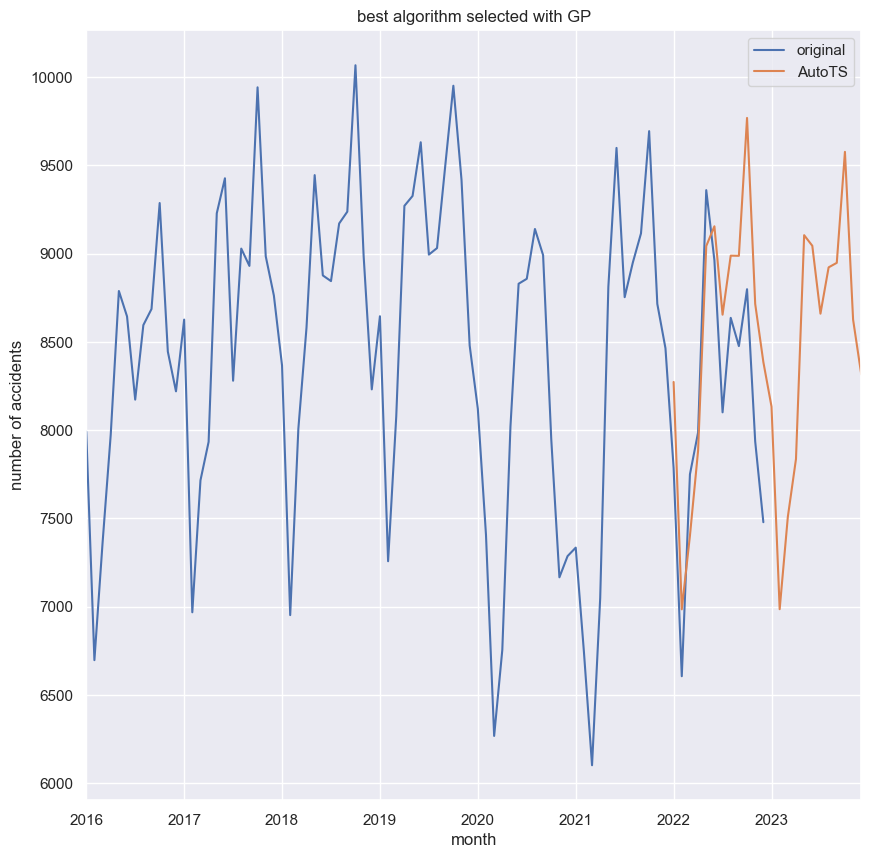

In [156]:
# add results to monthly_predict_df
monthly_predict_df['AutoTS'] = [np.nan] * len(monthly_count_train) + list(forecast['predicted'])

# plot the results
monthly_predict_df[['original', 'AutoTS']].plot()
plt.title("best algorithm selected with GP")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [150]:
model_daily = AutoTS(forecast_length=30)
model_daily = model_daily.fit(daily_count_train, date_col='ds', value_col='y', id_col=None)

Inferred frequency is: D
Model Number: 1 with model ARIMA in generation 0 of 10
Model Number: 2 with model AverageValueNaive in generation 0 of 10
Model Number: 3 with model AverageValueNaive in generation 0 of 10
Model Number: 4 with model AverageValueNaive in generation 0 of 10
Model Number: 5 with model DatepartRegression in generation 0 of 10
Model Number: 6 with model DatepartRegression in generation 0 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 7 with model DatepartRegression in generation 0 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 8 with model DatepartRegression in generation 0 of 10
Epoch 1/50
68/68 [==============================] - 11s 6ms/step - loss: 0.3625
Epoch 2/50
68/68 [==============================] - 1s 9ms/step - loss: 0.2985
Epoch 3/50
68/68 [==============================] - 0s 7ms/step - loss: 0.2850
Epoch 4/50
68/68 [==============================] - 0s 7ms/step - loss: 0.2700
Epoch 5/50
68/68 [==============================] - 1s 9ms/step - loss: 0.2588
Epoch 6/50
68/68 [==============================] - 0s 7ms/step - loss: 0.2598
Epoch 7/50
68/68 [==============================] - 1s 9ms/step - loss: 0.2560
Epoch 8/50
68/68 [==============================] - 0s 7ms/step - loss: 0.2552
Epoch 9/50
68/68 [==============================] - 1s 8ms/step - loss: 0.2528
Epoch 10/50
68/68 [==============================] - 1s 9ms/step - loss: 0.2482
Epoch 11/50
68/68 [==============================] - 0s 6ms/step - loss: 0.2443
Epoch 12/50
68/68 [==============================] - 1s 9ms/

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 36 with model FBProphet in generation 0 of 10


23:34:48 - cmdstanpy - INFO - Chain [1] start processing
23:34:48 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 37 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue.') in model 37 in generation 0: GluonTS
Model Number: 38 with model MultivariateRegression in generation 0 of 10
Model Number: 39 with model MultivariateRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 39 in generation 0: MultivariateRegression
Model Number: 40 with model DatepartRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 40 in generation 0: DatepartRegression
Model Number: 41 with model SeasonalNaive in generation 0 of 10
Model Number: 42 with model DatepartRegression in generation 0 of 10
Model Number: 43 with model UnobservedComponents in generation 0 of 10
Model Number: 44 with model UnobservedComponents in generation 0 of 10
Model

23:34:59 - cmdstanpy - INFO - Chain [1] start processing
23:35:01 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 56 with model SeasonalNaive in generation 0 of 10
Model Number: 57 with model DatepartRegression in generation 0 of 10
Model Number: 58 with model NVAR in generation 0 of 10
Model Number: 59 with model Theta in generation 0 of 10
Model Number: 60 with model UnivariateRegression in generation 0 of 10
Model Number: 61 with model ARCH in generation 0 of 10
Model Number: 62 with model ConstantNaive in generation 0 of 10
Model Number: 63 with model LastValueNaive in generation 0 of 10
Model Number: 64 with model AverageValueNaive in generation 0 of 10
Model Number: 65 with model GLS in generation 0 of 10
Model Number: 66 with model SeasonalNaive in generation 0 of 10
Model Number: 67 with model GLM in generation 0 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1342: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)


Model Number: 68 with model ETS in generation 0 of 10
Model Number: 69 with model FBProphet in generation 0 of 10


23:35:06 - cmdstanpy - INFO - Chain [1] start processing
23:35:07 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 70 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue.') in model 70 in generation 0: GluonTS
Model Number: 71 with model UnobservedComponents in generation 0 of 10
Model Number: 72 with model VAR in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 72 in generation 0: VAR
Model Number: 73 with model VECM in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VECM') in model 73 in generation 0: VECM
Model Number: 74 with model ARIMA in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 74 in generation 0: ARIMA
Model Number: 75 with model WindowRegression in generation 0 of 10
Model Number: 76 with model DatepartRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 106 with model ETS in generation 0 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'rolling_mean_24', 'transformations': {'0': 'ClipOutliers', '1': 'Detrend', '2': 'cffilter', '3': 'AlignLastValue'}, 'transformation_params': {'0': {'method': 'clip', 'std_threshold': 5, 'fillna': None}, '1': {'model': 'Linear', 'phi': 1, 'window': None, 'transform_dict': None}, '2': {}, '3': {'rows': 1, 'lag': 1, 'method': 'multiplicative', 'strength': 1.0, 'first_value_only': False}}}. fail_on_forecast_nan=True") in model 106 in generation 0: ETS
Model Number: 107 with model UnobservedComponents in generation 0 of 10
Model Number: 108 with model NVAR in generation 0 of 10
Model Number: 109 with model Gluo

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 113 with model VAR in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 113 in generation 0: VAR
Model Number: 114 with model ETS in generation 0 of 10
Model Number: 115 with model ETS in generation 0 of 10
Model Number: 116 with model UnobservedComponents in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 116 in generation 0: UnobservedComponents
Model Number: 117 with model ETS in generation 0 of 10
Model Number: 118 with model SeasonalNaive in generation 0 of 10
Model Number: 119 with model ARIMA in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 119 in generation 0: ARIMA
Model Number: 120 with model SeasonalNaive in generation 0 of 10
Model Number: 121 with model GLS in generation 0 of 10
Model Number: 122 with model UnivariateMotif in generation 0 of 10
Model Number: 123 with model V

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.327e+01, tolerance: 3.846e-03
  model = cd_fast.enet_coordinate_descent(


Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 139 in generation 0: ETS
Model Number: 140 with model ConstantNaive in generation 0 of 10
Model Number: 141 with model MultivariateRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 141 in generation 0: MultivariateRegression
Model Number: 142 with model VAR in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 142 in generation 0: VAR
Model Number: 143 with model NVAR in generation 0 of 10
Model Number: 144 with model SeasonalNaive in generation 0 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 144 in generation 0: SeasonalNaive
Model Number: 145 with model LastValueNaive in generation 0 of 10
Model Number: 146 with model LastValueNaive in generation 0 of 10
Model Number: 147 with model FBProphet in generation 0 of 10


23:35:43 - cmdstanpy - INFO - Chain [1] start processing
23:35:43 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 148 with model LastValueNaive in generation 0 of 10
Model Number: 149 with model SeasonalNaive in generation 0 of 10
Model Number: 150 with model NVAR in generation 0 of 10
Model Number: 151 with model MultivariateRegression in generation 0 of 10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Template Eval Error: LightGBMError('[poisson]: at least one target label is negative') in model 151 in generation 0: MultivariateRegression
Model Number: 152 with model VECM in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 152 in generation 0: VECM
Model Number: 153 with model NVAR in generation 0 of 10
Model Number: 154 with model AverageValueNaive in generation 0 of 10
Model Number: 155 with model ARC

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 174 with model Theta in generation 0 of 10
Model Number: 175 with model ARDL in generation 0 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 175 in generation 0: ARDL
Model Number: 176 with model DatepartRegression in generation 0 of 10
Model Number: 177 with model UnobservedComponents in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 177 in generation 0: UnobservedComponents
Model Number: 178 with model UnobservedComponents in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 178 in generation 0: UnobservedComponents
Model Number: 179 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue.') in model 179 in generation 0: GluonTS
Model Number: 180 with model GLS in generation 0 o

68/68 [==============================] - 22s 324ms/step - loss: 25.8072
Epoch 76/100
68/68 [==============================] - 16s 228ms/step - loss: 25.7992
Epoch 77/100
68/68 [==============================] - 11s 161ms/step - loss: 25.8058
Epoch 78/100
68/68 [==============================] - 11s 160ms/step - loss: 25.7966
Epoch 79/100
68/68 [==============================] - 13s 190ms/step - loss: 25.8047
Epoch 80/100
68/68 [==============================] - 11s 160ms/step - loss: 25.8030
Epoch 81/100
68/68 [==============================] - 11s 159ms/step - loss: 25.8123
Epoch 82/100
68/68 [==============================] - 11s 159ms/step - loss: 25.7961
Epoch 83/100
68/68 [==============================] - 11s 159ms/step - loss: 25.7937
Epoch 84/100
68/68 [==============================] - 11s 158ms/step - loss: 25.7939
Epoch 85/100
68/68 [==============================] - 11s 161ms/step - loss: 25.7929
Epoch 86/100
68/68 [==============================] - 11s 158ms/step - loss: 2

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 195 with model UnivariateRegression in generation 1 of 10
Model Number: 196 with model DatepartRegression in generation 1 of 10
Model Number: 197 with model FBProphet in generation 1 of 10


23:53:26 - cmdstanpy - INFO - Chain [1] start processing
23:53:29 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 198 with model GLS in generation 1 of 10
Model Number: 199 with model WindowRegression in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 200 with model DatepartRegression in generation 1 of 10
Epoch 1/50
68/68 [==============================] - 11s 8ms/step - loss: 0.0488
Epoch 2/50
68/68 [==============================] - 0s 6ms/step - loss: 0.0336
Epoch 3/50
68/68 [==============================] - 1s 9ms/step - loss: 0.0323
Epoch 4/50
68/68 [==============================] - 0s 7ms/step - loss: 0.0319
Epoch 5/50
68/68 [==============================] - 1s 9ms/step - loss: 0.0317
Epoch 6/50
68/68 [==============================] - 0s 7ms/step - loss: 0.0307
Epoch 7/50
68/68 [==============================] - 1s 9ms/step - loss: 0.0307
Epoch 8/50
68/68 [==============================] - 0s 7ms/step - loss: 0.0304
Epoch 9/50
68/68 [==============================] - 1s 9ms/step - loss: 0.0301
Epoch 10/50
68/68 [==============================] - 1s 7ms/step - loss: 0.0301
Epoch 11/50
68/68 [==============================] - 1s 9ms/step - loss: 0.0300
Epoch 12/50
68/68 [==============================] - 1s 8m

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: invalid value encountered in multiply
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)



Model Number: 219 with model MultivariateRegression in generation 1 of 10
Model Number: 220 with model NVAR in generation 1 of 10
Model Number: 221 with model GLS in generation 1 of 10
Model Number: 222 with model MultivariateMotif in generation 1 of 10
Model Number: 223 with model SectionalMotif in generation 1 of 10
Model Number: 224 with model MultivariateMotif in generation 1 of 10
Model Number: 225 with model SectionalMotif in generation 1 of 10
Model Number: 226 with model ARCH in generation 1 of 10
Model Number: 227 with model DatepartRegression in generation 1 of 10
Model Number: 228 with model ARDL in generation 1 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 228 in generation 1: ARDL
Model Number: 229 with model MultivariateMotif in generation 1 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 229 in generation 1: MultivariateMotif
Model Number: 230 with model SeasonalNaive in gene

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 231 with model Theta in generation 1 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 231 in generation 1: Theta
Model Number: 232 with model MetricMotif in generation 1 of 10
Model Number: 233 with model DatepartRegression in generation 1 of 10
Model Number: 234 with model ETS in generation 1 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 235 with model GLM in generation 1 of 10
Model Number: 236 with model DatepartRegression in generation 1 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 236 in generation 1: DatepartRegression
Model Number: 237 with model ETS in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 238 with model GLS in generation 1 of 10
Model Number: 239 with model AverageValueNaive in generation 1 of 10
Model Number: 240 with model DatepartRegression in generation 1 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 240 in generation 1: DatepartRegression
Model Number: 241 with model MultivariateMotif in generation 1 of 10
Model Number: 242 with model MultivariateMotif in generation 1 of 10
Model Number: 243 with model Theta in generation 1 of 10
Model Number: 244 with model GLM in generation 1 of 10
Model Number: 245 with model ETS in generation 1 of 10
Model Number: 246 with model UnobservedComponents in generation 1 of 10
Model Number: 247 with model SeasonalNaive in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 248 with model SeasonalNaive in generation 1 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 248 in generation 1: SeasonalNaive
Model Number: 249 with model MetricMotif in generation 1 of 10
Model Number: 250 with model WindowRegression in generation 1 of 10
Model Number: 251 with model UnivariateMotif in generation 1 of 10
Model Number: 252 with model ETS in generation 1 of 10
Model Number: 253 with model UnivariateMotif in generation 1 of 10
Model Number: 254 with model ETS in generation 1 of 10
Model Number: 255 with model Theta in generation 1 of 10
Model Number: 256 with model UnobservedComponents in generation 1 of 10
Model Number: 257 with model LastValueNaive in generation 1 of 10
Model Number: 258 with model ConstantNaive in generation 1 of 10
Model Number: 259 with model ARCH in generation 1 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 259 in generation 1: ARCH
Model Nu

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 265 with model SectionalMotif in generation 1 of 10
Model Number: 266 with model MultivariateMotif in generation 1 of 10
Model Number: 267 with model SeasonalNaive in generation 1 of 10
Model Number: 268 with model LastValueNaive in generation 1 of 10
Model Number: 269 with model GLM in generation 1 of 10
Model Number: 270 with model LastValueNaive in generation 1 of 10
Model Number: 271 with model AverageValueNaive in generation 1 of 10
Model Number: 272 with model SectionalMotif in generation 1 of 10
Model Number: 273 with model GLS in generation 1 of 10
Model Number: 274 with model UnivariateMotif in generation 1 of 10
Model Number: 275 with model DatepartRegression in generation 1 of 10
Model Number: 276 with model ARDL in generation 1 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 276 in generation 1: ARDL
Model Number: 277 with model LastValueNaive in generation 1 of 10
Model Number: 278 with model LastValueNaive in generati

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 280 with model WindowRegression in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 281 with model DatepartRegression in generation 1 of 10
Model Number: 282 with model MultivariateMotif in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 283 with model GLM in generation 1 of 10
Model Number: 284 with model ARCH in generation 1 of 10
Model Number: 285 with model ETS in generation 1 of 10
Model Number: 286 with model UnivariateMotif in generation 1 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 286 in generation 1: UnivariateMotif
Model Number: 287 with model UnivariateRegression in generation 1 of 10
Model Number: 288 with model UnobservedComponents in generation 1 of 10
Model Number: 289 with model GLM in generation 1 of 10
Model Number: 290 with model MultivariateMotif in generation 1 of 10
Model Number: 291 with model LastValueNaive in generation 1 of 10
Model Number: 292 with model FBProphet in generation 1 of 10
No anomalies detected.


23:55:23 - cmdstanpy - INFO - Chain [1] start processing
23:55:23 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 293 with model ARCH in generation 1 of 10
Model Number: 294 with model DatepartRegression in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 295 with model Theta in generation 1 of 10
Model Number: 296 with model MetricMotif in generation 1 of 10
Model Number: 297 with model GLS in generation 1 of 10
Model Number: 298 with model AverageValueNaive in generation 1 of 10
Model Number: 299 with model MultivariateRegression in generation 1 of 10
Model Number: 300 with model FBProphet in generation 1 of 10


23:55:47 - cmdstanpy - INFO - Chain [1] start processing
23:55:52 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 301 with model AverageValueNaive in generation 1 of 10
Model Number: 302 with model DatepartRegression in generation 1 of 10
Model Number: 303 with model UnobservedComponents in generation 1 of 10
Model Number: 304 with model GLM in generation 1 of 10
Model Number: 305 with model AverageValueNaive in generation 1 of 10
Model Number: 306 with model ETS in generation 1 of 10
Model Number: 307 with model UnivariateRegression in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:2418: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95352888.03081161, tolerance: 26155.862672665997
  ) = cd_fast.enet_coordinate_descent_multi_task(


Model Number: 308 with model FBProphet in generation 1 of 10


23:55:56 - cmdstanpy - INFO - Chain [1] start processing
23:55:56 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 309 with model ARIMA in generation 1 of 10
Model Number: 310 with model UnobservedComponents in generation 1 of 10
Model Number: 311 with model GLS in generation 1 of 10
New Generation: 2 of 10
Model Number: 312 with model ETS in generation 2 of 10
Model Number: 313 with model LastValueNaive in generation 2 of 10
Model Number: 314 with model MultivariateRegression in generation 2 of 10
Model Number: 315 with model MetricMotif in generation 2 of 10
Model Number: 316 with model GLS in generation 2 of 10
Model Number: 317 with model SectionalMotif in generation 2 of 10
Model Number: 318 with model Theta in generation 2 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 318 in generation 2: Theta
Model Number: 319 with model MultivariateMotif in generation 2 of 10
Model Number: 320 with model MultivariateMotif in generation 2 of 10
Model Number: 321 with model LastValueNaive in generation 2 of 10
Model Number: 322 with model ARDL in 

23:56:57 - cmdstanpy - INFO - Chain [1] start processing
23:56:57 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 326 with model SeasonalNaive in generation 2 of 10
Model Number: 327 with model UnivariateMotif in generation 2 of 10
Model Number: 328 with model UnivariateRegression in generation 2 of 10
Model Number: 329 with model ARCH in generation 2 of 10
Model Number: 330 with model ARDL in generation 2 of 10
Model Number: 331 with model GLS in generation 2 of 10
Model Number: 332 with model SectionalMotif in generation 2 of 10
Model Number: 333 with model Theta in generation 2 of 10
Model Number: 334 with model ARDL in generation 2 of 10
Model Number: 335 with model UnobservedComponents in generation 2 of 10
Model Number: 336 with model UnivariateMotif in generation 2 of 10
Model Number: 337 with model Theta in generation 2 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 337 in generation 2: Theta
Model Number: 338 with model SeasonalNaive in generation 2 of 10
Model Number: 339 with model SectionalMotif in generation 2 of 10
Model Number:

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)



Model Number: 348 with model WindowRegression in generation 2 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 348 in generation 2: WindowRegression
Model Number: 349 with model UnobservedComponents in generation 2 of 10
Model Number: 350 with model ETS in generation 2 of 10
Model Number: 351 with model SectionalMotif in generation 2 of 10
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 351 in generation 2: SectionalMotif
Model Number: 352 with model DatepartRegression in generation 2 of 10
Model Number: 353 with model AverageValueNaive in generation 2 of 10
Model Number: 354 with model Theta in generation 2 of 10
Model Number: 355 with model ETS in generation 2 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seas

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.93959e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 361 with model UnivariateMotif in generation 2 of 10
Model Number: 362 with model WindowRegression in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 363 with model MultivariateRegression in generation 2 of 10
Model Number: 364 with model UnivariateRegression in generation 2 of 10
Model Number: 365 with model SectionalMotif in generation 2 of 10
Model Number: 366 with model GLM in generation 2 of 10
Model Number: 367 with model UnivariateMotif in generation 2 of 10
Model Number: 368 with model SeasonalNaive in generation 2 of 10
Model Number: 369 with model MetricMotif in generation 2 of 10
Model Number: 370 with model FBProphet in generation 2 of 10


23:57:30 - cmdstanpy - INFO - Chain [1] start processing
23:57:33 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 371 with model GLS in generation 2 of 10
Model Number: 372 with model DatepartRegression in generation 2 of 10
Model Number: 373 with model UnobservedComponents in generation 2 of 10
Model Number: 374 with model UnivariateMotif in generation 2 of 10
Model Number: 375 with model SeasonalNaive in generation 2 of 10
Model Number: 376 with model LastValueNaive in generation 2 of 10
Model Number: 377 with model FBProphet in generation 2 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 377 in generation 2: FBProphet
Model Number: 378 with model GLM in generation 2 of 10
Model Number: 379 with model GLM in generation 2 of 10
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 379 in generation 2: GLM
Model Number: 380 with model GLM in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 381 with model MultivariateRegression in generation 2 of 10
Model Number: 382 with model GLS in generation 2 of 10
Model Number: 383 with model WindowRegression in generation 2 of 10
Model Number: 384 with model ETS in generation 2 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 384 in generation 2: ETS
Model Number: 385 with model SectionalMotif in generation 2 of 10
Model Number: 386 with model FBProphet in generation 2 of 10


23:57:59 - cmdstanpy - INFO - Chain [1] start processing
23:58:00 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 387 with model ARIMA in generation 2 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 387 in generation 2: ARIMA
Model Number: 388 with model ETS in generation 2 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 389 with model MultivariateMotif in generation 2 of 10
Model Number: 390 with model MultivariateRegression in generation 2 of 10
Model Number: 391 with model NVAR in generation 2 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 391 in generation 2: NVAR
Model Number: 392 with model ETS in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Number: 393 with model SectionalMotif in generation 2 of 10
Model Number: 394 with model MultivariateRegression in generation 2 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 394 in generation 2: MultivariateRegression
Model Number: 395 with model SeasonalNaive in generation 2 of 10
Model Number: 396 with model ARCH in generation 2 of 10
Model Number: 397 with model WindowRegression in generation 2 of 10
Model Number: 398 with model SeasonalNaive in generation 2 of 10
Model Number: 399 with model UnivariateMotif in generation 2 of 10
Model Number: 400 with model ARIMA in generation 2 of 10
Model Number: 401 with model NVAR in generation 2 of 10
Model Number: 402 with model ConstantNaive in generation 2 of 10
Model Number: 403 with model SeasonalNaive in generation 2 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 403 in generation 2: SeasonalNaive
Model Number: 404 with model SectionalMot

23:59:45 - cmdstanpy - INFO - Chain [1] start processing
23:59:45 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 413 with model GLS in generation 2 of 10
Model Number: 414 with model AverageValueNaive in generation 2 of 10
Model Number: 415 with model AverageValueNaive in generation 2 of 10
Model Number: 416 with model NVAR in generation 2 of 10
Model Number: 417 with model UnivariateMotif in generation 2 of 10
Model Number: 418 with model WindowRegression in generation 2 of 10
Model Number: 419 with model MetricMotif in generation 2 of 10
Model Number: 420 with model DatepartRegression in generation 2 of 10
Epoch 1/50
109/109 [==============================] - 48s 308ms/step - loss: 446773.1562 - val_loss: 543575.9375
Epoch 2/50
109/109 [==============================] - 34s 308ms/step - loss: 328995.1250 - val_loss: 397728.2500
Epoch 3/50
109/109 [==============================] - 34s 310ms/step - loss: 232763.5000 - val_loss: 457435.0000
Epoch 4/50
109/109 [==============================] - 32s 296ms/step - loss: 169914.0469 - val_loss: 383596.3438
Epoch 5/50
109/109 [===========

00:09:31 - cmdstanpy - INFO - Chain [1] start processing
00:09:33 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 425 with model LastValueNaive in generation 2 of 10
Model Number: 426 with model ETS in generation 2 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 427 with model ConstantNaive in generation 2 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 427 in generation 2: ConstantNaive
Model Number: 428 with model MultivariateMotif in generation 2 of 10
Model Number: 429 with model SeasonalNaive in generation 2 of 10
Model Number: 430 with model Theta in generation 2 of 10
Model Number: 431 with model UnivariateMotif in generation 2 of 10
Model Number: 432 with model WindowRegression in generation 2 of 10
Model Number: 433 with model GLS in generation 2 of 10
Model Number: 434 with model AverageValueNaive in generation 2 of 10
Model Number: 435 with model ARDL in generation 2 of 10
Model Number: 436 with model UnobservedComponents in generation 2

00:09:47 - cmdstanpy - INFO - Chain [1] start processing
00:09:47 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 442 with model ETS in generation 3 of 10
Model Number: 443 with model DatepartRegression in generation 3 of 10
Model Number: 444 with model ARIMA in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 445 with model DatepartRegression in generation 3 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 445 in generation 3: DatepartRegression
Model Number: 446 with model WindowRegression in generation 3 of 10
Epoch 1/50
54/54 [==============================] - 29s 339ms/step - loss: nan - val_loss: nan
Epoch 2/50
54/54 [==============================] - 17s 310ms/step - loss: nan - val_loss: nan
Epoch 3/50
54/54 [==============================] - 20s 363ms/step - loss: nan - val_loss: nan
Epoch 4/50
54/54 [==============================] - 17s 316ms/step - loss: nan - val_loss: nan
Epoch 5/50
54/54 [==============================] - 18s 333ms/step - loss: nan - val_loss: nan
Epoch 6/50
54/54 [==============================] - 18s 339ms/step - loss: nan - val_loss: nan
Epoch 7/50
54/54 [==============================] - 17s 318ms/step - loss: nan - val_loss: nan
Epoch 8/50
54/54 [==============================] - 18s 337ms/step - loss:

C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Model Number: 474 with model MetricMotif in generation 3 of 10
Model Number: 475 with model UnivariateRegression in generation 3 of 10
Model Number: 476 with model ETS in generation 3 of 10
Model Number: 477 with model ARIMA in generation 3 of 10
Model Number: 478 with model ARIMA in generation 3 of 10
Model Number: 479 with model ARDL in generation 3 of 10
Model Number: 480 with model LastValueNaive in generation 3 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 480 in generation 3: LastValueNaive
Model Number: 481 with model MultivariateRegression in generation 3 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 481 in generation 3: MultivariateRegression
Model Number: 482 with model DatepartRegression in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 483 with model UnivariateMotif in generation 3 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 483 in generation 3: UnivariateMotif
Model Number: 484 with model SeasonalNaive in generation 3 of 10
Model Number: 485 with model UnivariateRegression in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.99264e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 486 with model AverageValueNaive in generation 3 of 10
Model Number: 487 with model MultivariateMotif in generation 3 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 487 in generation 3: MultivariateMotif
Model Number: 488 with model MultivariateMotif in generation 3 of 10
Model Number: 489 with model WindowRegression in generation 3 of 10
Model Number: 490 with model MultivariateRegression in generation 3 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 490 in generation 3: MultivariateRegression
Model Number: 491 with model UnivariateMotif in generation 3 of 10
Model Number: 492 with model MultivariateMotif in generation 3 of 10
Model Number: 493 with model LastValueNaive in generation 3 of 10
Model Number: 494 with model GLM in generation 3 of 10
Model Number: 495 with model GLS in generation 3 of 10
Model Number: 496 with model GLM in generation 3 of 10
Model Number: 497 with mo

00:14:33 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 507 with model UnobservedComponents in generation 3 of 10
Model Number: 508 with model UnivariateRegression in generation 3 of 10
Model Number: 509 with model SectionalMotif in generation 3 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 509 in generation 3: SectionalMotif
Model Number: 510 with model UnivariateMotif in generation 3 of 10
Model Number: 511 with model SectionalMotif in generation 3 of 10
Model Number: 512 with model MultivariateMotif in generation 3 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 512 in generation 3: MultivariateMotif
Model Number: 513 with model WindowRegression in generation 3 of 10
Model Number: 514 with model ARIMA in generation 3 of 10
Model Number: 515 with model NVAR in generation 3 of 10
Model Number: 516 with model AverageValueNaive in generation 3 of 10
Model Number: 517 with model MultivariateMotif in generation 3 of 10
Model Number: 518 with model FBP

00:16:45 - cmdstanpy - INFO - Chain [1] start processing
00:16:48 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 519 with model FBProphet in generation 3 of 10


00:16:49 - cmdstanpy - INFO - Chain [1] start processing
00:16:50 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 520 with model MultivariateMotif in generation 3 of 10
Model Number: 521 with model NVAR in generation 3 of 10
Model Number: 522 with model SeasonalNaive in generation 3 of 10
Model Number: 523 with model MultivariateRegression in generation 3 of 10
Model Number: 524 with model MetricMotif in generation 3 of 10
Model Number: 525 with model ARCH in generation 3 of 10
Model Number: 526 with model FBProphet in generation 3 of 10


00:16:57 - cmdstanpy - INFO - Chain [1] start processing
00:16:57 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 527 with model SectionalMotif in generation 3 of 10
Model Number: 528 with model UnivariateRegression in generation 3 of 10
Model Number: 529 with model ETS in generation 3 of 10
Model Number: 530 with model WindowRegression in generation 3 of 10
Model Number: 531 with model MultivariateMotif in generation 3 of 10
Model Number: 532 with model UnivariateMotif in generation 3 of 10
Model Number: 533 with model Theta in generation 3 of 10
Model Number: 534 with model MultivariateMotif in generation 3 of 10
Template Eval Error: ValueError('Model MultivariateMotif returned NaN for one or more series. fail_on_forecast_nan=True') in model 534 in generation 3: MultivariateMotif
Model Number: 535 with model GLM in generation 3 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 535 in generation 3: GLM
Model Number: 536 with model DatepartRegression in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:550: RuntimeWarning: invalid value encountered in divide
  avg = np.multiply(a, wgt,
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1582: RuntimeWarning: invalid value encountered in log
  endog * np.log(endog / mu) + (mu - endog))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:516: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1582: RuntimeWarning: divide by zero encountered in log
  endog * np.log(endog / mu) + (mu - endog))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1582: RuntimeWarning: invalid value encountered in add
  endog * np

Model Number: 537 with model UnivariateRegression in generation 3 of 10
Model Number: 538 with model SeasonalNaive in generation 3 of 10
Model Number: 539 with model GLM in generation 3 of 10
Model Number: 540 with model UnobservedComponents in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 541 with model DatepartRegression in generation 3 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 541 in generation 3: DatepartRegression
Model Number: 542 with model UnobservedComponents in generation 3 of 10
Model Number: 543 with model UnobservedComponents in generation 3 of 10
Model Number: 544 with model MultivariateRegression in generation 3 of 10
Model Number: 545 with model WindowRegression in generation 3 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 545 in generation 3: WindowRegression
Model Number: 546 with model MultivariateRegression in generation 3 of 10
Model Number: 547 with model UnivariateMotif in generation 3 of 10
Model Number: 548 with model GLM in generation 3 of 10
Model Number: 549 with model MetricMotif in generation 3 of 10
Model Number: 550 with model SeasonalNaive in generation 3 of 10
Model Number: 551 with model UnivariateMotif i

00:17:26 - cmdstanpy - INFO - Chain [1] start processing
00:17:29 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 560 with model Theta in generation 3 of 10
Model Number: 561 with model ARDL in generation 3 of 10
New Generation: 4 of 10
Model Number: 562 with model LastValueNaive in generation 4 of 10
Model Number: 563 with model WindowRegression in generation 4 of 10
Model Number: 564 with model SectionalMotif in generation 4 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 564 in generation 4: SectionalMotif
Model Number: 565 with model UnivariateMotif in generation 4 of 10
Model Number: 566 with model SeasonalNaive in generation 4 of 10
Model Number: 567 with model NVAR in generation 4 of 10
Model Number: 568 with model SectionalMotif in generation 4 of 10
Model Number: 569 with model GLS in generation 4 of 10
Model Number: 570 with model FBProphet in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 570 in generation 4: FBProphet
Model Number: 571 with model UnobservedComponents i

00:17:38 - cmdstanpy - INFO - Chain [1] start processing
00:17:42 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 577 with model AverageValueNaive in generation 4 of 10
Model Number: 578 with model NVAR in generation 4 of 10
Model Number: 579 with model ETS in generation 4 of 10
Model Number: 580 with model UnivariateMotif in generation 4 of 10
Model Number: 581 with model FBProphet in generation 4 of 10


00:17:50 - cmdstanpy - INFO - Chain [1] start processing
00:17:51 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 582 with model FBProphet in generation 4 of 10


00:17:52 - cmdstanpy - INFO - Chain [1] start processing
00:17:53 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 583 with model FBProphet in generation 4 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 583 in generation 4: FBProphet
Model Number: 584 with model SeasonalNaive in generation 4 of 10
Model Number: 585 with model UnivariateRegression in generation 4 of 10
Model Number: 586 with model ARDL in generation 4 of 10
Model Number: 587 with model Theta in generation 4 of 10
Model Number: 588 with model MultivariateMotif in generation 4 of 10
Model Number: 589 with model Theta in generation 4 of 10
Model Number: 590 with model ETS in generation 4 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 590 in generation 4: ETS
Model Number: 591 with model UnobservedComponents in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 591 in generation 4: UnobservedComponents
Model Number: 592 with model SectionalMotif in generation 4 of 10
Model Number: 593 wit

00:18:00 - cmdstanpy - INFO - Chain [1] start processing
00:18:00 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 594 with model MultivariateRegression in generation 4 of 10
HolidayTransformer: no anomalies detected.
Model Number: 595 with model SeasonalNaive in generation 4 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 595 in generation 4: SeasonalNaive
Model Number: 596 with model MetricMotif in generation 4 of 10
Model Number: 597 with model ARCH in generation 4 of 10
Model Number: 598 with model FBProphet in generation 4 of 10


00:18:05 - cmdstanpy - INFO - Chain [1] start processing
00:18:09 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 599 with model DatepartRegression in generation 4 of 10
Model Number: 600 with model ETS in generation 4 of 10
Model Number: 601 with model UnivariateMotif in generation 4 of 10
Model Number: 602 with model MultivariateRegression in generation 4 of 10
Model Number: 603 with model ETS in generation 4 of 10
Model Number: 604 with model MultivariateMotif in generation 4 of 10
Model Number: 605 with model UnivariateRegression in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.84101e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 606 with model DatepartRegression in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 606 in generation 4: DatepartRegression
Model Number: 607 with model SectionalMotif in generation 4 of 10
Model Number: 608 with model MetricMotif in generation 4 of 10
Model Number: 609 with model AverageValueNaive in generation 4 of 10
Model Number: 610 with model DatepartRegression in generation 4 of 10
Model Number: 611 with model ARCH in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 611 in generation 4: ARCH
Model Number: 612 with model UnivariateMotif in generation 4 of 10
Model Number: 613 with model AverageValueNaive in generation 4 of 10
Model Number: 614 with model MultivariateMotif in generation 4 of 10
Model Number: 615 with model ARIMA in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 616 with model MultivariateMotif in generation 4 of 10
Model Number: 617 with model DatepartRegression in generation 4 of 10
Model Number: 618 with model WindowRegression in generation 4 of 10
Model Number: 619 with model SeasonalNaive in generation 4 of 10
Model Number: 620 with model FBProphet in generation 4 of 10
No anomalies detected.


00:18:36 - cmdstanpy - INFO - Chain [1] start processing
00:18:37 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 621 with model Theta in generation 4 of 10
Model Number: 622 with model AverageValueNaive in generation 4 of 10
Model Number: 623 with model UnivariateRegression in generation 4 of 10
Model Number: 624 with model GLS in generation 4 of 10
Model Number: 625 with model SeasonalNaive in generation 4 of 10
Model Number: 626 with model MultivariateRegression in generation 4 of 10
Model Number: 627 with model MultivariateMotif in generation 4 of 10
Model Number: 628 with model Theta in generation 4 of 10
Model Number: 629 with model AverageValueNaive in generation 4 of 10
Model Number: 630 with model UnivariateRegression in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.51003e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 631 with model SectionalMotif in generation 4 of 10
Model Number: 632 with model WindowRegression in generation 4 of 10
Epoch 1/50
52/52 [==============================] - 25s 402ms/step - loss: 51.1141 - val_loss: 33.9602
Epoch 2/50
52/52 [==============================] - 26s 492ms/step - loss: 45.5368 - val_loss: 30.4633
Epoch 3/50
52/52 [==============================] - 25s 474ms/step - loss: 41.7942 - val_loss: 27.9224
Epoch 4/50
52/52 [==============================] - 25s 480ms/step - loss: 38.5941 - val_loss: 26.0193
Epoch 5/50
52/52 [==============================] - 26s 506ms/step - loss: 36.0321 - val_loss: 24.5374
Epoch 6/50
52/52 [==============================] - 20s 381ms/step - loss: 34.4469 - val_loss: 23.3598
Epoch 7/50
52/52 [==============================] - 18s 343ms/step - loss: 32.8146 - val_loss: 22.4139
Epoch 8/50
52/52 [==============================] - 20s 382ms/step - loss: 31.4068 - val_loss: 21.6239
Epoch 9/50
52/52 [========================

00:36:37 - cmdstanpy - INFO - Chain [1] start processing
00:36:37 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 641 with model SectionalMotif in generation 4 of 10
Model Number: 642 with model ETS in generation 4 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 643 with model UnivariateMotif in generation 4 of 10
Model Number: 644 with model UnivariateRegression in generation 4 of 10
Model Number: 645 with model ARDL in generation 4 of 10
Model Number: 646 with model FBProphet in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 646 in generation 4: FBProphet
Model Number: 647 with model SectionalMotif in generation 4 of 10
Model Number: 648 with model MultivariateRegression in generation 4 of 10
Model Number: 649 with model MultivariateMotif in generation 4 of 10
Model Number: 650 with model MultivariateRegression 

00:37:23 - cmdstanpy - INFO - Chain [1] start processing
00:37:24 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 658 with model DatepartRegression in generation 4 of 10
Model Number: 659 with model UnivariateMotif in generation 4 of 10
Model Number: 660 with model MetricMotif in generation 4 of 10
Model Number: 661 with model ARCH in generation 4 of 10
Model Number: 662 with model ETS in generation 4 of 10
Model Number: 663 with model Theta in generation 4 of 10
Model Number: 664 with model SectionalMotif in generation 4 of 10
Model Number: 665 with model UnivariateRegression in generation 4 of 10
Model Number: 666 with model GLS in generation 4 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 666 in generation 4: GLS
Model Number: 667 with model NVAR in generation 4 of 10
Model Number: 668 with model WindowRegression in generation 4 of 10
Model Number: 669 with model GLM in generation 4 of 10
Model Number: 670 with model DatepartRegression in generation 4 of 10
Model Number: 671 with model WindowRegression in generation 4 of 10
Model Number: 

00:37:39 - cmdstanpy - INFO - Chain [1] start processing
00:37:39 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 673 with model MultivariateMotif in generation 4 of 10
Model Number: 674 with model MultivariateMotif in generation 4 of 10
Model Number: 675 with model MetricMotif in generation 4 of 10
Model Number: 676 with model ETS in generation 4 of 10
Model Number: 677 with model UnobservedComponents in generation 4 of 10
Model Number: 678 with model ARIMA in generation 4 of 10
Model Number: 679 with model UnivariateRegression in generation 4 of 10
Model Number: 680 with model UnivariateMotif in generation 4 of 10
Model Number: 681 with model MultivariateRegression in generation 4 of 10
Model Number: 682 with model ARIMA in generation 4 of 10
Model Number: 683 with model FBProphet in generation 4 of 10
No anomalies detected.


00:40:24 - cmdstanpy - INFO - Chain [1] start processing
00:40:27 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 684 with model DatepartRegression in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 684 in generation 4: DatepartRegression
Model Number: 685 with model AverageValueNaive in generation 4 of 10
Model Number: 686 with model ConstantNaive in generation 4 of 10
New Generation: 5 of 10
Model Number: 687 with model GLM in generation 5 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 687 in generation 5: GLM
Model Number: 688 with model DatepartRegression in generation 5 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 688 in generation 5: DatepartRegression
Model Number: 689 with model MultivariateMotif in generation 5 of 10
Model Number: 690 with model WindowRegression in generation 5 of 10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You ca

00:40:35 - cmdstanpy - INFO - Chain [1] start processing
00:40:38 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 694 with model UnivariateMotif in generation 5 of 10
Model Number: 695 with model MetricMotif in generation 5 of 10
Model Number: 696 with model MultivariateMotif in generation 5 of 10
Model Number: 697 with model MultivariateMotif in generation 5 of 10
Model Number: 698 with model ETS in generation 5 of 10
Model Number: 699 with model MultivariateRegression in generation 5 of 10
HolidayTransformer: no anomalies detected.
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 699 in generation 5: MultivariateRegression
Model Number: 700 with model GLM in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 701 with model UnivariateRegression in generation 5 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 701 in generation 5: UnivariateRegression
Model Number: 702 with model FBProphet in generation 5 of 10


00:40:58 - cmdstanpy - INFO - Chain [1] start processing
00:41:01 - cmdstanpy - INFO - Chain [1] done processing


Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 702 in generation 5: FBProphet
Model Number: 703 with model MultivariateMotif in generation 5 of 10
Model Number: 704 with model UnivariateMotif in generation 5 of 10
Model Number: 705 with model ETS in generation 5 of 10
Model Number: 706 with model MultivariateMotif in generation 5 of 10
Model Number: 707 with model WindowRegression in generation 5 of 10
Model Number: 708 with model DatepartRegression in generation 5 of 10
Model Number: 709 with model DatepartRegression in generation 5 of 10
Model Number: 710 with model AverageValueNaive in generation 5 of 10
Model Number: 711 with model SeasonalNaive in generation 5 of 10
Model Number: 712 with model WindowRegression in generation 5 of 10
Model Number: 713 with model ARDL in generation 5 of 10
Model Number: 714 with model UnivariateMotif in generation 5 of 10
Model Number: 715 with model WindowRegression in generation 5 of 10
Model Number: 716 wi

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 732 in generation 5: Theta
Model Number: 733 with model MetricMotif in generation 5 of 10
Model Number: 734 with model SectionalMotif in generation 5 of 10
Model Number: 735 with model FBProphet in generation 5 of 10


08:20:25 - cmdstanpy - INFO - Chain [1] start processing
08:20:26 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 736 with model SeasonalNaive in generation 5 of 10
Model Number: 737 with model MetricMotif in generation 5 of 10
Model Number: 738 with model SectionalMotif in generation 5 of 10
Model Number: 739 with model ARIMA in generation 5 of 10
Model Number: 740 with model MultivariateRegression in generation 5 of 10
Model Number: 741 with model UnivariateMotif in generation 5 of 10
Model Number: 742 with model UnivariateMotif in generation 5 of 10
Model Number: 743 with model AverageValueNaive in generation 5 of 10
Model Number: 744 with model LastValueNaive in generation 5 of 10
Model Number: 745 with model Theta in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 745 in generation 5: Theta
Model Number: 746 with model DatepartRegression in generation 5 of 10
Model Number: 747 with model MetricMotif in generation 5 of 10
Model Number: 748 with model SeasonalNaive in generation 5 of 10
Model Number: 749 with model SeasonalNaive in generation 5 of 10
Model Number: 750 with model FBProphet in generation 5 of 10


08:20:45 - cmdstanpy - INFO - Chain [1] start processing
08:20:46 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 751 with model DatepartRegression in generation 5 of 10
Epoch 1/50
271/271 [==============================] - 20s 26ms/step - loss: 1601707.7500
Epoch 2/50
271/271 [==============================] - 7s 26ms/step - loss: 437260.8750
Epoch 3/50
271/271 [==============================] - 8s 28ms/step - loss: 263845.3438
Epoch 4/50
271/271 [==============================] - 7s 26ms/step - loss: 169362.0781
Epoch 5/50
271/271 [==============================] - 7s 25ms/step - loss: 126554.7031
Epoch 6/50
271/271 [==============================] - 8s 31ms/step - loss: 106815.2891
Epoch 7/50
271/271 [==============================] - 8s 28ms/step - loss: 70564.8125
Epoch 8/50
271/271 [==============================] - 4s 16ms/step - loss: 62119.0312
Epoch 9/50
271/271 [==============================] - 5s 18ms/step - loss: 47699.3828
Epoch 10/50
271/271 [==============================] - 5s 17ms/step - loss: 38770.0352
Epoch 11/50
271/271 [==============================] - 4s 16m

08:25:20 - cmdstanpy - INFO - Chain [1] start processing
08:25:20 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 757 with model ARDL in generation 5 of 10
Model Number: 758 with model MultivariateMotif in generation 5 of 10
Template Eval Error: LinAlgError('Singular matrix') in model 758 in generation 5: MultivariateMotif
Model Number: 759 with model UnivariateRegression in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.08853e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 760 with model DatepartRegression in generation 5 of 10
Model Number: 761 with model MultivariateMotif in generation 5 of 10
Model Number: 762 with model MultivariateRegression in generation 5 of 10
Template Eval Error: ValueError("Input X contains infinity or a value too large for dtype('float64').") in model 762 in generation 5: MultivariateRegression
Model Number: 763 with model SectionalMotif in generation 5 of 10
Model Number: 764 with model FBProphet in generation 5 of 10


08:25:26 - cmdstanpy - INFO - Chain [1] start processing
08:25:28 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 765 with model WindowRegression in generation 5 of 10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001371 seconds.
You can set `force_col_wise=true` to remove the overhead.
Model Number: 766 with model SeasonalNaive in generation 5 of 10
Model Number: 767 with model FBProphet in generation 5 of 10
No anomalies detected.


08:25:32 - cmdstanpy - INFO - Chain [1] start processing
08:25:35 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 768 with model NVAR in generation 5 of 10
Model Number: 769 with model ARDL in generation 5 of 10
Model Number: 770 with model DatepartRegression in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 771 with model GLM in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 772 with model LastValueNaive in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.93959e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 773 with model SectionalMotif in generation 5 of 10
Model Number: 774 with model ETS in generation 5 of 10
Model Number: 775 with model MetricMotif in generation 5 of 10
Model Number: 776 with model UnobservedComponents in generation 5 of 10
Model Number: 777 with model WindowRegression in generation 5 of 10
Model Number: 778 with model ETS in generation 5 of 10
Model Number: 779 with model ETS in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 780 with model UnivariateMotif in generation 5 of 10
Model Number: 781 with model ETS in generation 5 of 10
Model Number: 782 with model FBProphet in generation 5 of 10


08:26:31 - cmdstanpy - INFO - Chain [1] start processing
08:26:33 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 783 with model MetricMotif in generation 5 of 10
Model Number: 784 with model ARDL in generation 5 of 10
Model Number: 785 with model MultivariateRegression in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 786 with model MultivariateRegression in generation 5 of 10
New Generation: 6 of 10
Model Number: 787 with model DatepartRegression in generation 6 of 10
Model Number: 788 with model ARIMA in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 788 in generation 6: ARIMA
Model Number: 789 with model LastValueNaive in generation 6 of 10
Model Number: 790 with model MultivariateMotif in generation 6 of 10
Model Number: 791 with model GLM in generation 6 of 10
Model Number: 792 with model WindowRegression in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 792 in generation 6: WindowRegression
Model Number: 793 with model GLM in generation 6 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 793 in generation 6: GLM
Model Number: 794 with model SectionalMotif in generation 6 of 10
Model Numbe

08:26:47 - cmdstanpy - INFO - Chain [1] start processing
08:26:47 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 799 with model MetricMotif in generation 6 of 10
Model Number: 800 with model SectionalMotif in generation 6 of 10
Model Number: 801 with model MetricMotif in generation 6 of 10
Model Number: 802 with model ARIMA in generation 6 of 10
Model Number: 803 with model SectionalMotif in generation 6 of 10
Model Number: 804 with model DatepartRegression in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 805 with model WindowRegression in generation 6 of 10
Model Number: 806 with model SectionalMotif in generation 6 of 10
Model Number: 807 with model UnobservedComponents in generation 6 of 10
Model Number: 808 with model FBProphet in generation 6 of 10


08:29:19 - cmdstanpy - INFO - Chain [1] start processing
08:29:20 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 809 with model MetricMotif in generation 6 of 10
Model Number: 810 with model ETS in generation 6 of 10
Model Number: 811 with model ARDL in generation 6 of 10
Model Number: 812 with model ARIMA in generation 6 of 10
Model Number: 813 with model DatepartRegression in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 813 in generation 6: DatepartRegression
Model Number: 814 with model DatepartRegression in generation 6 of 10
Model Number: 815 with model FBProphet in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 815 in generation 6: FBProphet
Model Number: 816 with model MultivariateMotif in generation 6 of 10
Model Number: 817 with model GLM in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 818 with model FBProphet in generation 6 of 10


08:29:46 - cmdstanpy - INFO - Chain [1] start processing
08:29:47 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 819 with model MultivariateMotif in generation 6 of 10
Model Number: 820 with model UnivariateMotif in generation 6 of 10
Model Number: 821 with model MultivariateMotif in generation 6 of 10
Model Number: 822 with model GLS in generation 6 of 10
Model Number: 823 with model MultivariateMotif in generation 6 of 10
Model Number: 824 with model UnivariateMotif in generation 6 of 10
Model Number: 825 with model MultivariateRegression in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 826 with model ETS in generation 6 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.93959e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 827 with model SeasonalNaive in generation 6 of 10
HolidayTransformer: no anomalies detected.
Model Number: 828 with model SectionalMotif in generation 6 of 10
Model Number: 829 with model MultivariateRegression in generation 6 of 10
Model Number: 830 with model DatepartRegression in generation 6 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 830 in generation 6: DatepartRegression
Model Number: 831 with model MultivariateMotif in generation 6 of 10
Model Number: 832 with model Theta in generation 6 of 10
Model Number: 833 with model WindowRegression in generation 6 of 10
Model Number: 834 with model MultivariateMotif in generation 6 of 10
Model Number: 835 with model AverageValueNaive in generation 6 of 10
Model Number: 836 with model ARCH in generation 6 of 10
Model Number: 837 with model FBProphet in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 837 in gener

08:30:16 - cmdstanpy - INFO - Chain [1] start processing
08:30:16 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 842 with model DatepartRegression in generation 6 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 842 in generation 6: DatepartRegression
Model Number: 843 with model WindowRegression in generation 6 of 10
Model Number: 844 with model SeasonalNaive in generation 6 of 10
Model Number: 845 with model MultivariateRegression in generation 6 of 10
Model Number: 846 with model GLM in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 847 with model ARIMA in generation 6 of 10
Model Number: 848 with model MetricMotif in generation 6 of 10
Model Number: 849 with model SectionalMotif in generation 6 of 10
Model Number: 850 with model ETS in generation 6 of 10
Model Number: 851 with model UnivariateMotif in generation 6 of 10
Model Number: 852 with model ETS in generation 6 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 853 with model UnobservedComponents in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 853 in generation 6: UnobservedComponents
Model Number: 854 with model UnivariateMotif in generation 6 of 10
Model Number: 855 with model AverageValueNaive in generation 6 of 10
Model Number: 856 with model DatepartRegression in generation 6 of 10
Model Number: 857 with model UnivariateMotif in generation 6 of 10
Model Number: 858 w

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 859 with model ARDL in generation 6 of 10
Model Number: 860 with model MultivariateRegression in generation 6 of 10
Model Number: 861 with model SeasonalNaive in generation 6 of 10
Model Number: 862 with model UnivariateMotif in generation 6 of 10
Model Number: 863 with model ETS in generation 6 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 864 with model UnivariateRegression in generation 6 of 10
Model Number: 865 with model SectionalMotif in generation 6 of 10
Model Number: 866 with model DatepartRegression in generation 6 of 10
Model Number: 867 with model WindowRegression in generation 6 of 10
Model Number: 868 with model UnobservedComponents in generation 6 of 10
Model Number: 869 with model GLS in generation 6 of 10
Model Number: 870 with model WindowRegression i

08:31:25 - cmdstanpy - INFO - Chain [1] start processing
08:31:25 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 891 with model GLM in generation 7 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 892 with model UnivariateRegression in generation 7 of 10
Model Number: 893 with model AverageValueNaive in generation 7 of 10
Model Number: 894 with model SeasonalNaive in generation 7 of 10
Model Number: 895 with model DatepartRegression in generation 7 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 895 in generation 7: DatepartRegression
Model Number: 896 with model UnobservedComponents in generation 7 of 10
Model Number: 897 with model LastValueNaive in generation 7 of 10
Model Number: 898 with model WindowRegression in generation 7 of 10
Template Eval Error: ValueError('Model WindowRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 898 in generation 7: WindowRegression
Model Number: 899 with model AverageValueNaive in generation 7 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Model Number: 900 with model MetricMotif in generation 7 of 10
Model Number: 901 with model ETS in generation 7 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 902 with model MultivariateMotif in generation 7 of 10
Model Number: 903 with model SectionalMotif in generation 7 of 10
Model Number: 904 with model FBProphet in generation 7 of 10


08:31:33 - cmdstanpy - INFO - Chain [1] start processing
08:31:34 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 905 with model ETS in generation 7 of 10
Model Number: 906 with model ETS in generation 7 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 906 in generation 7: ETS
Model Number: 907 with model ARIMA in generation 7 of 10
Model Number: 908 with model ARDL in generation 7 of 10
Model Number: 909 with model ETS in generation 7 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 910 with model NVAR in generation 7 of 10
Model Number: 911 with model SeasonalNaive in generation 7 of 10
Model Number: 912 with model FBProphet in generation 7 of 10


08:32:21 - cmdstanpy - INFO - Chain [1] start processing
08:32:22 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 913 with model SeasonalNaive in generation 7 of 10
Model Number: 914 with model FBProphet in generation 7 of 10


08:32:28 - cmdstanpy - INFO - Chain [1] start processing
08:32:28 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 915 with model ARIMA in generation 7 of 10
Model Number: 916 with model ETS in generation 7 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 916 in generation 7: ETS
Model Number: 917 with model MultivariateRegression in generation 7 of 10
Model Number: 918 with model WindowRegression in generation 7 of 10
Model Number: 919 with model MultivariateRegression in generation 7 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 919 in generation 7: MultivariateRegression
Model Number: 920 with model SectionalMotif in generation 7 of 10
Model Number: 921 with model SeasonalNaive in generation 7 of 10
Model Number: 922 with model UnivariateRegression in generation 7 of 10
Model Number: 923 with model MultivariateRegression in generation 7 of 10
Model Number: 924 with model MultivariateMotif in generation 7 of 10
Model Number: 925 with model SeasonalNaive in generation 7 of 10
Model Number: 926 wit

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:516: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:426: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: divide by zero encountered in divide
  return 1. 

Model Number: 940 with model MultivariateMotif in generation 7 of 10
Model Number: 941 with model UnobservedComponents in generation 7 of 10
Model Number: 942 with model MultivariateRegression in generation 7 of 10
Model Number: 943 with model MultivariateMotif in generation 7 of 10
Model Number: 944 with model SectionalMotif in generation 7 of 10
Model Number: 945 with model GLM in generation 7 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 946 with model MultivariateMotif in generation 7 of 10
Model Number: 947 with model Theta in generation 7 of 10
Model Number: 948 with model WindowRegression in generation 7 of 10
Model Number: 949 with model AverageValueNaive in generation 7 of 10
Model Number: 950 with model ETS in generation 7 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 951 with model ARIMA in generation 7 of 10
Model Number: 952 with model AverageValueNaive in generation 7 of 10
Model Number: 953 with model DatepartRegression in generation 7 of 10
Epoch 1/50
271/271 [==============================] - 14s 18ms/step - loss: 12.5789
Epoch 2/50
271/271 [==============================] - 5s 18ms/step - loss: 0.1570
Epoch 3/50
271/271 [==============================] - 5s 18ms/step - loss: 0.1109
Epoch

C:\Users\katka\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 956 with model DatepartRegression in generation 7 of 10
Model Number: 957 with model Theta in generation 7 of 10
Model Number: 958 with model UnivariateMotif in generation 7 of 10
Model Number: 959 with model MultivariateMotif in generation 7 of 10
Model Number: 960 with model FBProphet in generation 7 of 10


08:38:42 - cmdstanpy - INFO - Chain [1] start processing
08:38:42 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 961 with model ETS in generation 7 of 10
Model Number: 962 with model UnivariateRegression in generation 7 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 962 in generation 7: UnivariateRegression
Model Number: 963 with model DatepartRegression in generation 7 of 10
Model Number: 964 with model SectionalMotif in generation 7 of 10
Model Number: 965 with model FBProphet in generation 7 of 10


08:38:48 - cmdstanpy - INFO - Chain [1] start processing
08:38:48 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 966 with model MultivariateMotif in generation 7 of 10
Model Number: 967 with model MultivariateRegression in generation 7 of 10
Model Number: 968 with model UnivariateRegression in generation 7 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.71201e-40): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 969 with model FBProphet in generation 7 of 10


08:38:52 - cmdstanpy - INFO - Chain [1] start processing
08:38:53 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 970 with model DatepartRegression in generation 7 of 10
Model Number: 971 with model UnobservedComponents in generation 7 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 971 in generation 7: UnobservedComponents
Model Number: 972 with model MetricMotif in generation 7 of 10
Model Number: 973 with model MultivariateRegression in generation 7 of 10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Model Number: 974 with model LastValueNaive in generation 7 of 10
Model Number: 975 with model ARIMA in generation 7 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 976 with model ARIMA in generation 7 of 10
Model Number: 977 with model DatepartRegression in generation 7 of 10
Model Number: 978 with model ARCH in generation 7 of 10
Model Number: 979 with model WindowRegression in generation 7 of 10
Model Number: 980 with model UnobservedComponents in generation 7 of 10
Model Number: 981 with model WindowRegression in generation 7 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 981 in generation 7: WindowRegression
Model Number: 982 with model NVAR in generation 7 of 10
Model Number: 983 with model MultivariateRegression in generation 7 of 10
Model Number: 984 with model SectionalMotif in generation 7 of 10
Model Number: 985 with model ARDL in generation 7 of 10
Model Number: 986 with model Theta in generation 7 of 10
New Generation: 8 of 10
Model Number: 987 with model GLM in generation 8 of 10
Template Eval Error: Exception('Transformer PowerTransformer failed on fit') in model

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1582: RuntimeWarning: invalid value encountered in log
  endog * np.log(endog / mu) + (mu - endog))


Model Number: 993 with model ARCH in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Number: 994 with model SectionalMotif in generation 8 of 10
Model Number: 995 with model WindowRegression in generation 8 of 10
Model Number: 996 with model MultivariateMotif in generation 8 of 10
Model Number: 997 with model ARIMA in generation 8 of 10
Model Number: 998 with model UnivariateRegression in generation 8 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 998 in generation 8: UnivariateRegression
Model Number: 999 with model AverageValueNaive in generation 8 of 10
Model Number: 1000 with model AverageValueNaive in generation 8 of 10
Model Number: 1001 with model SectionalMotif in generation 8 of 10
Model Number: 1002 with model UnivariateRegression in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.4849e-41): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 1003 with model DatepartRegression in generation 8 of 10
Model Number: 1004 with model GLM in generation 8 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 1004 in generation 8: GLM
Model Number: 1005 with model ARDL in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1582: RuntimeWarning: invalid value encountered in log
  endog * np.log(endog / mu) + (mu - endog))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1582: RuntimeWarning: divide by zero encountered in divide
  endog * np.log(endog / mu) + (mu - endog))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:804: RuntimeWarning: divide by zero encountered in divide
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Model Number: 1006 with model SeasonalNaive in generation 8 of 10
Model Number: 1007 with model ETS in generation 8 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 1008 with model SectionalMotif in generation 8 of 10
Model Number: 1009 with model SectionalMotif in generation 8 of 10
Model Number: 1010 with model Theta in generation 8 of 10
Model Number: 1011 with model SeasonalNaive in generation 8 of 10
Model Number: 1012 with model MetricMotif in generation 8 of 10
Model Number: 1013 with model FBProphet in generation 8 of 10


08:45:37 - cmdstanpy - INFO - Chain [1] start processing
08:45:38 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1014 with model MultivariateMotif in generation 8 of 10
Model Number: 1015 with model MultivariateMotif in generation 8 of 10
Model Number: 1016 with model SectionalMotif in generation 8 of 10
Model Number: 1017 with model SectionalMotif in generation 8 of 10
Model Number: 1018 with model MetricMotif in generation 8 of 10
Model Number: 1019 with model MetricMotif in generation 8 of 10
Model Number: 1020 with model DatepartRegression in generation 8 of 10
Epoch 1/50
136/136 [==============================] - 11s 29ms/step - loss: 0.0017
Epoch 2/50
136/136 [==============================] - 4s 30ms/step - loss: 0.0015
Epoch 3/50
136/136 [==============================] - 4s 29ms/step - loss: 0.0016
Epoch 4/50
136/136 [==============================] - 4s 30ms/step - loss: 0.0015
Epoch 5/50
136/136 [==============================] - 4s 30ms/step - loss: 0.0015
Epoch 6/50
136/136 [==============================] - 4s 30ms/step - loss: 0.0016
Epoch 7/50
136/136 [==============

08:49:56 - cmdstanpy - INFO - Chain [1] start processing
08:49:56 - cmdstanpy - INFO - Chain [1] done processing


Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1032 in generation 8: FBProphet
Model Number: 1033 with model UnobservedComponents in generation 8 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 1033 in generation 8: UnobservedComponents
Model Number: 1034 with model FBProphet in generation 8 of 10
HolidayTransformer: no anomalies detected.


08:49:58 - cmdstanpy - INFO - Chain [1] start processing
08:50:01 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1035 with model LastValueNaive in generation 8 of 10
Model Number: 1036 with model UnivariateRegression in generation 8 of 10
Model Number: 1037 with model SectionalMotif in generation 8 of 10
Model Number: 1038 with model UnobservedComponents in generation 8 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1038 in generation 8: UnobservedComponents
Model Number: 1039 with model ETS in generation 8 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 1040 with model MultivariateMotif in generation 8 of 10
Model Number: 1041 with model SectionalMotif in generation 8 of 10
Model Number: 1042 with model FBProphet in generation 8 of 10


08:50:10 - cmdstanpy - INFO - Chain [1] start processing
08:50:10 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1043 with model MetricMotif in generation 8 of 10
Model Number: 1044 with model MetricMotif in generation 8 of 10
Model Number: 1045 with model FBProphet in generation 8 of 10


08:50:13 - cmdstanpy - INFO - Chain [1] start processing
08:50:13 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1046 with model SeasonalNaive in generation 8 of 10
Model Number: 1047 with model SeasonalNaive in generation 8 of 10
Model Number: 1048 with model GLS in generation 8 of 10
Model Number: 1049 with model MultivariateMotif in generation 8 of 10
Model Number: 1050 with model ARDL in generation 8 of 10
Model Number: 1051 with model SectionalMotif in generation 8 of 10
Model Number: 1052 with model DatepartRegression in generation 8 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1052 in generation 8: DatepartRegression
Model Number: 1053 with model ETS in generation 8 of 10
Model Number: 1054 with model UnobservedComponents in generation 8 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1054 in generation 8: UnobservedComponents
Model Number: 1055 with model GLM in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1056 with model MetricMotif in generation 8 of 10
Model Number: 1057 with model MetricMotif in generation 8 of 10
Model Number: 1058 with model FBProphet in generation 8 of 10


08:50:22 - cmdstanpy - INFO - Chain [1] start processing
08:50:22 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1059 with model UnivariateMotif in generation 8 of 10
Model Number: 1060 with model ARIMA in generation 8 of 10
Model Number: 1061 with model ETS in generation 8 of 10
Model Number: 1062 with model GLM in generation 8 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1062 in generation 8: GLM
Model Number: 1063 with model DatepartRegression in generation 8 of 10
Model Number: 1064 with model UnobservedComponents in generation 8 of 10
Model Number: 1065 with model ETS in generation 8 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1065 in generation 8: ETS
Model Number: 1066 with model SectionalMotif in generation 8 of 10
Model Number: 1067 with model LastValueNaive in generation 8 of 10
Model Number: 1068 with model AverageValueNaive in generation 8 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1069 with model FBProphet in generation 8 of 10


08:51:11 - cmdstanpy - INFO - Chain [1] start processing
08:51:12 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1070 with model ETS in generation 8 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1070 in generation 8: ETS
Model Number: 1071 with model MultivariateMotif in generation 8 of 10
Model Number: 1072 with model Theta in generation 8 of 10
Model Number: 1073 with model ETS in generation 8 of 10
Model Number: 1074 with model LastValueNaive in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.93959e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 1075 with model GLM in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1076 with model AverageValueNaive in generation 8 of 10
Model Number: 1077 with model ETS in generation 8 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 1078 with model ARDL in generation 8 of 10
Model Number: 1079 with model MultivariateRegression in generation 8 of 10
Model Number: 1080 with model ETS in generation 8 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 1081 with model ARIMA in generation 8 of 10
Model Number: 1082 with model UnivariateMotif in generation 8 of 10
Model Number: 1083 with model DatepartRegression in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1083 in generation 8: DatepartRegression
Model Number: 1084 with model UnivariateMotif in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 1085 with model MultivariateRegression in generation 8 of 10
Model Number: 1086 with model SectionalMotif in generation 8 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1086 in generation 8: SectionalMotif
New Generation: 9 of 10
Model Number: 1087 with model ARIMA in generation 9 of 10
Model Number: 1088 with model MultivariateMotif in generation 9 of 10
Model Number: 1089 with model ETS in generation 9 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 1090 with model SectionalMotif in generation 9 of 10
Model Number: 1091 with model SectionalMotif in generation 9 of 10
Model Number: 1092 with model UnivariateMotif in generation 9 of 10
Model Number: 1093 with model MultivariateRegression in generation 9 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1094 with model Theta in generation 9 of 10
Model Number: 10

08:54:05 - cmdstanpy - INFO - Chain [1] start processing
08:54:05 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1096 with model LastValueNaive in generation 9 of 10
Model Number: 1097 with model UnobservedComponents in generation 9 of 10
Model Number: 1098 with model GLM in generation 9 of 10
Model Number: 1099 with model UnivariateRegression in generation 9 of 10
Model Number: 1100 with model ARDL in generation 9 of 10
Model Number: 1101 with model SeasonalNaive in generation 9 of 10
Model Number: 1102 with model SectionalMotif in generation 9 of 10
Model Number: 1103 with model ARDL in generation 9 of 10
Model Number: 1104 with model DatepartRegression in generation 9 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Number: 1105 with model WindowRegression in generation 9 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1105 in generation 9: WindowRegression
Model Number: 1106 with model MultivariateRegression in generation 9 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 1106 in generation 9: MultivariateRegression
Model Number: 1107 with model FBProphet in generation 9 of 10


08:54:25 - cmdstanpy - INFO - Chain [1] start processing
08:54:25 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1108 with model ARDL in generation 9 of 10
Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'zero', 'transformations': {'0': 'Detrend', '1': 'AnomalyRemoval', '2': 'Slice', '3': 'Log'}, 'transformation_params': {'0': {'model': 'GLS', 'phi': 1, 'window': None, 'transform_dict': {'fillna': None, 'transformations': {'0': 'ClipOutliers'}, 'transformation_params': {'0': {'method': 'clip', 'std_threshold': 3}}}}, '1': {'method': 'zscore', 'method_params': {'distribution': 'norm', 'alpha': 0.05}, 'fillna': 'ffill', 'transform_dict': None}, '2': {'method': 100}, '3': {}}}. fail_on_forecast_nan=True") in model 1108 in generation 9: ARDL
Model Number: 1109 with model MetricMotif in generation 9 of 10


C:\Users\katka\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


Model Number: 1110 with model MetricMotif in generation 9 of 10
Model Number: 1111 with model WindowRegression in generation 9 of 10
Model Number: 1112 with model SeasonalNaive in generation 9 of 10
Model Number: 1113 with model AverageValueNaive in generation 9 of 10
Model Number: 1114 with model MetricMotif in generation 9 of 10
Model Number: 1115 with model DatepartRegression in generation 9 of 10
Model Number: 1116 with model MetricMotif in generation 9 of 10
Model Number: 1117 with model MetricMotif in generation 9 of 10
Model Number: 1118 with model UnobservedComponents in generation 9 of 10
Model Number: 1119 with model FBProphet in generation 9 of 10


08:54:52 - cmdstanpy - INFO - Chain [1] start processing
08:54:52 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1120 with model ETS in generation 9 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 1121 with model ARDL in generation 9 of 10
Template Eval Error: ValueError("ARDL series y failed with error IndexError('tuple index out of range') exog train None and predict None") in model 1121 in generation 9: ARDL
Model Number: 1122 with model AverageValueNaive in generation 9 of 10
Model Number: 1123 with model FBProphet in generation 9 of 10


08:55:00 - cmdstanpy - INFO - Chain [1] start processing
08:55:01 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1124 with model FBProphet in generation 9 of 10
HolidayTransformer: no anomalies detected.
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1124 in generation 9: FBProphet
Model Number: 1125 with model ARDL in generation 9 of 10
Model Number: 1126 with model UnivariateMotif in generation 9 of 10
Model Number: 1127 with model DatepartRegression in generation 9 of 10


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\fast_kalman.py:863: RuntimeWarning: overflow encountered in multiply
  return a * b.transpose((0, 2, 1))


HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Model Number: 1128 with model LastValueNaive in generation 9 of 10
Model Number: 1129 with model ETS in generation 9 of 10
Model Number: 1130 with model MultivariateRegression in generation 9 of 10
Model Number: 1131 with model AverageValueNaive in generation 9 of 10
Model Number: 1132 with model NVAR in generation 9 of 10
Model Number: 1133 with model ETS in generation 9 of 10
Model Number: 1134 with model ETS in generation 9 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 1135 with model ETS in generation 9 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 1136 with model ETS in gene

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:620: RuntimeWarning: divide by zero encountered in divide
  K = (u / d).T[:n_components]  # see (6.33) p.140


Model Number: 1144 with model AverageValueNaive in generation 9 of 10
Model Number: 1145 with model MultivariateMotif in generation 9 of 10
Model Number: 1146 with model ETS in generation 9 of 10
Model Number: 1147 with model MetricMotif in generation 9 of 10
Model Number: 1148 with model DatepartRegression in generation 9 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 1148 in generation 9: DatepartRegression
Model Number: 1149 with model ARIMA in generation 9 of 10
Model Number: 1150 with model MultivariateMotif in generation 9 of 10
Model Number: 1151 with model DatepartRegression in generation 9 of 10
Model Number: 1152 with model SeasonalNaive in generation 9 of 10
Model Number: 1153 with model UnivariateRegression in generation 9 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.13197e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 1154 with model SectionalMotif in generation 9 of 10
Model Number: 1155 with model AverageValueNaive in generation 9 of 10
Model Number: 1156 with model MultivariateRegression in generation 9 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1157 with model GLM in generation 9 of 10
Model Number: 1158 with model SectionalMotif in generation 9 of 10
Model Number: 1159 with model GLM in generation 9 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1160 with model GLS in generation 9 of 10
Model Number: 1161 with model MultivariateMotif in generation 9 of 10
Model Number: 1162 with model ARDL in generation 9 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1162 in generation 9: ARDL
Model Number: 1163 with model WindowRegression in generation 9 of 10
Model Number: 1164 with model Theta in generation 9 of 10
Model Number: 1165 with model GLM in generation 9 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1166 with model SeasonalNaive in generation 9 of 10
Model Number: 1167 with model SectionalMotif in generation 9 of 10
Model Number: 1168 with model UnivariateMotif in generation 9 of 10
Model Number: 1169 with model UnivariateRegression in generation 9 of 10
Model Number: 1170 with model Theta in generation 9 of 10
Model Number: 1171 with model Theta in generation 9 of 10
Model Number: 1172 with model SectionalMotif in generation 9 of 10
Model Number: 1173 with model DatepartRegression in generation 9 of 10
Model Number: 1174 with model ARIMA in generation 9 of 10
Model Number: 1175 with model ARIMA in generation 9 of 10
Model Number: 1176 with model LastValueNaive in generation 9 of 10
Model Number: 1177 with model MultivariateMotif in generation 9 of 10
Model Number: 1178 with model SectionalMotif in generation 9 of 10
Model Number: 1179 with model SectionalMotif in generation 9 of 10
Model Number: 1180 with model SeasonalNaive in generation 9 of 10
Model Number: 1181 

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1582: RuntimeWarning: invalid value encountered in log
  endog * np.log(endog / mu) + (mu - endog))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:516: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1582: RuntimeWarning: divide by zero encountered in divide
  endog * np.log(endog / mu) + (mu - endog))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1582: RuntimeWarning: divide by zero encountered in log
  endog * np.log(endog / mu) + (mu - endog))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1582: RuntimeWarning: invalid value encountered in add
  endog * np.log(endog / mu) + (mu - endog))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:804: RuntimeWarning: divide by ze

Model Number: 1183 with model ARDL in generation 9 of 10
HolidayTransformer: no anomalies detected.
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1183 in generation 9: ARDL
Model Number: 1184 with model UnivariateRegression in generation 9 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.71628e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 1185 with model UnivariateMotif in generation 9 of 10
Model Number: 1186 with model UnivariateMotif in generation 9 of 10
New Generation: 10 of 10
Model Number: 1187 with model SectionalMotif in generation 10 of 10
Model Number: 1188 with model SeasonalNaive in generation 10 of 10
Model Number: 1189 with model AverageValueNaive in generation 10 of 10
Model Number: 1190 with model FBProphet in generation 10 of 10


09:01:42 - cmdstanpy - INFO - Chain [1] start processing
09:01:42 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1191 with model UnivariateRegression in generation 10 of 10
Model Number: 1192 with model UnivariateMotif in generation 10 of 10
Model Number: 1193 with model WindowRegression in generation 10 of 10
Model Number: 1194 with model GLM in generation 10 of 10
Model Number: 1195 with model ARIMA in generation 10 of 10
Model Number: 1196 with model FBProphet in generation 10 of 10


09:01:57 - cmdstanpy - INFO - Chain [1] start processing
09:01:57 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1197 with model DatepartRegression in generation 10 of 10
Model Number: 1198 with model ARIMA in generation 10 of 10
Model Number: 1199 with model ARDL in generation 10 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1199 in generation 10: ARDL
Model Number: 1200 with model UnivariateMotif in generation 10 of 10
Model Number: 1201 with model FBProphet in generation 10 of 10


09:02:18 - cmdstanpy - INFO - Chain [1] start processing
09:02:18 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1202 with model AverageValueNaive in generation 10 of 10
Model Number: 1203 with model MultivariateRegression in generation 10 of 10
Model Number: 1204 with model Theta in generation 10 of 10
Model Number: 1205 with model DatepartRegression in generation 10 of 10
Model Number: 1206 with model MultivariateMotif in generation 10 of 10
Model Number: 1207 with model SectionalMotif in generation 10 of 10
Model Number: 1208 with model FBProphet in generation 10 of 10


09:02:55 - cmdstanpy - INFO - Chain [1] start processing
09:02:55 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1209 with model GLM in generation 10 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1210 with model Theta in generation 10 of 10
Model Number: 1211 with model UnivariateRegression in generation 10 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.20198e-42): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 1212 with model FBProphet in generation 10 of 10


09:03:11 - cmdstanpy - INFO - Chain [1] start processing
09:03:11 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1213 with model FBProphet in generation 10 of 10


09:03:23 - cmdstanpy - INFO - Chain [1] start processing
09:03:24 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1214 with model DatepartRegression in generation 10 of 10
Model Number: 1215 with model SectionalMotif in generation 10 of 10
Model Number: 1216 with model ARDL in generation 10 of 10
Model Number: 1217 with model UnivariateMotif in generation 10 of 10
Model Number: 1218 with model UnobservedComponents in generation 10 of 10
Model Number: 1219 with model ARDL in generation 10 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1219 in generation 10: ARDL
Model Number: 1220 with model WindowRegression in generation 10 of 10
Model Number: 1221 with model AverageValueNaive in generation 10 of 10
Model Number: 1222 with model SectionalMotif in generation 10 of 10
Model Number: 1223 with model SectionalMotif in generation 10 of 10
Model Number: 1224 with model FBProphet in generation 10 of 10


09:04:40 - cmdstanpy - INFO - Chain [1] start processing
09:04:41 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1225 with model MetricMotif in generation 10 of 10
Model Number: 1226 with model LastValueNaive in generation 10 of 10
Model Number: 1227 with model UnobservedComponents in generation 10 of 10
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 1227 in generation 10: UnobservedComponents
Model Number: 1228 with model ARIMA in generation 10 of 10
Model Number: 1229 with model UnivariateMotif in generation 10 of 10
Model Number: 1230 with model WindowRegression in generation 10 of 10
Model Number: 1231 with model LastValueNaive in generation 10 of 10
Model Number: 1232 with model ETS in generation 10 of 10
Model Number: 1233 with model MetricMotif in generation 10 of 10
Model Number: 1234 with model UnivariateMotif in generation 10 of 10
Model Number: 1235 with model UnivariateRegression in generation 10 of 10
Model Number: 1236 with model AverageValueNaive in generation 10 of 10
Model Number: 1237 with model DatepartRegression in generatio

09:05:34 - cmdstanpy - INFO - Chain [1] start processing
09:05:34 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1245 with model ARIMA in generation 10 of 10
Model Number: 1246 with model FBProphet in generation 10 of 10


09:05:40 - cmdstanpy - INFO - Chain [1] start processing
09:05:40 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1247 with model ETS in generation 10 of 10
Model Number: 1248 with model MultivariateMotif in generation 10 of 10
Model Number: 1249 with model MultivariateMotif in generation 10 of 10
Model Number: 1250 with model ARIMA in generation 10 of 10
Model Number: 1251 with model DatepartRegression in generation 10 of 10
Model Number: 1252 with model MultivariateRegression in generation 10 of 10
Model Number: 1253 with model DatepartRegression in generation 10 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1253 in generation 10: DatepartRegression
Model Number: 1254 with model FBProphet in generation 10 of 10


09:06:10 - cmdstanpy - INFO - Chain [1] start processing
09:06:10 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1255 with model ETS in generation 10 of 10
HolidayTransformer: no anomalies detected.
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1255 in generation 10: ETS
Model Number: 1256 with model ARIMA in generation 10 of 10
Model Number: 1257 with model DatepartRegression in generation 10 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 1257 in generation 10: DatepartRegression
Model Number: 1258 with model AverageValueNaive in generation 10 of 10
Model Number: 1259 with model MultivariateMotif in generation 10 of 10
Model Number: 1260 with model SectionalMotif in generation 10 of 10
Model Number: 1261 with model SectionalMotif in generation 10 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1261 in generation 10: SectionalMotif
Model Number: 1262 with model Ensemble in generation 11 of Ensembles


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1263 with model Ensemble in generation 11 of Ensembles


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1264 with model Ensemble in generation 11 of Ensembles
Model Number: 1265 with model Ensemble in generation 11 of Ensembles


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1266 with model Ensemble in generation 11 of Ensembles


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1267 with model Ensemble in generation 11 of Ensembles


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1268 with model Ensemble in generation 11 of Ensembles
Model Number: 1269 with model Ensemble in generation 11 of Ensembles
Model Number: 1270 with model Ensemble in generation 11 of Ensembles


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1271 with model Ensemble in generation 11 of Ensembles


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Validation Round: 1
Model Number: 1 of 191 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


📈 1 - Ensemble with avg smape 9.11: 
Model Number: 2 of 191 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


2 - Ensemble with avg smape 9.11: 
Model Number: 3 of 191 with model Ensemble for Validation 1
3 - Ensemble with avg smape 9.21: 
Model Number: 4 of 191 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


4 - Ensemble with avg smape 9.23: 
Model Number: 5 of 191 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


📈 5 - Ensemble with avg smape 9.05: 
Model Number: 6 of 191 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


6 - Ensemble with avg smape 9.16: 
Model Number: 7 of 191 with model ETS for Validation 1
7 - ETS with avg smape 9.52: 
Model Number: 8 of 191 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


8 - Ensemble with avg smape 9.14: 
Model Number: 9 of 191 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


9 - Ensemble with avg smape 9.15: 
Model Number: 10 of 191 with model UnivariateMotif for Validation 1
10 - UnivariateMotif with avg smape 9.19: 
Model Number: 11 of 191 with model ETS for Validation 1
11 - ETS with avg smape 9.77: 
Model Number: 12 of 191 with model GLM for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


📈 12 - GLM with avg smape 8.95: 
Model Number: 13 of 191 with model ARIMA for Validation 1
13 - ARIMA with avg smape 9.11: 
Model Number: 14 of 191 with model ARIMA for Validation 1
14 - ARIMA with avg smape 9.23: 
Model Number: 15 of 191 with model DatepartRegression for Validation 1
15 - DatepartRegression with avg smape 9.9: 
Model Number: 16 of 191 with model SectionalMotif for Validation 1
📈 16 - SectionalMotif with avg smape 8.88: 
Model Number: 17 of 191 with model SectionalMotif for Validation 1
📈 17 - SectionalMotif with avg smape 8.83: 
Model Number: 18 of 191 with model SectionalMotif for Validation 1
18 - SectionalMotif with avg smape 9.04: 
Model Number: 19 of 191 with model FBProphet for Validation 1


09:13:07 - cmdstanpy - INFO - Chain [1] start processing
09:13:07 - cmdstanpy - INFO - Chain [1] done processing


19 - FBProphet with avg smape 9.03: 
Model Number: 20 of 191 with model UnivariateMotif for Validation 1
20 - UnivariateMotif with avg smape 9.64: 
Model Number: 21 of 191 with model ARIMA for Validation 1
21 - ARIMA with avg smape 9.17: 
Model Number: 22 of 191 with model SectionalMotif for Validation 1
📈 22 - SectionalMotif with avg smape 8.79: 
Model Number: 23 of 191 with model UnivariateRegression for Validation 1
23 - UnivariateRegression with avg smape 12.5: 
Model Number: 24 of 191 with model SectionalMotif for Validation 1
📈 24 - SectionalMotif with avg smape 8.55: 
Model Number: 25 of 191 with model SectionalMotif for Validation 1
25 - SectionalMotif with avg smape 9.14: 
Model Number: 26 of 191 with model DatepartRegression for Validation 1
26 - DatepartRegression with avg smape 8.91: 
Model Number: 27 of 191 with model FBProphet for Validation 1


09:13:42 - cmdstanpy - INFO - Chain [1] start processing
09:13:43 - cmdstanpy - INFO - Chain [1] done processing


27 - FBProphet with avg smape 9.59: 
Model Number: 28 of 191 with model SectionalMotif for Validation 1
28 - SectionalMotif with avg smape 9.01: 
Model Number: 29 of 191 with model UnobservedComponents for Validation 1
📈 29 - UnobservedComponents with avg smape 8.44: 
Model Number: 30 of 191 with model SectionalMotif for Validation 1
30 - SectionalMotif with avg smape 8.97: 
Model Number: 31 of 191 with model ARIMA for Validation 1
31 - ARIMA with avg smape 8.53: 
Model Number: 32 of 191 with model FBProphet for Validation 1


09:14:10 - cmdstanpy - INFO - Chain [1] start processing
09:14:10 - cmdstanpy - INFO - Chain [1] done processing


32 - FBProphet with avg smape 8.44: 
Model Number: 33 of 191 with model FBProphet for Validation 1


09:14:12 - cmdstanpy - INFO - Chain [1] start processing
09:14:12 - cmdstanpy - INFO - Chain [1] done processing


33 - FBProphet with avg smape 8.45: 
Model Number: 34 of 191 with model FBProphet for Validation 1


09:14:14 - cmdstanpy - INFO - Chain [1] start processing
09:14:14 - cmdstanpy - INFO - Chain [1] done processing


34 - FBProphet with avg smape 8.45: 
Model Number: 35 of 191 with model GLM for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


35 - GLM with avg smape 8.98: 
Model Number: 36 of 191 with model UnobservedComponents for Validation 1
36 - UnobservedComponents with avg smape 8.54: 
Model Number: 37 of 191 with model ARIMA for Validation 1
37 - ARIMA with avg smape 8.5: 
Model Number: 38 of 191 with model ARIMA for Validation 1
38 - ARIMA with avg smape 9.0: 
Model Number: 39 of 191 with model UnivariateRegression for Validation 1
39 - UnivariateRegression with avg smape 8.91: 
Model Number: 40 of 191 with model FBProphet for Validation 1


09:18:36 - cmdstanpy - INFO - Chain [1] start processing
09:18:38 - cmdstanpy - INFO - Chain [1] done processing


40 - FBProphet with avg smape 8.55: 
Model Number: 41 of 191 with model ARIMA for Validation 1
41 - ARIMA with avg smape 8.55: 
Model Number: 42 of 191 with model ETS for Validation 1
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
42 - ETS with avg smape 8.55: 
Model Number: 43 of 191 with model ETS for Validation 1
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
43 - ETS with avg smape 8.55: 
Model Number: 44 of 191 with model FBProphet for Validation 1


09:19:44 - cmdstanpy - INFO - Chain [1] start processing
09:19:45 - cmdstanpy - INFO - Chain [1] done processing


44 - FBProphet with avg smape 9.14: 
Model Number: 45 of 191 with model DatepartRegression for Validation 1
📈 45 - DatepartRegression with avg smape 8.38: 
Model Number: 46 of 191 with model FBProphet for Validation 1


09:19:56 - cmdstanpy - INFO - Chain [1] start processing
09:19:56 - cmdstanpy - INFO - Chain [1] done processing


46 - FBProphet with avg smape 8.55: 
Model Number: 47 of 191 with model DatepartRegression for Validation 1
47 - DatepartRegression with avg smape 13.21: 
Model Number: 48 of 191 with model FBProphet for Validation 1


09:20:16 - cmdstanpy - INFO - Chain [1] start processing
09:20:16 - cmdstanpy - INFO - Chain [1] done processing


48 - FBProphet with avg smape 8.48: 
Model Number: 49 of 191 with model MultivariateMotif for Validation 1
49 - MultivariateMotif with avg smape 8.98: 
Model Number: 50 of 191 with model DatepartRegression for Validation 1
50 - DatepartRegression with avg smape 8.78: 
Model Number: 51 of 191 with model ARIMA for Validation 1
51 - ARIMA with avg smape 8.93: 
Model Number: 52 of 191 with model MetricMotif for Validation 1
52 - MetricMotif with avg smape 10.24: 
Model Number: 53 of 191 with model UnivariateRegression for Validation 1
53 - UnivariateRegression with avg smape 8.86: 
Model Number: 54 of 191 with model AverageValueNaive for Validation 1
54 - AverageValueNaive with avg smape 8.92: 
Model Number: 55 of 191 with model AverageValueNaive for Validation 1
55 - AverageValueNaive with avg smape 8.92: 
Model Number: 56 of 191 with model DatepartRegression for Validation 1
56 - DatepartRegression with avg smape 8.73: 
Model Number: 57 of 191 with model AverageValueNaive for Validation 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.81403e-40): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


81 - UnivariateRegression with avg smape 9.09: 
Model Number: 82 of 191 with model MultivariateMotif for Validation 1
82 - MultivariateMotif with avg smape 8.75: 
Model Number: 83 of 191 with model MultivariateMotif for Validation 1
83 - MultivariateMotif with avg smape 8.54: 
Model Number: 84 of 191 with model MetricMotif for Validation 1
84 - MetricMotif with avg smape 8.94: 
Model Number: 85 of 191 with model MultivariateMotif for Validation 1
85 - MultivariateMotif with avg smape 8.8: 
Model Number: 86 of 191 with model MultivariateMotif for Validation 1
86 - MultivariateMotif with avg smape 8.8: 
Model Number: 87 of 191 with model UnivariateMotif for Validation 1
87 - UnivariateMotif with avg smape 9.13: 
Model Number: 88 of 191 with model SeasonalNaive for Validation 1
88 - SeasonalNaive with avg smape 9.65: 
Model Number: 89 of 191 with model MultivariateMotif for Validation 1
89 - MultivariateMotif with avg smape 8.8: 
Model Number: 90 of 191 with model MultivariateMotif for Va

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.51385e-41): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


139 - UnivariateRegression with avg smape 11.06: 
Model Number: 140 of 191 with model GLM for Validation 1
140 - GLM with avg smape 9.29: 
Model Number: 141 of 191 with model GLM for Validation 1
141 - GLM with avg smape 8.96: 
Model Number: 142 of 191 with model MetricMotif for Validation 1
142 - MetricMotif with avg smape 15.41: 
Model Number: 143 of 191 with model UnobservedComponents for Validation 1
143 - UnobservedComponents with avg smape 15.11: 
Model Number: 144 of 191 with model GLM for Validation 1
144 - GLM with avg smape 9.35: 
Model Number: 145 of 191 with model ARDL for Validation 1
145 - ARDL with avg smape 7.74: 
Model Number: 146 of 191 with model WindowRegression for Validation 1
146 - WindowRegression with avg smape 14.86: 
Model Number: 147 of 191 with model ARDL for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


147 - ARDL with avg smape 8.79: 
Model Number: 148 of 191 with model UnivariateRegression for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.72849e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


148 - UnivariateRegression with avg smape 12.77: 
Model Number: 149 of 191 with model LastValueNaive for Validation 1
149 - LastValueNaive with avg smape 14.95: 
Model Number: 150 of 191 with model GLM for Validation 1
150 - GLM with avg smape 9.31: 
Model Number: 151 of 191 with model GLM for Validation 1
151 - GLM with avg smape 9.35: 
Model Number: 152 of 191 with model NVAR for Validation 1
152 - NVAR with avg smape 23.11: 
Model Number: 153 of 191 with model GLM for Validation 1
153 - GLM with avg smape 9.35: 
Model Number: 154 of 191 with model UnobservedComponents for Validation 1
154 - UnobservedComponents with avg smape 7.78: 
Model Number: 155 of 191 with model Theta for Validation 1
155 - Theta with avg smape 11.45: 
Model Number: 156 of 191 with model ARDL for Validation 1
156 - ARDL with avg smape 13.25: 
Model Number: 157 of 191 with model UnobservedComponents for Validation 1
157 - UnobservedComponents with avg smape 17.84: 
Model Number: 158 of 191 with model Theta for 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.25246e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


165 - UnivariateRegression with avg smape 12.75: 
Model Number: 166 of 191 with model LastValueNaive for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.00883e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


166 - LastValueNaive with avg smape 14.52: 
Model Number: 167 of 191 with model UnivariateRegression for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.12052e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


167 - UnivariateRegression with avg smape 14.5: 
Model Number: 168 of 191 with model LastValueNaive for Validation 1
168 - LastValueNaive with avg smape 14.61: 
Model Number: 169 of 191 with model LastValueNaive for Validation 1
169 - LastValueNaive with avg smape 14.62: 
Model Number: 170 of 191 with model UnivariateRegression for Validation 1
170 - UnivariateRegression with avg smape 14.71: 
Model Number: 171 of 191 with model GLM for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


171 - GLM with avg smape 16.27: 
Model Number: 172 of 191 with model UnobservedComponents for Validation 1
172 - UnobservedComponents with avg smape 10.84: 
Model Number: 173 of 191 with model NVAR for Validation 1
173 - NVAR with avg smape 7.95: 
Model Number: 174 of 191 with model NVAR for Validation 1
174 - NVAR with avg smape 17.26: 
Model Number: 175 of 191 with model ARCH for Validation 1
175 - ARCH with avg smape 16.81: 
Model Number: 176 of 191 with model GLS for Validation 1
176 - GLS with avg smape 17.72: 
Model Number: 177 of 191 with model ARCH for Validation 1
177 - ARCH with avg smape 16.14: 
Model Number: 178 of 191 with model GLS for Validation 1
178 - GLS with avg smape 17.95: 
Model Number: 179 of 191 with model ARCH for Validation 1
179 - ARCH with avg smape 16.13: 
Model Number: 180 of 191 with model GLS for Validation 1
180 - GLS with avg smape 17.01: 
Model Number: 181 of 191 with model GLS for Validation 1
181 - GLS with avg smape 16.76: 
Model Number: 182 of 191

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


📈 1 - Ensemble with avg smape 10.51: 
Model Number: 2 of 191 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


2 - Ensemble with avg smape 10.51: 
Model Number: 3 of 191 with model Ensemble for Validation 2
3 - Ensemble with avg smape 10.57: 
Model Number: 4 of 191 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


📈 4 - Ensemble with avg smape 9.33: 
Model Number: 5 of 191 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


5 - Ensemble with avg smape 9.57: 
Model Number: 6 of 191 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


6 - Ensemble with avg smape 10.04: 
Model Number: 7 of 191 with model ETS for Validation 2
7 - ETS with avg smape 9.82: 
Model Number: 8 of 191 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


📈 8 - Ensemble with avg smape 9.29: 
Model Number: 9 of 191 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


9 - Ensemble with avg smape 9.29: 
Model Number: 10 of 191 with model UnivariateMotif for Validation 2
10 - UnivariateMotif with avg smape 13.15: 
Model Number: 11 of 191 with model ETS for Validation 2
11 - ETS with avg smape 9.72: 
Model Number: 12 of 191 with model GLM for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


📈 12 - GLM with avg smape 9.14: 
Model Number: 13 of 191 with model ARIMA for Validation 2
📈 13 - ARIMA with avg smape 9.12: 
Model Number: 14 of 191 with model ARIMA for Validation 2
14 - ARIMA with avg smape 9.18: 
Model Number: 15 of 191 with model DatepartRegression for Validation 2
15 - DatepartRegression with avg smape 11.3: 
Model Number: 16 of 191 with model SectionalMotif for Validation 2
16 - SectionalMotif with avg smape 12.35: 
Model Number: 17 of 191 with model SectionalMotif for Validation 2
17 - SectionalMotif with avg smape 12.62: 
Model Number: 18 of 191 with model SectionalMotif for Validation 2
18 - SectionalMotif with avg smape 12.83: 
Model Number: 19 of 191 with model FBProphet for Validation 2


09:41:09 - cmdstanpy - INFO - Chain [1] start processing
09:41:09 - cmdstanpy - INFO - Chain [1] done processing


19 - FBProphet with avg smape 9.61: 
Model Number: 20 of 191 with model UnivariateMotif for Validation 2
20 - UnivariateMotif with avg smape 12.45: 
Model Number: 21 of 191 with model ARIMA for Validation 2
21 - ARIMA with avg smape 14.43: 
Model Number: 22 of 191 with model SectionalMotif for Validation 2
22 - SectionalMotif with avg smape 13.94: 
Model Number: 23 of 191 with model UnivariateRegression for Validation 2
23 - UnivariateRegression with avg smape 10.74: 
Model Number: 24 of 191 with model SectionalMotif for Validation 2
24 - SectionalMotif with avg smape 13.35: 
Model Number: 25 of 191 with model SectionalMotif for Validation 2
25 - SectionalMotif with avg smape 13.43: 
Model Number: 26 of 191 with model DatepartRegression for Validation 2
26 - DatepartRegression with avg smape 13.67: 
Model Number: 27 of 191 with model FBProphet for Validation 2


09:41:26 - cmdstanpy - INFO - Chain [1] start processing
09:41:27 - cmdstanpy - INFO - Chain [1] done processing


27 - FBProphet with avg smape 15.04: 
Model Number: 28 of 191 with model SectionalMotif for Validation 2
28 - SectionalMotif with avg smape 13.17: 
Model Number: 29 of 191 with model UnobservedComponents for Validation 2
29 - UnobservedComponents with avg smape 14.39: 
Model Number: 30 of 191 with model SectionalMotif for Validation 2
30 - SectionalMotif with avg smape 13.43: 
Model Number: 31 of 191 with model ARIMA for Validation 2
31 - ARIMA with avg smape 14.64: 
Model Number: 32 of 191 with model FBProphet for Validation 2


09:42:05 - cmdstanpy - INFO - Chain [1] start processing
09:42:05 - cmdstanpy - INFO - Chain [1] done processing


32 - FBProphet with avg smape 14.11: 
Model Number: 33 of 191 with model FBProphet for Validation 2


09:42:08 - cmdstanpy - INFO - Chain [1] start processing
09:42:08 - cmdstanpy - INFO - Chain [1] done processing


33 - FBProphet with avg smape 14.11: 
Model Number: 34 of 191 with model FBProphet for Validation 2


09:42:11 - cmdstanpy - INFO - Chain [1] start processing
09:42:11 - cmdstanpy - INFO - Chain [1] done processing


34 - FBProphet with avg smape 14.11: 
Model Number: 35 of 191 with model GLM for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


35 - GLM with avg smape 13.33: 
Model Number: 36 of 191 with model UnobservedComponents for Validation 2
36 - UnobservedComponents with avg smape 14.38: 
Model Number: 37 of 191 with model ARIMA for Validation 2
37 - ARIMA with avg smape 14.32: 
Model Number: 38 of 191 with model ARIMA for Validation 2
38 - ARIMA with avg smape 13.53: 
Model Number: 39 of 191 with model UnivariateRegression for Validation 2
39 - UnivariateRegression with avg smape 13.55: 
Model Number: 40 of 191 with model FBProphet for Validation 2


09:43:51 - cmdstanpy - INFO - Chain [1] start processing
09:43:51 - cmdstanpy - INFO - Chain [1] done processing


40 - FBProphet with avg smape 14.34: 
Model Number: 41 of 191 with model ARIMA for Validation 2
41 - ARIMA with avg smape 14.56: 
Model Number: 42 of 191 with model ETS for Validation 2
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
42 - ETS with avg smape 14.34: 
Model Number: 43 of 191 with model ETS for Validation 2
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
43 - ETS with avg smape 14.34: 
Model Number: 44 of 191 with model FBProphet for Validation 2


09:44:04 - cmdstanpy - INFO - Chain [1] start processing
09:44:05 - cmdstanpy - INFO - Chain [1] done processing


44 - FBProphet with avg smape 14.27: 
Model Number: 45 of 191 with model DatepartRegression for Validation 2
45 - DatepartRegression with avg smape 13.66: 
Model Number: 46 of 191 with model FBProphet for Validation 2


09:44:10 - cmdstanpy - INFO - Chain [1] start processing
09:44:10 - cmdstanpy - INFO - Chain [1] done processing


46 - FBProphet with avg smape 14.34: 
Model Number: 47 of 191 with model DatepartRegression for Validation 2
47 - DatepartRegression with avg smape 20.17: 
Model Number: 48 of 191 with model FBProphet for Validation 2


09:44:17 - cmdstanpy - INFO - Chain [1] start processing
09:44:17 - cmdstanpy - INFO - Chain [1] done processing


48 - FBProphet with avg smape 14.1: 
Model Number: 49 of 191 with model MultivariateMotif for Validation 2
49 - MultivariateMotif with avg smape 13.81: 
Model Number: 50 of 191 with model DatepartRegression for Validation 2
50 - DatepartRegression with avg smape 13.78: 
Model Number: 51 of 191 with model ARIMA for Validation 2
51 - ARIMA with avg smape 13.7: 
Model Number: 52 of 191 with model MetricMotif for Validation 2
52 - MetricMotif with avg smape 12.98: 
Model Number: 53 of 191 with model UnivariateRegression for Validation 2
53 - UnivariateRegression with avg smape 13.59: 
Model Number: 54 of 191 with model AverageValueNaive for Validation 2
54 - AverageValueNaive with avg smape 13.78: 
Model Number: 55 of 191 with model AverageValueNaive for Validation 2
55 - AverageValueNaive with avg smape 13.78: 
Model Number: 56 of 191 with model DatepartRegression for Validation 2
56 - DatepartRegression with avg smape 13.54: 
Model Number: 57 of 191 with model AverageValueNaive for Valid

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.91925e-40): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


81 - UnivariateRegression with avg smape 14.52: 
Model Number: 82 of 191 with model MultivariateMotif for Validation 2
82 - MultivariateMotif with avg smape 13.14: 
Model Number: 83 of 191 with model MultivariateMotif for Validation 2
83 - MultivariateMotif with avg smape 14.5: 
Model Number: 84 of 191 with model MetricMotif for Validation 2
84 - MetricMotif with avg smape 13.41: 
Model Number: 85 of 191 with model MultivariateMotif for Validation 2
85 - MultivariateMotif with avg smape 13.07: 
Model Number: 86 of 191 with model MultivariateMotif for Validation 2
86 - MultivariateMotif with avg smape 13.07: 
Model Number: 87 of 191 with model UnivariateMotif for Validation 2
87 - UnivariateMotif with avg smape 12.71: 
Model Number: 88 of 191 with model SeasonalNaive for Validation 2
88 - SeasonalNaive with avg smape 14.1: 
Model Number: 89 of 191 with model MultivariateMotif for Validation 2
89 - MultivariateMotif with avg smape 14.19: 
Model Number: 90 of 191 with model MultivariateMo

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.54371e-41): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


139 - UnivariateRegression with avg smape 15.18: 
Model Number: 140 of 191 with model GLM for Validation 2
140 - GLM with avg smape 9.39: 
Model Number: 141 of 191 with model GLM for Validation 2
141 - GLM with avg smape 9.33: 
Model Number: 142 of 191 with model MetricMotif for Validation 2
142 - MetricMotif with avg smape 9.74: 
Model Number: 143 of 191 with model UnobservedComponents for Validation 2
143 - UnobservedComponents with avg smape 12.88: 
Model Number: 144 of 191 with model GLM for Validation 2
144 - GLM with avg smape 9.63: 
Model Number: 145 of 191 with model ARDL for Validation 2
145 - ARDL with avg smape 8.82: 
Model Number: 146 of 191 with model WindowRegression for Validation 2
146 - WindowRegression with avg smape 12.52: 
Model Number: 147 of 191 with model ARDL for Validation 2
147 - ARDL with avg smape 9.33: 


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 148 of 191 with model UnivariateRegression for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.76201e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


148 - UnivariateRegression with avg smape 10.37: 
Model Number: 149 of 191 with model LastValueNaive for Validation 2
149 - LastValueNaive with avg smape 12.11: 
Model Number: 150 of 191 with model GLM for Validation 2
150 - GLM with avg smape 9.62: 
Model Number: 151 of 191 with model GLM for Validation 2
151 - GLM with avg smape 9.63: 
Model Number: 152 of 191 with model NVAR for Validation 2
152 - NVAR with avg smape 27.29: 
Model Number: 153 of 191 with model GLM for Validation 2
153 - GLM with avg smape 9.63: 
Model Number: 154 of 191 with model UnobservedComponents for Validation 2
154 - UnobservedComponents with avg smape 15.9: 
Model Number: 155 of 191 with model Theta for Validation 2
155 - Theta with avg smape 9.52: 
Model Number: 156 of 191 with model ARDL for Validation 2
156 - ARDL with avg smape 14.53: 
Model Number: 157 of 191 with model UnobservedComponents for Validation 2
157 - UnobservedComponents with avg smape 13.08: 
Model Number: 158 of 191 with model Theta for V

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.24581e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


165 - UnivariateRegression with avg smape 12.83: 
Model Number: 166 of 191 with model LastValueNaive for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.08109e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


166 - LastValueNaive with avg smape 10.69: 
Model Number: 167 of 191 with model UnivariateRegression for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.13496e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


167 - UnivariateRegression with avg smape 11.07: 
Model Number: 168 of 191 with model LastValueNaive for Validation 2
168 - LastValueNaive with avg smape 10.64: 
Model Number: 169 of 191 with model LastValueNaive for Validation 2
169 - LastValueNaive with avg smape 10.63: 
Model Number: 170 of 191 with model UnivariateRegression for Validation 2
170 - UnivariateRegression with avg smape 25.23: 
Model Number: 171 of 191 with model GLM for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


171 - GLM with avg smape 14.7: 
Model Number: 172 of 191 with model UnobservedComponents for Validation 2
172 - UnobservedComponents with avg smape 9.48: 
Model Number: 173 of 191 with model NVAR for Validation 2
173 - NVAR with avg smape 12.31: 
Model Number: 174 of 191 with model NVAR for Validation 2
174 - NVAR with avg smape 33.2: 
Model Number: 175 of 191 with model ARCH for Validation 2
175 - ARCH with avg smape 19.91: 
Model Number: 176 of 191 with model GLS for Validation 2
176 - GLS with avg smape 20.77: 
Model Number: 177 of 191 with model ARCH for Validation 2
177 - ARCH with avg smape 19.05: 
Model Number: 178 of 191 with model GLS for Validation 2
178 - GLS with avg smape 21.21: 
Model Number: 179 of 191 with model ARCH for Validation 2
179 - ARCH with avg smape 19.05: 
Model Number: 180 of 191 with model GLS for Validation 2
180 - GLS with avg smape 20.05: 
Model Number: 181 of 191 with model GLS for Validation 2
181 - GLS with avg smape 20.04: 
Model Number: 182 of 191 w

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


📈 1 - Ensemble with avg smape 8.49: 
Model Number: 2 of 191 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


2 - Ensemble with avg smape 8.49: 
Model Number: 3 of 191 with model Ensemble for Validation 3
📈 3 - Ensemble with avg smape 8.35: 
Model Number: 4 of 191 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


4 - Ensemble with avg smape 8.54: 
Model Number: 5 of 191 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


5 - Ensemble with avg smape 8.64: 
Model Number: 6 of 191 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


📈 6 - Ensemble with avg smape 8.32: 
Model Number: 7 of 191 with model ETS for Validation 3
7 - ETS with avg smape 8.69: 
Model Number: 8 of 191 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


8 - Ensemble with avg smape 8.63: 
Model Number: 9 of 191 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


9 - Ensemble with avg smape 8.62: 
Model Number: 10 of 191 with model UnivariateMotif for Validation 3
10 - UnivariateMotif with avg smape 9.03: 
Model Number: 11 of 191 with model ETS for Validation 3
11 - ETS with avg smape 8.37: 
Model Number: 12 of 191 with model GLM for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


12 - GLM with avg smape 8.96: 
Model Number: 13 of 191 with model ARIMA for Validation 3
13 - ARIMA with avg smape 8.55: 
Model Number: 14 of 191 with model ARIMA for Validation 3
14 - ARIMA with avg smape 8.59: 
Model Number: 15 of 191 with model DatepartRegression for Validation 3
15 - DatepartRegression with avg smape 8.43: 
Model Number: 16 of 191 with model SectionalMotif for Validation 3
16 - SectionalMotif with avg smape 8.78: 
Model Number: 17 of 191 with model SectionalMotif for Validation 3
17 - SectionalMotif with avg smape 8.71: 
Model Number: 18 of 191 with model SectionalMotif for Validation 3
18 - SectionalMotif with avg smape 9.08: 
Model Number: 19 of 191 with model FBProphet for Validation 3


10:03:40 - cmdstanpy - INFO - Chain [1] start processing
10:03:40 - cmdstanpy - INFO - Chain [1] done processing


19 - FBProphet with avg smape 9.62: 
Model Number: 20 of 191 with model UnivariateMotif for Validation 3
20 - UnivariateMotif with avg smape 8.86: 
Model Number: 21 of 191 with model ARIMA for Validation 3
21 - ARIMA with avg smape 9.36: 
Model Number: 22 of 191 with model SectionalMotif for Validation 3
22 - SectionalMotif with avg smape 9.51: 
Model Number: 23 of 191 with model UnivariateRegression for Validation 3
📈 23 - UnivariateRegression with avg smape 7.52: 
Model Number: 24 of 191 with model SectionalMotif for Validation 3
24 - SectionalMotif with avg smape 8.84: 
Model Number: 25 of 191 with model SectionalMotif for Validation 3
25 - SectionalMotif with avg smape 9.28: 
Model Number: 26 of 191 with model DatepartRegression for Validation 3
26 - DatepartRegression with avg smape 8.24: 
Model Number: 27 of 191 with model FBProphet for Validation 3


10:04:03 - cmdstanpy - INFO - Chain [1] start processing
10:04:04 - cmdstanpy - INFO - Chain [1] done processing


27 - FBProphet with avg smape 9.39: 
Model Number: 28 of 191 with model SectionalMotif for Validation 3
28 - SectionalMotif with avg smape 8.96: 
Model Number: 29 of 191 with model UnobservedComponents for Validation 3
29 - UnobservedComponents with avg smape 9.59: 
Model Number: 30 of 191 with model SectionalMotif for Validation 3
30 - SectionalMotif with avg smape 8.9: 
Model Number: 31 of 191 with model ARIMA for Validation 3
31 - ARIMA with avg smape 9.56: 
Model Number: 32 of 191 with model FBProphet for Validation 3


10:04:45 - cmdstanpy - INFO - Chain [1] start processing
10:04:45 - cmdstanpy - INFO - Chain [1] done processing


32 - FBProphet with avg smape 8.91: 
Model Number: 33 of 191 with model FBProphet for Validation 3


10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:48 - cmdstanpy - INFO - Chain [1] done processing


33 - FBProphet with avg smape 8.96: 
Model Number: 34 of 191 with model FBProphet for Validation 3


10:04:52 - cmdstanpy - INFO - Chain [1] start processing
10:04:53 - cmdstanpy - INFO - Chain [1] done processing


34 - FBProphet with avg smape 8.96: 
Model Number: 35 of 191 with model GLM for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


35 - GLM with avg smape 9.32: 
Model Number: 36 of 191 with model UnobservedComponents for Validation 3
36 - UnobservedComponents with avg smape 9.54: 
Model Number: 37 of 191 with model ARIMA for Validation 3
37 - ARIMA with avg smape 9.43: 
Model Number: 38 of 191 with model ARIMA for Validation 3
38 - ARIMA with avg smape 9.19: 
Model Number: 39 of 191 with model UnivariateRegression for Validation 3
39 - UnivariateRegression with avg smape 9.21: 
Model Number: 40 of 191 with model FBProphet for Validation 3


10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1] done processing


40 - FBProphet with avg smape 9.49: 
Model Number: 41 of 191 with model ARIMA for Validation 3
41 - ARIMA with avg smape 9.56: 
Model Number: 42 of 191 with model ETS for Validation 3
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
42 - ETS with avg smape 9.49: 
Model Number: 43 of 191 with model ETS for Validation 3
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
43 - ETS with avg smape 9.49: 
Model Number: 44 of 191 with model FBProphet for Validation 3


10:07:52 - cmdstanpy - INFO - Chain [1] start processing
10:07:52 - cmdstanpy - INFO - Chain [1] done processing


44 - FBProphet with avg smape 9.33: 
Model Number: 45 of 191 with model DatepartRegression for Validation 3
45 - DatepartRegression with avg smape 9.38: 
Model Number: 46 of 191 with model FBProphet for Validation 3


10:08:04 - cmdstanpy - INFO - Chain [1] start processing
10:08:04 - cmdstanpy - INFO - Chain [1] done processing


46 - FBProphet with avg smape 9.49: 
Model Number: 47 of 191 with model DatepartRegression for Validation 3
47 - DatepartRegression with avg smape 9.6: 
Model Number: 48 of 191 with model FBProphet for Validation 3


10:08:18 - cmdstanpy - INFO - Chain [1] start processing
10:08:18 - cmdstanpy - INFO - Chain [1] done processing


48 - FBProphet with avg smape 9.0: 
Model Number: 49 of 191 with model MultivariateMotif for Validation 3
49 - MultivariateMotif with avg smape 9.12: 
Model Number: 50 of 191 with model DatepartRegression for Validation 3
50 - DatepartRegression with avg smape 9.96: 
Model Number: 51 of 191 with model ARIMA for Validation 3
51 - ARIMA with avg smape 9.19: 
Model Number: 52 of 191 with model MetricMotif for Validation 3
52 - MetricMotif with avg smape 8.93: 
Model Number: 53 of 191 with model UnivariateRegression for Validation 3
53 - UnivariateRegression with avg smape 9.24: 
Model Number: 54 of 191 with model AverageValueNaive for Validation 3
54 - AverageValueNaive with avg smape 9.67: 
Model Number: 55 of 191 with model AverageValueNaive for Validation 3
55 - AverageValueNaive with avg smape 9.67: 
Model Number: 56 of 191 with model DatepartRegression for Validation 3
56 - DatepartRegression with avg smape 8.29: 
Model Number: 57 of 191 with model AverageValueNaive for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.02747e-40): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


81 - UnivariateRegression with avg smape 9.7: 
Model Number: 82 of 191 with model MultivariateMotif for Validation 3
82 - MultivariateMotif with avg smape 9.41: 
Model Number: 83 of 191 with model MultivariateMotif for Validation 3
83 - MultivariateMotif with avg smape 9.17: 
Model Number: 84 of 191 with model MetricMotif for Validation 3
84 - MetricMotif with avg smape 8.3: 
Model Number: 85 of 191 with model MultivariateMotif for Validation 3
85 - MultivariateMotif with avg smape 9.56: 
Model Number: 86 of 191 with model MultivariateMotif for Validation 3
86 - MultivariateMotif with avg smape 9.56: 
Model Number: 87 of 191 with model UnivariateMotif for Validation 3
87 - UnivariateMotif with avg smape 9.23: 
Model Number: 88 of 191 with model SeasonalNaive for Validation 3
88 - SeasonalNaive with avg smape 9.82: 
Model Number: 89 of 191 with model MultivariateMotif for Validation 3
89 - MultivariateMotif with avg smape 9.96: 
Model Number: 90 of 191 with model MultivariateMotif for V

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.57449e-41): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


139 - UnivariateRegression with avg smape 11.58: 
Model Number: 140 of 191 with model GLM for Validation 3
140 - GLM with avg smape 8.87: 
Model Number: 141 of 191 with model GLM for Validation 3
141 - GLM with avg smape 9.02: 
Model Number: 142 of 191 with model MetricMotif for Validation 3
142 - MetricMotif with avg smape 8.37: 
Model Number: 143 of 191 with model UnobservedComponents for Validation 3
143 - UnobservedComponents with avg smape 7.7: 
Model Number: 144 of 191 with model GLM for Validation 3
144 - GLM with avg smape 8.91: 
Model Number: 145 of 191 with model ARDL for Validation 3
145 - ARDL with avg smape 8.16: 
Model Number: 146 of 191 with model WindowRegression for Validation 3
146 - WindowRegression with avg smape 8.3: 
Model Number: 147 of 191 with model ARDL for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


147 - ARDL with avg smape 8.41: 
Model Number: 148 of 191 with model UnivariateRegression for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.76608e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


148 - UnivariateRegression with avg smape 7.54: 
Model Number: 149 of 191 with model LastValueNaive for Validation 3
149 - LastValueNaive with avg smape 7.79: 
Model Number: 150 of 191 with model GLM for Validation 3
150 - GLM with avg smape 8.92: 
Model Number: 151 of 191 with model GLM for Validation 3
151 - GLM with avg smape 8.91: 
Model Number: 152 of 191 with model NVAR for Validation 3
152 - NVAR with avg smape 17.45: 
Model Number: 153 of 191 with model GLM for Validation 3
153 - GLM with avg smape 8.91: 
Model Number: 154 of 191 with model UnobservedComponents for Validation 3
154 - UnobservedComponents with avg smape 12.84: 
Model Number: 155 of 191 with model Theta for Validation 3
155 - Theta with avg smape 9.65: 
Model Number: 156 of 191 with model ARDL for Validation 3
156 - ARDL with avg smape 11.67: 
Model Number: 157 of 191 with model UnobservedComponents for Validation 3
157 - UnobservedComponents with avg smape 8.03: 
Model Number: 158 of 191 with model Theta for Val

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.25179e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


165 - UnivariateRegression with avg smape 11.3: 
Model Number: 166 of 191 with model LastValueNaive for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.15482e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


166 - LastValueNaive with avg smape 9.49: 
Model Number: 167 of 191 with model UnivariateRegression for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.14408e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


167 - UnivariateRegression with avg smape 10.14: 
Model Number: 168 of 191 with model LastValueNaive for Validation 3
168 - LastValueNaive with avg smape 9.48: 
Model Number: 169 of 191 with model LastValueNaive for Validation 3
169 - LastValueNaive with avg smape 9.48: 
Model Number: 170 of 191 with model UnivariateRegression for Validation 3
170 - UnivariateRegression with avg smape 15.16: 
Model Number: 171 of 191 with model GLM for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


171 - GLM with avg smape 10.11: 
Model Number: 172 of 191 with model UnobservedComponents for Validation 3
172 - UnobservedComponents with avg smape 9.14: 
Model Number: 173 of 191 with model NVAR for Validation 3
173 - NVAR with avg smape 11.4: 
Model Number: 174 of 191 with model NVAR for Validation 3
174 - NVAR with avg smape 13.93: 
Model Number: 175 of 191 with model ARCH for Validation 3
175 - ARCH with avg smape 15.2: 
Model Number: 176 of 191 with model GLS for Validation 3
176 - GLS with avg smape 16.03: 
Model Number: 177 of 191 with model ARCH for Validation 3
177 - ARCH with avg smape 14.65: 
Model Number: 178 of 191 with model GLS for Validation 3
178 - GLS with avg smape 16.58: 
Model Number: 179 of 191 with model ARCH for Validation 3
179 - ARCH with avg smape 14.65: 
Model Number: 180 of 191 with model GLS for Validation 3
180 - GLS with avg smape 15.26: 
Model Number: 181 of 191 with model GLS for Validation 3
181 - GLS with avg smape 15.42: 
Model Number: 182 of 191 w

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1846 with model Ensemble in generation 12 of Ensembles


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1847 with model Ensemble in generation 12 of Ensembles


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1848 with model Ensemble in generation 12 of Ensembles


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1849 with model Ensemble in generation 12 of Ensembles


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1850 with model Ensemble in generation 12 of Ensembles


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
10:29:06 - cmdstanpy - INFO - Chain [1] start processing
10:29:06 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1851 with model Ensemble in generation 12 of Ensembles
Model Number: 1852 with model Ensemble in generation 12 of Ensembles
Model Number: 1853 with model Ensemble in generation 12 of Ensembles


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1854 with model Ensemble in generation 12 of Ensembles


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Validation Round: 1
Model Number: 1 of 10 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


📈 1 - Ensemble with avg smape 9.1: 
Model Number: 2 of 10 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


2 - Ensemble with avg smape 9.11: 
Model Number: 3 of 10 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


3 - Ensemble with avg smape 9.1: 
Model Number: 4 of 10 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


4 - Ensemble with avg smape 9.11: 
Model Number: 5 of 10 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


📈 5 - Ensemble with avg smape 9.07: 
Model Number: 6 of 10 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
10:46:16 - cmdstanpy - INFO - Chain [1] start processing
10:46:16 - cmdstanpy - INFO - Chain [1] done processing


📈 6 - Ensemble with avg smape 9.0: 
Model Number: 7 of 10 with model Ensemble for Validation 1
📈 7 - Ensemble with avg smape 8.12: 
Model Number: 8 of 10 with model Ensemble for Validation 1
8 - Ensemble with avg smape 8.12: 
Model Number: 9 of 10 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


9 - Ensemble with avg smape 9.07: 
Model Number: 10 of 10 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


10 - Ensemble with avg smape 9.07: 
Validation Round: 2
Model Number: 1 of 10 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


📈 1 - Ensemble with avg smape 9.33: 
Model Number: 2 of 10 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


📈 2 - Ensemble with avg smape 9.23: 
Model Number: 3 of 10 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


3 - Ensemble with avg smape 9.33: 
Model Number: 4 of 10 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


📈 4 - Ensemble with avg smape 9.1: 
Model Number: 5 of 10 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


5 - Ensemble with avg smape 9.13: 
Model Number: 6 of 10 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
10:53:50 - cmdstanpy - INFO - Chain [1] start processing
10:53:50 - cmdstanpy - INFO - Chain [1] done processing


6 - Ensemble with avg smape 9.42: 
Model Number: 7 of 10 with model Ensemble for Validation 2
7 - Ensemble with avg smape 12.84: 
Model Number: 8 of 10 with model Ensemble for Validation 2
8 - Ensemble with avg smape 12.84: 
Model Number: 9 of 10 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


9 - Ensemble with avg smape 9.13: 
Model Number: 10 of 10 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


10 - Ensemble with avg smape 9.13: 
Validation Round: 3
Model Number: 1 of 10 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


📈 1 - Ensemble with avg smape 8.54: 
Model Number: 2 of 10 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


2 - Ensemble with avg smape 8.59: 
Model Number: 3 of 10 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


3 - Ensemble with avg smape 8.54: 
Model Number: 4 of 10 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


📈 4 - Ensemble with avg smape 8.43: 
Model Number: 5 of 10 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


5 - Ensemble with avg smape 8.61: 
Model Number: 6 of 10 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
10:59:33 - cmdstanpy - INFO - Chain [1] start processing
10:59:33 - cmdstanpy - INFO - Chain [1] done processing


6 - Ensemble with avg smape 8.65: 
Model Number: 7 of 10 with model Ensemble for Validation 3
📈 7 - Ensemble with avg smape 7.74: 
Model Number: 8 of 10 with model Ensemble for Validation 3
8 - Ensemble with avg smape 7.74: 
Model Number: 9 of 10 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


9 - Ensemble with avg smape 8.61: 
Model Number: 10 of 10 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


10 - Ensemble with avg smape 8.61: 


In [151]:
model_daily  # show the most optimal model and its hyperparameters

Initiated AutoTS object with best model: 
Ensemble
{}
{'model_name': 'BestN', 'model_count': 5, 'model_metric': 'bestn_horizontal', 'models': {'5e1fc400ff57982820a8b2899b86cf5a': {'Model': 'ETS', 'ModelParameters': '{"damped_trend": false, "trend": "additive", "seasonal": null, "seasonal_periods": null}', 'TransformationParameters': '{"fillna": "time", "transformations": {"0": "Detrend", "1": "DatepartRegression", "2": "bkfilter"}, "transformation_params": {"0": {"model": "Linear", "phi": 1, "window": null, "transform_dict": null}, "1": {"regression_model": {"model": "ExtraTrees", "model_params": {"n_estimators": 100, "min_samples_leaf": 1, "max_depth": 10}}, "datepart_method": "recurring", "polynomial_degree": null, "transform_dict": null, "holiday_countries_used": false}, "2": {}}}'}, '8685a652921722844fbbe8c10bfd50ef': {'Model': 'GLM', 'ModelParameters': '{"family": "Binomial", "constant": false, "regression_type": "datepart"}', 'TransformationParameters': '{"fillna": "ffill", "tran

In [152]:
prediction = model_daily.predict(forecast_length=365 + days_to_predict)
forecast = prediction.forecast
forecast.columns = ['predicted']
forecast

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


predicted
2022-01-01  163.714623
2022-01-02  253.016535
2022-01-03  279.562442
2022-01-04  270.101275
2022-01-05  309.432868
...                ...
2023-12-27  209.385882
2023-12-28  207.115509
2023-12-29  210.729264
2023-12-30  183.705530
2023-12-31  128.814433

[730 rows x 1 columns]

C:\Users\katka\AppData\Local\Temp\ipykernel_9724\2515850418.py:11: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  daily_predict_df[['original', 'AutoTS']].plot()


Text(0, 0.5, 'number of accidents')

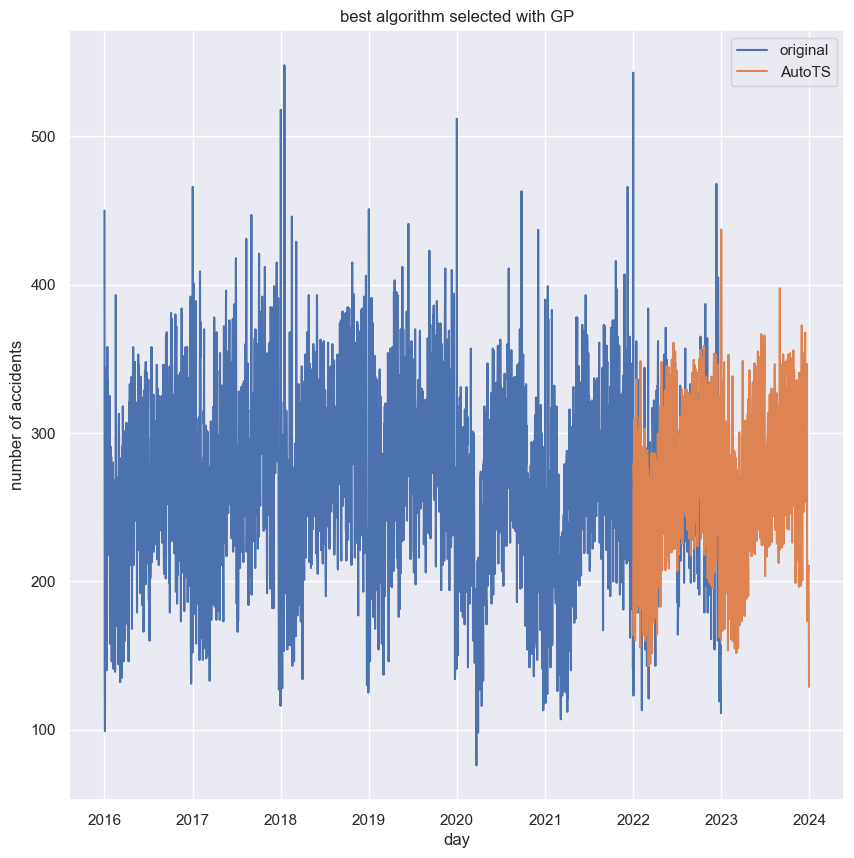

In [153]:
# add results to daily_predict_df
daily_predict_df['AutoTS'] = [np.nan] * len(daily_count_train) + list(forecast['predicted'])

# plot the result
daily_predict_df[['original', 'AutoTS']].plot()
plt.title("best algorithm selected with GP")
plt.xlabel("day")
plt.ylabel("number of accidents")

In [162]:
monthly_predict_df  # show results of all algorithms applied on monthly granularity data

original      Prophet        arima          svr      xgboost  \
ds                                                                         
2016-01-01    7992.0          NaN          NaN          NaN          NaN   
2016-02-01    6698.0          NaN          NaN          NaN          NaN   
2016-03-01    7362.0          NaN          NaN          NaN          NaN   
2016-04-01    7974.0          NaN          NaN          NaN          NaN   
2016-05-01    8788.0          NaN          NaN          NaN          NaN   
...              ...          ...          ...          ...          ...   
2023-08-01       NaN  7948.404339  8347.768376  8948.031802  8897.983398   
2023-09-01       NaN  8280.045116  8720.182490  8954.668597  8967.149414   
2023-10-01       NaN  9124.274181  8824.095956  8889.665411  9497.236328   
2023-11-01       NaN  8294.161079  8316.773308  8715.999849  8475.584961   
2023-12-01       NaN  7279.427698  8067.838726  8408.677653  8143.119141   

               catboost          rnn         lstm  random forest + GA  \
ds                                                                      
2016-01-01          NaN          NaN          NaN                 NaN   
2016-02-01          NaN          NaN          NaN                 NaN   
2016-03-01          NaN          NaN          NaN                 NaN   
2016-04-01          NaN          NaN          NaN                 NaN   
2016-05-01          NaN          NaN          NaN                 NaN   
...                 ...          ...          ...                 ...   
2023-08-01  8947.191384  8838.750502  9093.315350              8843.0   
2023-09-01  8971.107381  8894.291314  8815.979549              8843.0   
2023-10-01  9354.696706  8898.400951  8687.664519              8843.0   
2023-11-01  8539.760655  8700.910411  8944.312531              8843.0   
2023-12-01  8159.440253  8731.407426  8631.491365              8347.5   

            random forest + randomized  random forest + grid     MLP + GA  \
ds                                                                          
2016-01-01                         NaN                   NaN          NaN   
2016-02-01                         NaN                   NaN          NaN   
2016-03-01                         NaN                   NaN          NaN   
2016-04-01                         NaN                   NaN          NaN   
2016-05-01                         NaN                   NaN          NaN   
...                                ...                   ...          ...   
2023-08-01                    8992.625           9118.519167  8710.009983   
2023-09-01                    8996.925           9124.421667  8793.048631   
2023-10-01                    8841.670           9235.615000  8873.380333   
2023-11-01                    8768.455           8369.187500  8950.765809   
2023-12-01                    8393.070           8312.337500  9025.005965   

            MLP + randomized    MLP + grid       AutoTS  
ds                                                       
2016-01-01               NaN           NaN          NaN  
2016-02-01               NaN           NaN          NaN  
2016-03-01               NaN           NaN          NaN  
2016-04-01               NaN           NaN          NaN  
2016-05-01               NaN           NaN          NaN  
...                      ...           ...          ...  
2023-08-01       8400.641421  10462.474296  8921.741380  
2023-09-01       8376.366737  10442.206732  8947.380288  
2023-10-01       8275.171738  10385.827027  9575.721417  
2023-11-01       8157.178373  10315.370186  8626.088998  
2023-12-01       8032.138113  10235.424428  8316.179294  

[96 rows x 15 columns]